# Прогнозирование стоимости автомобиля по характеристикам


Необходимо создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. По условиям задачи автомобили должны быть из г. Москва. Так как в тестовой выборке марка - BMW, то будем считать, что и выборка, на которой будем обучаться и для которой предсказывать - тоже BMW. Но в целом модель должна быть не привязана к марке автомобиля. Собрать более крупную базу для обучения модели нужно с сайта  https://auto.ru/.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import sys
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import ExtraTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.base import clone

from tqdm import tqdm # обеспечивает простой индикатор выполнения для операций pandas
%matplotlib inline

In [ ]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# General Setup

In [3]:
DIR_TRAIN  = '../input/train-data-autoru/' # подключил к ноутбуку свой внешний датасет
DIR_TEST   = '../input/sf-dst-car-price/'

# Data

In [ ]:
!ls ../input/

# Посмотрю для начала, что из себя представляет тестовая выборка

In [19]:
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

## EDA для тестовой выборки

Цель данного упражнения:

* Ознакомиться с данными, которые у нас есть
* Понять, какую информацию мы сможем из них взять
* Понять, какие данные влияют на целевую переменную, а какие нет
* Понять, какие данные необходимо собирать из внешних источников
* Сформировать желаемый вид датасета, к которому будем стремиться преобразовать собранные данные

### Первичный осмотр тестовых данных

In [ ]:
test.sample(5)

In [ ]:
test.info()

Для удобства переименую столбцы на английском и в одном стиле (мне привычнее разделять слова нижним подчеркиванием)

In [20]:
test.columns = ([
    'body_type',
    'brand',
    'color',
    'fuel_type',
    'model_date_begin',
    'name',
    'number_of_doors',
    'production_date',
    'vehicle_configuration',
    'vehicle_transmission',
    'engine_displacement',
    'engine_power',
    'description',
    'mileage',
    'equipment',
    'gear_type',
    'steering_wheel',
    'not_damage',
    'owners',
    'technical_passport',
    'custom_clear',
    'ownership',
    'id',
])

In [ ]:
test.info()

Пропуски есть в колонке ownership (владение)

Напишу функцию, которая выдаст необходимую информацию для первичного анализа признака (посмотрел это решение у коллег по цеху - мне понравилось и я решил взять его на вооружение)

In [6]:
def col_info(col):
    print('Количество пропусков: {}'.format(col.isnull().sum()))
    print('{},'.format(col.describe()))
    print('Распределение:\n{},'.format(col.value_counts()))
    col.hist()

Применим функцию для анализа признака:

Сразу сделаю функцию для проверки и работе с выбросами

In [7]:
def outliers_iqr_short(ys):
    # Определяет номера значений с отклонением больше, чем iqr
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - 1.5*iqr
    upper_bound = quartile_3 + 1.5*iqr
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

def outliers_iqr_long(ys): # Передаем на вход признак-столбец датафрейма
    # Находим необходимые параметры
    median = ys.median()
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print('Медиана: {},'.format(median),'25-й перцентиль: {},'.format(quartile_1), '75-й перцентиль: {},'.format(quartile_3)
      , "IQR: {}, ".format(iqr),"Границы выбросов: [{}, {}].".format(lower_bound,upper_bound))
    # Отбрасываем значения, лежещие за пределами границ, рисуем график
#     ys.loc[ys.between(lower_bound, upper_bound)].hist(bins = int(upper_bound-lower_bound), range = (lower_bound, upper_bound), label = 'IQR')
#     plt.legend();
    # На выход отдаем отфильтрованные значения
    
    first_rec = ys.mask((ys > upper_bound) | (ys < lower_bound))
    second_rec = np.where((ys > upper_bound) | (ys < lower_bound))[0]
    
    return first_rec

In [8]:
# Функция очистки от выбросов
def delete_outliers_iqr(df, column):
    # Считаем первый и третий квартили
    first_quartile = df[column].describe()['25%']
    third_quartile = df[column].describe()['75%']

    # IQR (Межквартильный размах)
    iqr = third_quartile - first_quartile

    print(first_quartile, third_quartile, iqr)

    # Удаляем то, что выпадает за границы IQR
    #     df_tmp = df.copy()
    df = df[(df[column] > (first_quartile - 3 * iqr)) &
                (df[column] < (third_quartile + 3 * iqr))]

    df[column].hist()
    df[column].describe()

    df = df.loc[df[column].between(first_quartile - 1.5*iqr, third_quartile + 1.5*iqr)]
    df.info()

### model_date_begin - посмотрим на год модели (марки) автомобиля

In [ ]:
col_info(test.model_date_begin)

Ок. Для начала приведу год в числу без цифер после точки в конце. Пойду более полным путем - сначала приведу к to_datetime, а потом вытащу оттуда год

In [21]:
test['model_date_begin'] = pd.to_datetime(test['model_date_begin'], format='%Y').dt.year

In [ ]:
col_info(test.model_date_begin)

In [ ]:
test.model_date_begin.min()

In [ ]:
test.model_date_begin.max()

Видим, что автомобили представлены марками от 1975 по 2019 год.

Попробую сформировать новый признак - "возраст модели" (model_age). Время буду считать от текущего времени.

In [22]:
test['model_age'] = datetime.datetime.now().year - test['model_date_begin']

### model_age - посмотрим на возраст модели

In [ ]:
col_info(test.model_age)

Большая часть автомобилей представлена моделями 9-13 лет. Но много и достаточно современных моделей (марок) автомобилей - до 6 лет. Есть какие-то откровенно старые автомобили - более 45 лет модели. Посмотрю, не ошибка ли это.

In [ ]:
test[test['model_age'] > 40]

Посмотрел в интернете - действительно есть такие модели. Что ж, пусть остаются в базе для обучения модели.

Сделаем признак категориальным, все модели старше 19 лет положим в одну категорию.

In [23]:
test['model_age'] = test['model_age'].apply(lambda x: 20 if x > 19 else x)

Ну и переведу его к тестовому значению, чтобы это стало категорией

In [24]:
test['model_age'] = test['model_age'].astype('str')

### production_date - посмотрим на год производства самого автомобиля

In [ ]:
col_info(test.production_date)

Проделаю ту же операцию, что и с возрастом марки автомобиля

In [25]:
test['production_date'] = pd.to_datetime(test['production_date'], format='%Y').dt.year

Ну и добавлю колонку с возрастом автомобиля

In [26]:
test['car_age'] = datetime.datetime.now().year - test['production_date']

### car_age - посмотрим на возраст самого автомобиля

In [ ]:
col_info(test.car_age)

Медианный возраст автомобиля - 7 лет. Ну ок. Посмотрим, что нам это даст в будущем.

In [ ]:
test.sample(2)

## mileage_per_year

Сразу создам признак "пробег в год" для категоризации

In [27]:
test['mileage_per_year'] = test['mileage'] / test['car_age']

In [28]:
def cat_mileage_per_year(x):
    if x < 10000: x = 1
    elif 10000 <= x < 20000: x = 2
    elif 20000 <= x < 30000: x = 3
    elif 30000 <= x: x = 4
    return x


test['mileage_per_year'] = test['mileage_per_year'].apply(lambda x: cat_mileage_per_year(x))
test['mileage_per_year'] = test['mileage_per_year'].astype('str')

In [ ]:
col_info(test.mileage_per_year)

Попробую сгруппировать автомобили по их возрасту на основании каких-то своих личных субъективных ощущений

In [29]:
def cat_age(x):
    if x == 1 : x = 1 # типа, если автомобилю 1 год, то добавим его в категорию 1
    elif 2 <= x < 4: x = 2 # типа, если автомобилю от 2 до 3 лет включительно, то добавим его в категорию 2 и тд.
    elif 4 <= x < 6: x = 3
    elif 6 <= x < 10: x = 4
    elif 10 <= x < 16: x = 5
    elif 16 <= x < 20: x = 6
    elif 20 <= x: x = 7
    return x 


test['car_age'] = test['car_age'].apply(lambda x: cat_age(x))

test['car_age'] = test['car_age'].astype('str')

### number_of_doors - посмотрим на возраст самого автомобиля

Так, посмотрим на количество дверей - там мне не нравится формат данных. Скорее всего надо перевести их просто в int

In [ ]:
col_info(test.number_of_doors)

In [30]:
test['number_of_doors'] = test['number_of_doors'].astype(int)

In [ ]:
col_info(test.number_of_doors)

### custom_clear - посмотрим что с растаможкой

In [ ]:
col_info(test.custom_clear)

Ок. По идее состояния может быть 2 вида - растаможен и не растаможен. Но в таблице у нас все растаможенные. Переведем его в булиан вид, где 1 - растаможен, все остальное - 0.

In [31]:
test['custom_clear'] = test['custom_clear'].apply(lambda x: "1" if x == "Растаможен" else "0").astype(int)

In [ ]:
test['custom_clear'].value_counts()

In [ ]:
test.sample(2)

Так как в тестовом все автомобили растаможены, то можно удалить этот признак, так как он не имеет никакого смысла

In [32]:
test = test.drop('custom_clear', axis=1)

Так, ну, колонку id тоже можно удалить.

In [33]:
test = test.drop('id', axis=1)

In [ ]:
test.sample(2)

### body_type - посмотрим, что там с кузовом

In [ ]:
col_info(test.body_type)

In [ ]:
test[['body_type','number_of_doors']]

In [ ]:
test.groupby('body_type').agg({'number_of_doors': 'value_counts'})

Не вижу особого смысла в названии сохранять кол-во дверей - они и так соответствуют колонке

In [34]:
# Новый датафрейм с разбитыми данными из нужно мне колонки - сделаю так, чтобы это было решением не частным, а для всех случаев
body_type_tmp = test['body_type'].str.split(" ", n = 1, expand = True) 
  
# Возьму теперь первую часть из нового созданного датафрейма, там будет нужное мне название типа кузова, и создам колонку в полном датафрейме
test['body_type']= body_type_tmp[0]

In [ ]:
test.sample(2)

Поменяю русские названия типа кузова на английский аналог

In [35]:
# словарь для кодировки
dic_body_type = {
    'внедорожник': 'allroad',
    'кабриолет': 'cabriolet',
    'компактвэн': 'compact_van',
    'купе': 'coupe',
    'лифтбек': 'liftback',
    'родстер': 'roadster',
    'седан': 'sedan',
    'универсал': 'station_wagon',
    'хэтчбек': 'hatchback'
}

test['body_type'] = test['body_type'].map(dic_body_type)

In [ ]:
test.groupby('body_type').agg({'number_of_doors': 'value_counts'})

Пока не буду делать dummy преобразование, так как CatBoost и сам это может сделать. Для других алгоритмов буду смотреть целесообразность позже

In [ ]:
# test = pd.get_dummies(test, columns=[ 'body_type',], dummy_na=True)

In [ ]:
test.sample(5)

### color - посмотрим, что с цветом

In [ ]:
col_info(test.color)

Для частного случая не сложно переименовать цвета через словарь. А для общего случая как быть? Пока не ясно. Ну ладно. Сделаю пока частный случай.

In [36]:
dict_color = {
    'чёрный': 'black',
    'белый': 'white',
    'синий': 'blue',
    'коричневый': 'brown',
    'красный': 'red',
    'серый': 'grey',
    'бежевый': 'beige',
    'серебристый': 'silver',
    'золотистый': 'gold',
    'оранжевый': 'orange',
    'голубой': 'mid_blue',
    'пурпурный': 'purple',
    'жёлтый': 'yellow',
    'зелёный': 'green',
    'фиолетовый': 'violet'
}

test['color'] = test['color'].map(dict_color)

In [ ]:
test.sample(5)

### fuel_type - посмотрим, что там с типом топлива

In [ ]:
col_info(test.fuel_type)

In [37]:
dict_fuel_type = {
    'дизель': 'diesel',
    'бензин': 'gasoline',
    'гибрид': 'hybrid',
    'электро': 'electro'
}

test['fuel_type'] = test['fuel_type'].map(dict_fuel_type)

### vehicle_transmission - посмотрим, что там с коробкой

In [ ]:
col_info(test.vehicle_transmission)

In [38]:
dict_vehicle_transmission = {
    'автоматическая': 'AT',
    'механическая': 'MT',
    'роботизированная': 'AMT'
}

test['vehicle_transmission'] = test['vehicle_transmission'].map(dict_vehicle_transmission)

In [ ]:
test.info()

### brand - марка автомобиля

Так как работать мы будем только с одной маркой автомобиля - BWM, то нет никакого смысла в данном признаке. Удалим его.

In [39]:
test = test.drop('brand', axis=1)

### engine_displacement - посмотрим, что это

In [ ]:
col_info(test.engine_displacement)

Так, это у нас объем двигателя. Судя по всему, LTR - это литр. Значит это можно отсечь и оставить только цифру и перевести колонку во float

In [40]:
test['engine_displacement'] = test.engine_displacement.apply(lambda x: x.replace('LTR', '').replace(' ', ''))

У нас есть автомобиль, у которого объем не указан в соответствующей колонке-признаке не указан. Посмотрим на этот автомобиль. Тут нам поможет информация из колонки ТТХ.

In [ ]:
test[test['engine_displacement'] == 'undefined']

Посмотрим, есть ли у него где-то объем двигателя

In [ ]:
test[test['engine_displacement'] == 'undefined']['equipment'].values

In [ ]:
test[test['engine_displacement'] == 'undefined']['vehicle_configuration'].values

А, понял. Это же электродвигатель. У него нет объема. Может быть для таких типов двигателя ставить объем 0? Так и сделаю до появления новой информации.

In [41]:
test.loc[test['engine_displacement'] == 'undefined', 'engine_displacement'] = 0

In [42]:
test['engine_displacement'] = test['engine_displacement'].astype(float)

### vehicle_configuration - посмотрим, что это

In [ ]:
col_info(test.vehicle_configuration)

Так, пока оставим колонку vehicle_configuration - это некая сводная статистика про ТТХ автомобиля. Может быть где-то еще будут какие-то автомобили с пропущенными признаками - будем здесь искать. **А в конце потом подчистим эту колонку.**

In [ ]:
# test = test.drop('vehicle_configuration', axis=1)

### engine_power - по ходу, это мощность двигателя

In [ ]:
col_info(test.engine_power)

In [ ]:
test.groupby('name').agg({'engine_power': 'value_counts'})

Так, хорошо. Уже становится понятно, что первое число в engine_power - это лошадиные силы. остальное - это какая-то модификация двигателя. это важно, поэтому нужно отдельно вычленить это в признак.

In [43]:
# Новый датафрейм с разбитыми данными из нужно мне колонки - сделаю так, чтобы это было решением не частным, а для всех случаев
engine_power_tmp = test['engine_power'].str.split(" ", expand = True) 

In [ ]:
engine_power_tmp[1].value_counts()

In [44]:
# Возьму данные из первой колонки и подкорректирую признак с мощностью двигателя
test['engine_power']= engine_power_tmp[0]

# ну и приведу колонку сразу к числовому типу
test['engine_power'] = test['engine_power'].astype(int)

### name - по ходу, это название модификации автомодиля (модели)

In [ ]:
cars_name_for_search_model = test[['name', 'model_date_begin', 'body_type', 'engine_displacement', 'fuel_type', 'vehicle_transmission', 'engine_power']]
cars_name_for_search_model.to_excel("cars_name_for_search_model.xlsx",
             sheet_name='cars_name_for_search_model')  

cars_name_for_search_model

In [ ]:
cars_name_for_search_model2 = name_tmp
cars_name_for_search_model2.to_excel("cars_name_for_search_model2.xlsx",
             sheet_name='cars_name_for_search_model')  

cars_name_for_search_model2

Из этого мы видим, что в названии зашиты мощность двигателя, объем, коробка, тип привода, тип топлива. То есть это все можно отсечь, чтобы найти название модели и оставить только его в даном признаке. Но все равно есть такие названия, у которых вначале НЕ указана конкретная модель автомобиля, а просто идут перечисления мощности двигателя, объема, коробки, типа привода, типа топлива. Кое-какое решение как сделать название однозначным нашел. Есть пара пропусков - сделаю для них название какое-то noname. Посмотрим как это повлияет на предсказание и получится ли так же сделать с данными, которые будут спарсены.

In [45]:
# Новый датафрейм с разбитыми данными из нужной мне колонки - сделаю так, чтобы это было решением не частным, а для всех случаев
name_tmp = test['name'].str.split(" ", n = 2, expand = True) 

In [ ]:
# name_tmp.sample(10)

In [ ]:
# name_tmp[1].replace(to_replace='[0-9].', value='', inplace=True, regex=True)

In [ ]:
name_tmp.sample(10)

In [ ]:
name_tmp

In [46]:
# попробуем склеить первые две колонки, чтобы получить название модели автомобиля, но при этом будем соблюдать некоторые условия:
# во второй должно содержаться xDrive, Competition, sDrive, Package, тогда это будет добавлено к первой колонке
# в первой колонке может быть все, что угодно
# конъюнкция двух признаков
def make_conj(data, feature1, feature2):
    data['tmp_1'] = np.where(~data[feature2].str.contains('xDrive|Competition|sDrive|Package'),
                                 '', data[feature2])
    
    data['tmp_0'] = data[feature1]
    
    data['tmp'] = data['tmp_0'] + ' ' + data['tmp_1']
                    
    return (data)

# выполним корректировку названия
make_conj(name_tmp, 0, 1)

,0,1,2,tmp_1,tmp_0,tmp
0,520d,2.0d,AT (190 л.с.),,520d,520d
1,318d,2.0d,AT (150 л.с.),,318d,318d
2,550i,xDrive,4.4 AT (407 л.с.) 4WD,xDrive,550i,550i xDrive
3,30d,3.0d,AT (249 л.с.) 4WD,,30d,30d
4,M50d,3.0d,AT (381 л.с.) 4WD,,M50d,M50d
...,...,...,...,...,...,...
3832,520i,2.0,AT (184 л.с.),,520i,520i
3833,30d,3.0d,AT (249 л.с.) 4WD,,30d,30d
3834,525xi,2.5,AT (218 л.с.) 4WD,,525xi,525xi
3835,528i,xDrive,2.0 AT (245 л.с.) 4WD,xDrive,528i,528i xDrive


In [ ]:
name_tmp.sample(10)

In [47]:
name_tmp.drop([0, 1, 2], axis=1, inplace=True,)

In [48]:
test['name'] = name_tmp['tmp']

Нашел в датасете немного кривое название - xDrive20d (и ряд других). Хочу его поправить

In [49]:
test['name'] = test['name'].apply(lambda x: x.replace('xDrive20d', '20d xDrive'))
test['name'] = test['name'].apply(lambda x: x.replace('sDrive18i', '18i sDrive'))
test['name'] = test['name'].apply(lambda x: x.replace('sDrive20i', '20i sDrive'))
test['name'] = test['name'].apply(lambda x: x.replace('xDrive18d', '18d xDrive'))
test['name'] = test['name'].apply(lambda x: x.replace('xDrive20', '20 xDrive'))
test['name'] = test['name'].apply(lambda x: x.replace('20 xDrivei', '20i xDrive'))

Мне попадались названия с пробелами в конце. Удалю их. Проверю на всякий случай пробелы в конце и начале.

In [50]:
test['name'] = test['name'].str.strip()

In [ ]:
col_info(test.name)

### description - по ходу, это какое-то описание объявления; посмотрим на это

In [ ]:
print(test['description'][2])
print(len(test['description'][2]))

Есть идея просто посчитать количество символов в описании товара. Смысл в то, что чем больше (длиннее) описание, тем оно должно давать больше ценности в глазах покупателя. Считать буду для простоты количество символов в описании. Ну, пока что-то сложнее думать не охота.

In [51]:
test['description_score'] = test['description'].apply(lambda x: len(x) / 100).astype(float)

Ну и дропнем старую колонку с описанием

In [52]:
test = test.drop('description', axis=1)

Со временем пришел к выводу, что description_score тоже можно удалить, так как в трейне у меня нет описания, то пока не буду использовать это и на тесте. А там посмотрим.

In [53]:
test = test.drop('description_score', axis=1)

In [ ]:
test.sample(10)

### mileage - по ходу, это какое-то описание объявления; посмотрим на это

In [ ]:
col_info(test.mileage)

Я так понял, что это пробег. Тут вроде ок. Пропусков нет. 

In [ ]:
test[test['mileage'] < 10000]

Привеу к типу int, чтобы согласовать с трейном.

In [54]:
test['mileage'] = test['mileage'].astype(int)

Добавим новый признак: разделим пробег на группы, исходя из того, что в среднем авто (данные Автостат) проходит за год 17000 км каждая группа будет грубо (не всегда пробег правдив) отображать количество лет эксплуатации.

In [55]:
test['exp_year'] = test.mileage.apply(lambda x: x//17000 if x<=400000 else 400000//17000+1)

Заменим текущие значения на категории с разбивкой по 25 тыс.км. Автомобили с пробегом более 400 тыс.км. объединим в одну категорию.

In [56]:
def cat_mileage(x):
    if x < 25000: x = 1
    elif 25000 <= x < 50000: x = 2
    elif 50000 <= x < 75000: x = 3
    elif 75000 <= x < 100000: x = 4
    elif 100000 <= x < 125000: x = 5
    elif 125000 <= x < 150000: x = 6
    elif 150000 <= x < 175000: x = 7
    elif 175000 <= x < 200000: x = 8
    elif 200000 <= x < 225000: x = 9
    elif 225000 <= x < 250000: x = 10
    elif 250000 <= x < 275000: x = 11
    elif 275000 <= x < 300000: x = 12
    elif 300000 <= x < 325000: x = 13
    elif 325000 <= x < 350000: x = 14
    elif 350000 <= x < 375000: x = 15
    elif 375000 <= x < 400000: x = 16
    elif 400000 <= x: x = 17
    return x    


test['mileage'] = test['mileage'].apply(lambda x: cat_mileage(x))

test['mileage'] = test['mileage'].astype('str')

### equipment - интересно, что это?

In [ ]:
col_info(test.equipment)

Ух ты, прикольно. Это получается у нас комплектация автомобиля. Чуть позже подумаю, как это распарсить.

Напишем функцию, которая сделает полный список всех возможных фич в тестовой выборке.

In [57]:
def get_test_features(equipment):
    # Создаем пустой список, в который будут добавляться все фичи
    all_features = []
    for data in equipment:
        # Находим все слова между кавычками
        features=re.findall(r'\"(.+?)\"',data)
        # Добавляем в общий список
        all_features.extend(features)
    # Удаляем дубликаты
    all_features = list(dict.fromkeys(all_features))
    return all_features

Посмотрим на результат выполнения функции

In [58]:
test_features = get_test_features(test.equipment)

In [59]:
# Удаляем лишние записи
for bad_feature in ['name','Безопасность','values','Комфорт','Мультимедиа','Обзор','Салон','Защита от угона','Элементы экстерьера']:
    test_features.remove(bad_feature)    
print('Всего уникальных фич:', len(test_features))
print(test_features)

Всего уникальных фич: 170
['Антипробуксовочная система (ASR)', 'Система стабилизации (ESP)', 'Подушка безопасности водителя', 'Крепление детского кресла (задний ряд) ISOFIX', 'Подушки безопасности оконные (шторки)', 'Подушка безопасности пассажира', 'Подушки безопасности боковые задние', 'Подушки безопасности боковые', 'Датчик давления в шинах', 'Антиблокировочная система (ABS)', 'Блокировка замков задних дверей', 'Подушка безопасности для защиты коленей водителя', 'Система «старт-стоп»', 'Электростеклоподъёмники передние', 'Мультифункциональное рулевое колесо', 'Прикуриватель и пепельница', 'Бортовой компьютер', 'Усилитель руля', 'Электропривод зеркал', 'Электростеклоподъёмники задние', 'Парктроник передний', 'Регулировка руля по вылету', 'Климат-контроль 2-зонный', 'Электроскладывание зеркал', 'Парктроник задний', 'AUX', 'USB', 'Аудиосистема', 'Bluetooth', 'Датчик света', 'Автоматический корректор фар', 'Омыватель фар', 'Датчик дождя', 'Электрообогрев боковых зеркал', 'Светодиодные ф

Заменим значение параметра equipment в тестовой выборке на список фич.

In [60]:
def get_features_test(equipment): 
    features=re.findall(r'\"(.+?)\"',equipment)  
    return features

Сейчас в поле equipment будут попадать лишние записи, например, 'name','values' и т.д. Нам это не помешает.

In [61]:
test['equipment'] = test['equipment'].apply(lambda x: get_features_test(x))

In [ ]:
test.sample(5)

### gear_type - интересно, что это?

In [ ]:
col_info(test.gear_type)

Речь идет о типе привода. Ок. Заменим на английский и пойдем дальше. P.S. Интересно, что у BWM практически нет моделей с передним приводом. Для себя интересно. Как-то не задумывался об этом. Сам никогда не ездил на этой марке и не был владельцем.

In [62]:
dict_gear_type = {
    'задний': 'rear',
    'полный': '4w',
    'передний': 'front'
}

test['gear_type'] = test['gear_type'].map(dict_gear_type)

### steering_wheel - интересно, что это?

In [ ]:
col_info(test.steering_wheel)

Ага, steering_wheel - это с какой стороны руль. Ну, тут всего два варианта - или слева, или справа.

In [63]:
dict_steering_wheel = {
    'Левый': 'left',
    'Правый': 'right'
}

test['steering_wheel'] = test['steering_wheel'].map(dict_steering_wheel)

### state - интересно, что это?

In [ ]:
col_info(test.not_damage)

Странное название длял признака. Тут только один. Это значит, что для обучения тоже нужно будет спарсить только автомобили с таким статусом? Для работы с данным признаком переведу сразу к числовой категории

In [64]:
dict_not_damage = {
    'Не требует ремонта': '1'
}

test['not_damage'] = test['not_damage'].map(dict_not_damage)

# ну и приведу колонку сразу к числовому типу
test['not_damage'] = test['not_damage'].astype(int)

### owners - интересно, что это?

In [ ]:
col_info(test.owners)

Угу. Понятно. Речь идет о количестве владельцев.

In [65]:
# через словарь почему-то не захотело корректно менять. пришлочь через вхождение.
test['owners'] = np.where(test['owners'].str.contains('1'),
                                 '1', test['owners'])
test['owners'] = np.where(test['owners'].str.contains('2'),
                                 '2', test['owners'])
test['owners'] = np.where(test['owners'].str.contains('3'),
                                 '3', test['owners'])

# ну и приведу колонку сразу к числовому типу
test['owners'] = test['owners'].astype(int)

In [ ]:
test['owners']

In [ ]:
test.info()

### technical_passport - интересно, что это?

In [ ]:
col_info(test.technical_passport)

In [66]:
dict_technical_passport = {
    'Оригинал': 'original',
    'Дубликат': 'duplicate'
}

test['technical_passport'] = test['technical_passport'].map(dict_technical_passport)

### ownership - это у нас количество времени, которое было во владении (год + месяц)

Тут тоже в строке зашит и год, и месяц. Поэтому разделю сначала запись в строке на отдельные колонки, потом год умножу на 12 и приплюсую к месяцам. Получится в итоге сколько месяцев было во владении.

In [67]:
# Новый датафрейм с разбитыми данными из нужно мне колонки - сделаю так, чтобы это было решением не частным, а для всех случаев
ownership_tmp = test['ownership'].str.split(" ", n = 4, expand = True) 
  
# Возьму теперь первую часть из нового созданного датафрейма, там будет нужное мне название типа кузова, и создам колонку в полном датафрейме
# test['body_type']= body_type_tmp[0]

In [ ]:
ownership_tmp

Не знаю, чем заполнить пропуски, чтобы не исказить информацию. А пропусков много - около 15% всего датасета. Удалять признак тоже не хочется... Мне он кажется значимым. 

In [ ]:
ownership_tmp

In [68]:
ownership_tmp = ownership_tmp.fillna(0)                             

Удалю лишние столбцы

In [69]:
ownership_tmp.drop([1, 2, 4], axis=1, inplace=True,)

In [70]:
ownership_tmp[0] = ownership_tmp[0].apply(lambda x: int(x) * 12).astype(int)

In [71]:
# ну и приведу колонку 3 (месяц) сразу к числовому типу
ownership_tmp[3] = ownership_tmp[3].astype(int)

Ну и вернем уже общее кол-во месяцев владения в базовый датасет

In [72]:
test['ownership'] = ownership_tmp[0] + ownership_tmp[3]

Но придется пока удалить, так как заполнил пропуски нулями и это будет искажать модель.

In [73]:
test = test.drop('ownership', axis=1)

Колонка с ТТХ вроде больше не нужна - удалю

In [74]:
test = test.drop('vehicle_configuration', axis=1)

In [ ]:
test.info()

### series

Сделаю новый признак - серию - на базе трейна. Там в избытке связей, чтобы понять какую серию нужно применить в тесте.

In [75]:
def test_series(df):
    conditions = [
        (df['name'] == '116') # 1ER
        | (df['name'] == '116i xDrive')
        | (df['name'] == '116i')
        | (df['name'] == '118d xDrive')
        | (df['name'] == '118d')
        | (df['name'] == '118i xDrive')
        | (df['name'] == '118i')
        | (df['name'] == '120d xDrive')
        | (df['name'] == '120d')
        | (df['name'] == '120i xDrive')
        | (df['name'] == '120i')
        | (df['name'] == '125i xDrive')
        | (df['name'] == '125i')
        | (df['name'] == '130i xDrive')
        | (df['name'] == '130i')
        | (df['name'] == '135i xDrive')
        | (df['name'] == '135i')
        | (df['name'] == 'M135i xDrive')
        | (df['name'] == 'M135i')
        | (df['name'] == 'Active'),
        (df['name'] == '1.5') # 2ER
        | (df['name'] == '218i')
        | (df['name'] == '218i xDrive')
        | (df['name'] == '220i')
        | (df['name'] == '220i xDrive')
        | (df['name'] == 'M235i')
        | (df['name'] == 'M235i xDrive'),
        (df['name'] == '316')  # 3ER
        | (df['name'] == '316i')
        | (df['name'] == '316i xDrive')
        | (df['name'] == '318d')
        | (df['name'] == '318d xDrive')
        | (df['name'] == '318i')
        | (df['name'] == '318i xDrive')
        | (df['name'] == '320d')
        | (df['name'] == '320d xDrive')
        | (df['name'] == '320i')
        | (df['name'] == '320i xDrive')
        | (df['name'] == '323i')
        | (df['name'] == '323i xDrive')
        | (df['name'] == '325i')
        | (df['name'] == '325i xDrive')
        | (df['name'] == '325xi')
        | (df['name'] == '325xi xDrive')
        | (df['name'] == '328i')
        | (df['name'] == '328i xDrive')
        | (df['name'] == '330d')
        | (df['name'] == '330d xDrive')
        | (df['name'] == '330i')
        | (df['name'] == '330i xDrive')
        | (df['name'] == '330xd')
        | (df['name'] == '330xd xDrive')
        | (df['name'] == '330xi')
        | (df['name'] == '330xi xDrive')
        | (df['name'] == '335i')
        | (df['name'] == '335i xDrive')
        | (df['name'] == '335xi')
        | (df['name'] == '335xi xDrive')
        | (df['name'] == '340i')
        | (df['name'] == '340i xDrive')
        | (df['name'] == 'M340i')
        | (df['name'] == 'M340i xDrive'),
        (df['name'] == '316')  # 4
        | (df['name'] == '420d')
        | (df['name'] == '420d xDrive')
        | (df['name'] == '420i')
        | (df['name'] == '420i xDrive')
        | (df['name'] == '428i')
        | (df['name'] == '428i xDrive')
        | (df['name'] == '430i')
        | (df['name'] == '430i xDrive')
        | (df['name'] == '440i'),
        (df['name'] == '316')  # 5ER
        | (df['name'] == '518')
        | (df['name'] == '520Li')
        | (df['name'] == '520Li xDrive')
        | (df['name'] == '520d')
        | (df['name'] == '520d xDrive')
        | (df['name'] == '520i')
        | (df['name'] == '520i xDrive')
        | (df['name'] == '523i')
        | (df['name'] == '523i xDrive')
        | (df['name'] == '525d')
        | (df['name'] == '525d xDrive')
        | (df['name'] == '525i')
        | (df['name'] == '525i xDrive')
        | (df['name'] == '525xd')
        | (df['name'] == '525xd xDrive')
        | (df['name'] == '525xi')
        | (df['name'] == '525xi xDrive')
        | (df['name'] == '528Li')
        | (df['name'] == '528Li xDrive')
        | (df['name'] == '528i')
        | (df['name'] == '528i xDrive')
        | (df['name'] == '530Li')
        | (df['name'] == '530Li xDrive')
        | (df['name'] == '530d')
        | (df['name'] == '530d xDrive')
        | (df['name'] == '530i')
        | (df['name'] == '530i xDrive')
        | (df['name'] == '530xd')
        | (df['name'] == '530xd xDrive')
        | (df['name'] == '530xi')
        | (df['name'] == '530xi xDrive')
        | (df['name'] == '535d')
        | (df['name'] == '535d xDrive')
        | (df['name'] == '535i')
        | (df['name'] == '535i xDrive')
        | (df['name'] == '540i')
        | (df['name'] == '540i xDrive')
        | (df['name'] == '545i')
        | (df['name'] == '545i xDrive')
        | (df['name'] == '550i')
        | (df['name'] == '550i xDrive')
        | (df['name'] == 'M550d')
        | (df['name'] == 'M550i')
        | (df['name'] == 'M550i xDrive')
        | (df['name'] == 'M550d xDrive'),
        (df['name'] == '620d')  # 6ER
        | (df['name'] == '620d xDrive')
        | (df['name'] == '630d')
        | (df['name'] == '630d xDrive')
        | (df['name'] == '630i')
        | (df['name'] == '630i xDrive')
        | (df['name'] == '640d')
        | (df['name'] == '640d xDrive')
        | (df['name'] == '640i')
        | (df['name'] == '640i xDrive')
        | (df['name'] == '645i')
        | (df['name'] == '645i xDrive')
        | (df['name'] == '650i')
        | (df['name'] == '650i xDrive'),
        (df['name'] == '725Ld')  # 7ER
        | (df['name'] == '725Ld xDrive')
        | (df['name'] == '728i')
        | (df['name'] == '728i xDrive')
        | (df['name'] == '730Ld')
        | (df['name'] == '730Ld xDrive')
        | (df['name'] == '730Li')
        | (df['name'] == '730Li xDrive')
        | (df['name'] == '730d')
        | (df['name'] == '730d xDrive')
        | (df['name'] == '730i')
        | (df['name'] == '730i xDrive')
        | (df['name'] == '735Li')
        | (df['name'] == '735Li xDrive')
        | (df['name'] == '735i')
        | (df['name'] == '735i xDrive')
        | (df['name'] == '740Ld')
        | (df['name'] == '740Ld xDrive')
        | (df['name'] == '740Li')
        | (df['name'] == '740Li xDrive')
        | (df['name'] == '740d')
        | (df['name'] == '740d xDrive')
        | (df['name'] == '740i')
        | (df['name'] == '740i xDrive')
        | (df['name'] == '745Li')
        | (df['name'] == '745Li xDrive')
        | (df['name'] == '745i')
        | (df['name'] == '745i xDrive')
        | (df['name'] == '750Ld')
        | (df['name'] == '750Ld xDrive')
        | (df['name'] == '750Li')
        | (df['name'] == '750Li xDrive')
        | (df['name'] == '750d')
        | (df['name'] == '750d xDrive')
        | (df['name'] == '750i')
        | (df['name'] == '750i xDrive')
        | (df['name'] == '760Li')
        | (df['name'] == '760Li xDrive')
        | (df['name'] == '760i')
        | (df['name'] == 'M760Li')
        | (df['name'] == 'M760Li xDrive'),
        (df['name'] == '840d')  # 8ER
        | (df['name'] == '840d xDrive')
        | (df['name'] == 'M850i')
        | (df['name'] == 'M850i xDrive'),
        (df['name'] == '1.5hyb')  # I8
        | (df['name'] == 'Electro'),
        (df['name'] == 'Competition'),  # M5
        (df['name'] == 'Competition Package'),  # M4
        ((df['name'] == '18d') & (df['model_age'] == '1'))  # X1
        | ((df['name'] == '18d') & (df['model_age'] == '5'))
        | ((df['name'] == '18d') & (df['model_age'] == '11'))
        | ((df['name'] == '18i') & (df['model_age'] == '5'))
        | ((df['name'] == '18i') & (df['model_age'] == '8'))
        | ((df['name'] == '18i') & (df['model_age'] == '11'))
        | ((df['name'] == '20d') & (df['model_age'] == '2'))
        | ((df['name'] == '20d') & (df['model_age'] == '5'))
        | ((df['name'] == '20d') & (df['model_age'] == '8'))
        | ((df['name'] == '20d') & (df['model_age'] == '11'))
        | ((df['name'] == '20i') & (df['model_age'] == '1'))
        | ((df['name'] == '20i') & (df['model_age'] == '5'))
        | ((df['name'] == '20i') & (df['model_age'] == '8'))
        | ((df['name'] == '20i') & (df['model_age'] == '11') & (df['number_of_doors'] == '5'))
        | (df['name'] == '23d')
        | ((df['name'] == '25i') & (df['model_age'] == '11'))
        | ((df['name'] == '28i') & (df['model_age'] == '8'))
        | ((df['name'] == '28i') & (df['model_age'] == '11'))
        | (df['name'] == '20d xDrive'),
        ((df['name'] == '18d') & (df['model_age'] == '3'))  # X2
        | ((df['name'] == '18i') & (df['model_age'] == '3'))
        | (df['name'] == '18i sDrive')
        | (df['name'] == '18d xDrive')
        | (df['name'] == '20i xDrive')
        | (df['name'] == '20i sDrive'),
        ((df['name'] == '20d') & (df['model_age'] == '3'))  # X3
        | ((df['name'] == '20d') & (df['model_age'] == '10'))
        | ((df['name'] == '20d') & (df['model_age'] == '14'))
        | ((df['name'] == '20i') & (df['model_age'] == '3'))
        | ((df['name'] == '20i') & (df['model_age'] == '6'))
        | (df['name'] == '20i xDrive')
        | ((df['name'] == '20i') & (df['model_age'] == '10'))
        | ((df['name'] == '20i') & (df['model_age'] == '14'))
        | ((df['name'] == '25i') & (df['model_age'] == '14'))
        | ((df['name'] == '25i') & (df['model_age'] == '17'))
        | ((df['name'] == '28i') & (df['model_age'] == '10'))
        | ((df['name'] == '30d') & (df['model_age'] == '3'))
        | (df['name'] == '30d xDrive')
        | ((df['name'] == '30d') & (df['model_age'] == '17'))
        | ((df['name'] == '30i') & (df['model_age'] == '3'))
        | ((df['name'] == '30i') & (df['model_age'] == '17'))
        | (df['name'] == '30i xDrive')
        | ((df['name'] == 'M40d') & (df['model_age'] == '3'))
        | ((df['name'] == '35d') & (df['model_age'] == '10'))
        | ((df['name'] == '35d') & (df['model_age'] == '14'))
        | ((df['name'] == '35i') & (df['model_age'] == '7'))
        | (df['name'] == '35i xDrive')
        | (df['name'] == '35d xDrive')
        | ((df['name'] == '35i') & (df['model_age'] == '10')),
        ((df['name'] == '20d') & (df['model_age'] == '6'))  # X4
        | ((df['name'] == '20i') & (df['model_age'] == '2'))
        | ((df['name'] == '28i') & (df['model_age'] == '6'))
        | (df['name'] == '28i xDrive')
        | ((df['name'] == '30i') & (df['model_age'] == '2'))
        | ((df['name'] == 'M40d') & (df['model_age'] == '2'))
        | (df['name'] == 'M40i'),
        (df['name'] == '25d')  # X5
        | (df['name'] == '3.0')
        | (df['name'] == '3.0d')
        | (df['name'] == '3.0i')
        | (df['name'] == '3.0sd')
        | (df['name'] == '3.0si')
        | ((df['name'] == '30d') & (df['model_age'] == '7'))
        | ((df['name'] == '30d') & (df['model_age'] == '10'))
        | ((df['name'] == '30d') & (df['model_age'] == '14'))
        | ((df['name'] == '30i') & (df['model_age'] == '14'))        
        | (df['name'] == '4.0')
        | (df['name'] == '4.4')
        | (df['name'] == '4.4i')
        | (df['name'] == '4.6is')
        | (df['name'] == '4.8i')
        | (df['name'] == '4.8is')
        | ((df['name'] == '40d') & (df['model_age'] == '7'))
        | ((df['name'] == '40d') & (df['model_age'] == '10'))
        | (df['name'] == '40e')
        | (df['name'] == '48i')
        | (df['name'] == '5.0')
        | ((df['name'] == '50i') & (df['model_age'] == '7'))
        | ((df['name'] == '50i') & (df['model_age'] == '10'))
        | ((df['name'] == 'M50d') & (df['model_age'] == '7'))
        | ((df['name'] == 'M50d') & (df['model_age'] == '10')),
        ((df['name'] == '30d') & (df['model_age'] == '1'))  # X6
        | ((df['name'] == '30d') & (df['model_age'] == '6'))
        | ((df['name'] == '30d') & (df['model_age'] == '8'))
        | ((df['name'] == '30d') & (df['model_age'] == '13'))
        | ((df['name'] == '35d') & (df['model_age'] == '13'))
        | (df['name'] == '35d')
        | ((df['name'] == '35i') & (df['model_age'] == '6'))
        | ((df['name'] == '35i') & (df['model_age'] == '8'))
        | ((df['name'] == '35i') & (df['model_age'] == '13'))
        | ((df['name'] == '40d') & (df['model_age'] == '6'))
        | ((df['name'] == '40d') & (df['model_age'] == '8'))
        | ((df['name'] == '40d') & (df['model_age'] == '13'))
        | ((df['name'] == '40i') & (df['model_age'] == '1'))
        | ((df['name'] == '50i') & (df['model_age'] == '6'))
        | ((df['name'] == '50i') & (df['model_age'] == '8'))
        | ((df['name'] == '50i') & (df['model_age'] == '13'))
        | (df['name'] == 'ActiveHybrid')
        | ((df['name'] == 'M50d') & (df['model_age'] == '1'))
        | ((df['name'] == 'M50d') & (df['model_age'] == '6'))
        | ((df['name'] == 'M50d') & (df['model_age'] == '8'))
        | (df['name'] == 'M50i'),
        ((df['name'] == '30d') & (df['model_age'] == '2'))  # X7
        | ((df['name'] == '40i') & (df['model_age'] == '2'))
        | ((df['name'] == 'M50d') & (df['model_age'] == '2')),
        (df['name'] == '2.0')  # Z4
        | (df['name'] == '2.2')
        | ((df['name'] == '20i') & (df['model_age'] == '7'))
        | (df['name'] == '20i')
        | ((df['name'] == '20i') & (df['model_age'] == '11') & (df['number_of_doors'] == '2'))
        | (df['name'] == '23i')
        | ((df['name'] == '28i') & (df['model_age'] == '7'))
        | ((df['name'] == '30i') & (df['model_age'] == '11'))
        | ((df['name'] == '35i') & (df['model_age'] == '11'))
        | (df['name'] == '35is')
        | (df['name'] == 'CS'),
    ]
    choices = ['1ER','2ER','3ER','4','5ER','6ER','7ER','8ER','I8','M5','M4','X1','X2','X3','X4','X5','X6','X7','Z4']
    df['series'] = np.select(conditions, choices, default='default')
    return df['series']

In [76]:
test['series'] = test_series(test)

/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


Пока конструкция громоздкая получилась. Мне она не нравится. Подумаю, как сделать проще. На данный момент так пусть будет.

In [ ]:
test.series.value_counts()

In [ ]:
test[test['series'] == 'default']

### covid

Почитал в новостях, что после covid спрос на покупку автомобилей вырос. В то же время есть дефицит на новые авто. Следовательно, должны покупать больше бу автомобилей? Или наоброт - меньше продавать. Проверим этот фактор новым признаком. Предполагаю, что тестовую базу собрали еще или до объявления в России пандемии или только в ее начале. Поэтому для тестовых объявлений параметр будет 0. А для уже вновь собранных - 1

In [77]:
# Сделаю это категориальным признаком
test['covid'] = '0'

## Выводы по результатам EDA для тестовой выборки

Чего не хватает:

* В датасете нет однозначной информации о модели машины. Например, 30d может относиться к моделям X3, X3, X5, X6 и, возможно, ещё к каким-то. Видимо нам нужно будет научиться понимать модель по имеющимся данным (год выпуска, объем двигателя и т.д.). Но кое-как удалось мне сделать название, но не будет ли это искажением наоборот для модели?

При сборе данных из внешних источников мы будем использовать следующие фильтры:

* Марка - БМВ до 2019 года производства
* Автомобили с пробегом
* Левый руль
* Состояние - не требует ремонта
* Растаможен

# Теперь глянем на данные, которые мы спарсили из Авто.ру

In [78]:
train = pd.read_csv(DIR_TRAIN+'train_data_auto_ru.csv') # мой подготовленный датасет для обучения модели

In [ ]:
train.sample(5)

In [ ]:
train.info()

Сделаю некоторые переименования

In [79]:
train = train.rename(columns={'pts_origin': 'technical_passport', 'complectation': 'equipment', 'model_name': 'series'})

Удалим сразу неиспользуюмые колонки

In [80]:
train = train.drop(columns=['brand'])

### production_date

In [81]:
train['production_date'] = pd.to_datetime(train['production_date'], format='%Y').dt.year

train['car_age'] = datetime.datetime.now().year - train['production_date']

### mileage_per_year

In [82]:
train['mileage_per_year'] = train['mileage'] / train['car_age']

train['mileage_per_year'] = train['mileage_per_year'].apply(lambda x: cat_mileage_per_year(x))
train['mileage_per_year'] = train['mileage_per_year'].astype('str')

При этом, отмечает Кирилл Вотяков, в премиум-сегменте по итогам II квартала 2020 года наблюдаются тренды, противоположные тенденциям вторичного авторынка в целом. Спрос на автомобили премиум-сегмента в возрасте от трех до пяти лет в России вырос на 17 процентов по сравнению с предыдущим кварталом и на 16 процентов - по сравнению со II кварталом 2019 года. При этом, как выяснили эксперты Авито Авто, предложение по этому сегменту за II квартал, напротив, снизилось - на 2 и 12 процентов соответственно. Средняя стоимость премиальных подержанных автомобилей в возрасте от трех до пяти лет в России по итогам II квартала составила 3,473 миллиона рублей - на 12 процентов больше, чем год назад, и на 2 процента больше, чем в январе-марте.

BMW - это премиальный автомобиль, особенно если ему 3-5 лет. Поэтому на все автомобили, которые младше 6 лет (5 лет включительно) и старше 2 лет (3 года включительно) уменьшу сумму на 2% (то есть в начале года, когда парсили данные объявления, цены условно были ниже на 2%)

In [83]:
# Отберу нужные цены и умножу на нужное число, чтобы сравнить
train.query('car_age > 2 & car_age < 6')['price'] * 0.98

28       1078000.0
34       1009400.0
39       1200500.0
42       1038800.0
44       1274000.0
           ...    
18050    4802000.0
18058    4606000.0
18073    3724000.0
18077    4704000.0
18079    3792600.0
Name: price, Length: 1896, dtype: float64

In [84]:
# Сделаю нужное преобразование уже в рабочем датафрейме
train.loc[(train['car_age'] > 2) & (train['car_age'] < 6), 'price'] *= 0.98

In [ ]:
# Можно так еще
mask = train.eval("2 < car_age < 6")
train.loc[mask, 'price'] *= 0.98

In [ ]:
col_info(train.mileage_per_year)

In [85]:
train['car_age'] = train['car_age'].apply(lambda x: cat_age(x))

train['car_age'] = train['car_age'].astype('str')

### mileage

In [86]:
train['exp_year'] = train.mileage.apply(lambda x: x//17000 if x<=400000 else 400000//17000+1)

In [87]:
train['mileage'] = train['mileage'].apply(lambda x: cat_mileage(x))
train['mileage'] = train['mileage'].astype('str')

### gear_type - что это?

In [ ]:
col_info(train.gear_type)

Приведем к одному виду с тестовой выборкой

In [88]:
dict_gear_type = {
    'REAR_DRIVE': 'rear',
    'ALL_WHEEL_DRIVE': '4w',
    'FORWARD_CONTROL': 'front'
}

train['gear_type'] = train['gear_type'].map(dict_gear_type)

### steering_wheel - что это?

In [ ]:
col_info(train.steering_wheel)

In [89]:
dict_steering_wheel = {
    'LEFT': 'left',
    'RIGHT': 'right'
}

train['steering_wheel'] = train['steering_wheel'].map(dict_steering_wheel)

### equipment

Напишем функцию, которая создаст список фич для тренировочной выборки.

In [90]:
def get_autoru_features(equipment):
    # Создаем пустой список, в который будут добавляться все фичи
    autoru_features = []
    for data in equipment:
        # Находим все слова между кавычками
        features=re.findall(r'\'(.+?)\'',data)
        # Добавляем в общий список
        autoru_features.extend(features)
    # Удаляем дубликаты
    autoru_features = list(dict.fromkeys(autoru_features))
    return autoru_features

Посмотрим на результат.

In [91]:
autoru_features = get_autoru_features(train.equipment)  
print('Всего уникальных фич:', len(autoru_features))
print(autoru_features)

Всего уникальных фич: 277
['cruise-control', 'asr', 'esp', 'airbag-driver', 'aux', 'multi-wheel', 'xenon', 'automatic-lighting-control', 'airbag-passenger', 'vsm', 'computer', 'bas', 'wheel-power', 'lock', 'electro-mirrors', 'alloy-wheel-disks', '18-inch-wheels', 'airbag-side', 'mirrors-heat', 'hatch', 'volume-sensor', 'audiosystem-cd', 'abs', 'wheel-configuration2', 'wheel-configuration1', 'immo', 'climate-control-2', 'engine-proof', 'tinted-glass', 'start-stop-function', 'adaptive-light', 'usb', 'light-sensor', 'audiopreparation', 'airbag-curtain', 'ashtray-and-cigarette-lighter', 'passenger-seat-updown', 'high-beam-assist', 'servo', 'drl', 'airbag-rear-side', '16-inch-wheels', 'leather-gear-stick', 'ptf', 'rain-sensor', 'voice-recognition', 'tyre-pressure', 'dark-interior', 'combo-interior', 'front-seats-heat', 'power-child-locks-rear-doors', 'wheel-leather', 'climate-control-1', 'park-assist-r', '12v-socket', 'knee-airbag', 'black-roof', 'sport-seats', 'heated-wash-system', 'front-

Итого у нас 277 фичи с авто.ру и 170 из тестовой выборки. Можно сделать словарь из этих записей, но это довольно рутинная работа. Сделаем для этого параметра в тренировочной выборки dummy-переменные и на основе корреляционного анализа, выберем самые значимые фичи.

Для начала преобразуем признак для выборки с train в список (сейчас он идет сплошным текстом). Напишем функцию.

In [92]:
def get_features_train(equipment):      
    features=re.findall(r'\'(.+?)\'',equipment)
    return features

Применим функцию для тренировочного датасета.

In [93]:
train['equipment'] = train['equipment'].apply(lambda x: get_features_train(x))

In [ ]:
train.sample(5)

Создадим dummy variables для фич. Проделаем эту работу на копии датасета с автру, чтобы не портить оригинал.

In [94]:
train_equipment = train.copy()

# Функция для отображения фич в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0
# Создаем набор фич
features = set()
for featurelist in train_equipment['equipment']:
    for feature in featurelist:
        features.add(feature)
# Cоздаем столбцы с фичами и заполняем 0 или 1
for item in features:
    train_equipment[item] = train_equipment['equipment'].apply(find_item)

Сделаем отбор фич с коэффициентом корреляции > 0.3

In [313]:
cor_target = abs(train_equipment.corr()["price"])
relevant_features = cor_target[cor_target>0.3] # Выбираем фичи с значением модуля коэффициента корреляции > 0.3
relevant_features

model_date_begin    0.433211
model_date_end      0.354660
production_date     1.000000
price               1.000000
exp_year            0.316945
Name: price, dtype: float64

Создадим список значимых фич. Некоторые фичи не включаем т.к. не нашлось аналога в тестовой выборке.

In [95]:
equipment_list = [
    'high-beam-assist',
    'front-seats-heat-vent',
    'bluetooth',
    'laser-lights',
    'light-sensor',
    'adaptive-light',
    'apple-carplay',
    'electro-trunk',
    'third-row-seats',
    'keyless-entry',
    'activ-suspension',
    'multizone-climate-control',
    'body-kit',
    'projection-display',
    'start-stop-function',
    'start-button',
    'paint-metallic',
    'wheel-heat',
    'passenger-seat-electric',
    'rain-sensor',
    'navigation',
    'voice-recognition',
    'multi-wheel',
    'airbag-curtain',
    'glonass',
    'auto-mirrors',
    'usb',
    'power-latching-doors',
    'led-lights',
    'auto-park',
    'bas',
    'isofix',
    'tyre-pressure',
    'air-suspension',
    'decorative-interior-lighting',
    '360-camera',
    'wireless-charger',
    'electronic-gage-panel',
]

Создадим словарь для замены фич в тестовой выборке

In [96]:
equipment_dict = {
    'Система управления дальним светом': 'high-beam-assist',
    'Вентиляция передних сидений': 'front-seats-heat-vent',
    'Bluetooth': 'bluetooth',
    'Лазерные фары': 'laser-lights',
    'Датчик света': 'light-sensor',
    'Система адаптивного освещения': 'adaptive-light',
    'CarPlay': 'apple-carplay',
    'Электропривод крышки багажника': 'electro-trunk',
    'Третий ряд сидений': 'third-row-seats',
    'Система доступа без ключа': 'keyless-entry',
    'Активная подвеска': 'activ-suspension',
    'Климат-контроль многозонный': 'multizone-climate-control',
    'Обвес кузова': 'body-kit',
    'Проекционный дисплей': 'projection-display',
    'Система «старт-стоп»': 'start-stop-function',
    'Запуск двигателя с кнопки': 'start-button',
    'Металлик': 'paint-metallic',
    'Обогрев рулевого колеса': 'wheel-heat',
    'Электрорегулировка передних сидений': 'passenger-seat-electric',
    'Датчик дождя': 'rain-sensor',
    'Навигационная система': 'navigation',
    'Голосовое управление': 'voice-recognition',
    'Мультифункциональное рулевое колесо': 'multi-wheel',
    'Подушки безопасности оконные (шторки)': 'airbag-curtain',
    'ЭРА-ГЛОНАСС': 'glonass',
    'Электроскладывание зеркал': 'auto-mirrors',
    'USB': 'usb',
    'Доводчик дверей': 'power-latching-doors',
    'Светодиодные фары': 'led-lights',
    'Система автоматической парковки': 'auto-park',
    'Система помощи при торможении (BAS, EBD)': 'bas',
    'Крепление детского кресла (передний ряд) ISOFIX': 'isofix',
    'Датчик давления в шинах': 'tyre-pressure',
    'Пневмоподвеска': 'air-suspension',
    'Декоративная подсветка салона': 'decorative-interior-lighting',
    'Камера 360°': '360-camera',
    'Беспроводная зарядка для смартфона': 'wireless-charger',
    'Электронная приборная панель': 'electronic-gage-panel',
}

Заменим название значимых фич в тестовой выборке. Незначимые фичи оставим без изменений.

In [97]:
def test_feature_change(x):
    x = [equipment_dict.get(a) if equipment_dict.get(a) else a for a in x]
    return x

In [98]:
test['equipment'] = test['equipment'].apply(lambda x: test_feature_change(x))

Удалим из признака equipment все фичи кроме значимых для тестовой и тренировочной выборки.

In [99]:
def main_feature(x):
    super_features = []
    for equipment in x:
        if equipment in equipment_list:
            super_features.append(equipment)
    x = super_features
    return x

In [100]:
train['equipment'] = train['equipment'].apply(lambda x: main_feature(x))

In [101]:
test['equipment'] = test['equipment'].apply(lambda x: main_feature(x))

Создадим dummy-переменные для тестовой и тренировочной выборки

In [102]:
for item in equipment_list:
    train[item] = train['equipment'].apply(find_item)

In [103]:
for item in equipment_list:
    test[item] = test['equipment'].apply(find_item)

Таким образом мы получили dummy-переменные с наиболее коррелирующими с целевой переменной фичами автомобиля. Удалим столбец equipment.

### not_damage - что это?

In [ ]:
col_info(train.not_damage)

In [104]:
train['not_damage'] = train['not_damage'].astype(int)

### technical_passport - что это?

In [ ]:
col_info(train.technical_passport)

In [ ]:
train['technical_passport']

In [105]:
dict_technical_passport = {
    'ORIGINAL': 'original',
    'DUPLICATE': 'duplicate'
}

train['technical_passport'] = train['technical_passport'].map(dict_technical_passport)

train['technical_passport'] = train['technical_passport'].fillna('Unknown')

### custom_clear - что это?

In [ ]:
col_info(train.custom_clear)

In [106]:
train['custom_clear'] = train['custom_clear'].astype(int)

In [107]:
train = train.drop(columns=['custom_clear'])

### body_type

In [ ]:
col_info(train.body_type)

Да уж, бмвехи со своим рядом кузовов намудрили. Почитал в интернетах - так и есть, это все разные модификации. Придется это учитывать.

### model_date_begin

In [ ]:
col_info(train.model_date_begin)

In [108]:
train['model_date_begin'] = pd.to_datetime(train['model_date_begin'], format='%Y').dt.year

train['model_age'] = datetime.datetime.now().year - train['model_date_begin']

In [109]:
train['model_age'] = train['model_age'].apply(lambda x: 20 if x > 19 else x)
train['model_age'] = train['model_age'].astype('str')

### number_of_doors

In [ ]:
col_info(train.number_of_doors)

### fuel_type

In [ ]:
col_info(train.fuel_type)

In [110]:
dict_fuel_type = {
    'DIESEL': 'diesel',
    'GASOLINE': 'gasoline',
    'HYBRID': 'hybrid',
    'ELECTRO': 'electro'
}

train['fuel_type'] = train['fuel_type'].map(dict_fuel_type)

### vehicle_transmission

In [ ]:
col_info(train.vehicle_transmission)

In [111]:
dict_vehicle_transmission = {
    'AUTOMATIC': 'AT',
    'MECHANICAL': 'MT',
    'ROBOT': 'AMT'
}

train['vehicle_transmission'] = train['vehicle_transmission'].map(dict_vehicle_transmission)

### engine_displacement

In [ ]:
col_info(train.engine_displacement)

Мне нужно привести к одному стилю данные из трейна и теста. Разделю данные из трейна на 1000 (приведу к дробной части объем) и округлю до десятых - тогда будет как в тесте.

In [112]:
train['engine_displacement'] = train['engine_displacement'].astype(float)
train['engine_displacement'] = round((train['engine_displacement'] / 1000), 1)

### engine_power

In [ ]:
col_info(train.engine_power)

### owners

In [ ]:
col_info(train.owners)

Очень много пропусков. Чем заполнить? Так и быть, заполню единицами, так как у бу автомобиля не может не быть хотя бы одного владельца. А там будет видно - может сделаю медиану или среднюю. Но все равно ~15% датасета содержит пропуски по количеству владельцев автомобиля. Не хорошо.

In [113]:
train['owners'] = train['owners'].fillna(1)

In [114]:
# приведу к числовому виду
train['owners'] = train['owners'].astype(int)

### engine_power

In [ ]:
col_info(train.engine_power)

### name

In [ ]:
col_info(train.name)

In [115]:
# Новый датафрейм с разбитыми данными из нужной мне колонки - сделаю так, чтобы это было решением не частным, а для всех случаев
name_tmp = train['name'].str.split(" ", n = 2, expand = True) 


# попробуем склеить первые две колонки, чтобы получить название модели автомобиля, но при этом будем соблюдать некоторые условия:
# во второй должно содержаться xDrive, Competition, sDrive, Package, тогда это будет добавлено к первой колонке
# в первой колонке может быть все, что угодно
# конъюнкция двух признаков
def make_conj(data, feature1, feature2):
    data['tmp_1'] = np.where(~data[feature2].str.contains('xDrive|Competition|sDrive|Package'),
                                 '', data[feature2])
    
    data['tmp_0'] = data[feature1]
    
    data['tmp'] = data['tmp_0'] + ' ' + data['tmp_1']
                    
    return (data)

# выполним корректировку названия
make_conj(name_tmp, 0, 1)

# выполним корректировку названия
make_conj(name_tmp, 0, 1)


train['name'] = name_tmp['tmp']

train['name'] = train['name'].apply(lambda x: x.replace('xDrive20d', '20d xDrive'))
train['name'] = train['name'].apply(lambda x: x.replace('sDrive18i', '18i sDrive'))
train['name'] = train['name'].apply(lambda x: x.replace('sDrive20i', '20i sDrive'))
train['name'] = train['name'].apply(lambda x: x.replace('xDrive18d', '18d xDrive'))
train['name'] = train['name'].apply(lambda x: x.replace('xDrive20', '20 xDrive'))
train['name'] = train['name'].apply(lambda x: x.replace('20 xDrivei', '20i xDrive'))

In [116]:
train['name'] = train['name'].str.strip()

In [ ]:
name_tmp.sample(10)

In [ ]:
train[['name', 'engine_displacement', 'fuel_type', 'vehicle_transmission', 'engine_power']].sample(20)

Судя по всему, есть названия, у которых пусто. Посмотрим на них.

In [ ]:
train[train['name'] == ' ']

Удалю объявления, у которых не получилось названия. Их получилось немного в общем числе - датасет сильно не уменьшится.

In [117]:
train = train.loc[train['name'] != ' ']

### series

Количество пропусков: 0
count       18417
unique         33
top       5 серия
freq         3507
Name: series, dtype: object,
Распределение:
5 серия                  3507
3 серия                  3468
X5                       3186
X3                       1552
X6                       1475
7 серия                  1456
X1                       1007
1 серия                   780
6 серия                   415
X4                        324
X7                        250
X6 M                      216
2 серия                   178
X5 M                      121
M5                         78
X2                         75
i3                         55
8 серия                    51
Z4                         48
M3                         40
M4                         32
M6                         26
2 серия Grand Tourer       17
i8                         12
2 серия Active Tourer      12
M8                         11
Z3                          8
M2                          7
X4 M                

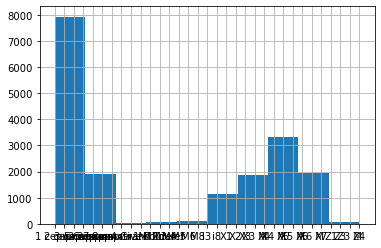

In [145]:
col_info(train.series)

In [ ]:
cars_name_for_search_model3 = train[['name', 'series', 'model_date_begin', 'body_type', 'engine_displacement', 'fuel_type', 'vehicle_transmission', 'engine_power', 'price']]
cars_name_for_search_model3.to_excel("cars_name_for_search_model3.xlsx",
             sheet_name='cars_name_for_search_model')  

cars_name_for_search_model3

In [ ]:
cars_name_for_search_model3_groupby_series = cars_name_for_search_model3.groupby(['series','name','model_date_begin','body_type','engine_displacement','fuel_type','engine_power']).agg({'price': 'sum'}).sort_values(by=['series'], ascending=False).reset_index()
cars_name_for_search_model3_groupby_series.to_excel("cars_name_for_search_model3_groupby_series.xlsx",
             sheet_name='model_groupby_series')  

cars_name_for_search_model3_groupby_series

In [118]:
dic_model = {
    '1 серия': '1ER',
    '1M': '1ER',
    '2ACTIVETOURER': '2ER',
    '2 серия': '2ER',
    '2 серия Grand Tourer': '2ER',
    '2 серия Active Tourer': '2ER',
    '2GRANDTOURER': '2ER',
    '3 серия': '3ER',
    '4': '4ER',
    '4 серия': '4ER',
    '5 серия': '5ER',
    '6 серия': '6ER',
    '7 серия': '7ER',
    '8 серия': '8ER',
    'i8': 'I8',
    'i3': 'I3',
    'M2': '2ER',
    'M3': '3ER',
    'M4': '4ER',
    'M5': '5ER',
    'M6': '6ER',
    'M8': '8ER',
    'X1': 'X1',
    'X2': 'X2',
    'X3': 'X3',
    'X3 M': 'X3',
    'X4': 'X4',
    'X4 M': 'X4',
    'X5': 'X5',
    'X5 M': 'X5',
    'X6': 'X6',
    'X6 M': 'X6',
    'X7': 'X7',
    'Z1': 'Z1',
    'Z3': 'Z3',
    'Z3 M': 'Z3',
    'Z4': 'Z4',
    'Z4 M': 'Z4',
    'Z8': 'Z8',
}

In [119]:
train['series'] = train['series'].map(dic_model)

Количество пропусков: 0
count     18417
unique       21
top         3ER
freq       3508
Name: series, dtype: object,
Распределение:
3ER    3508
5ER    3507
X5     3307
X6     1691
X3     1554
7ER    1456
X1     1007
1ER     781
6ER     441
X4      328
X7      250
2ER     214
M5       78
X2       75
8ER      62
I3       55
Z4       48
4ER      32
I8       12
Z3       10
Z1        1
Name: series, dtype: int64,


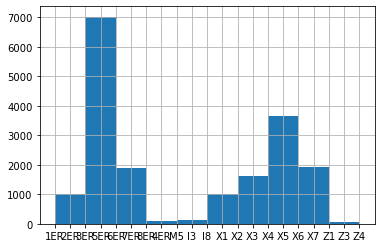

In [148]:
col_info(train.series)

### model_date_end

In [ ]:
col_info(train.model_date_end)

In [ ]:
train[['name', 'model_date_end']].groupby('name').agg({'model_date_end': 'value_counts'})

In [ ]:
a = train[['name', 'model_date_end']].groupby('name').agg({'model_date_end': 'value_counts'}).to_dict(orient='split')
print(type(a))
print(a)

Нет такого признака в тестовой выборке - придется удалить его и в трейне

In [120]:
train = train.drop(columns=['model_date_end'])

## color

Нашел в интернете функцию, которая заменяет hex на название цвета. То, что нужно в общем.

In [121]:
from skimage import color


def color_hex_replace(hex):


    peaked_color = '#' + f"{hex}"
    
#     print(peaked_color)

    # Initialize a dictionary where the key is the RGB value as hex string, and the value is the color name
    # https://en.wikipedia.org/wiki/List_of_colors:_A%E2%80%93F

    colors_dict = {
        "000000":"black",
        "C0C0C0":"silver",
        "808080":"grey",
        "FFFFFF":"white",
        "800000":"maroon",
        "FF0000":"red",
        "800080":"purple",
        "FF00FF":"fuchsia",
        "008000":"green",
        "006400":"darkgreen",
        "00FF00":"lime",
        "808000":"olive",
        "FFFF00":"yellow",
        "000080":"navy",
        "0000FF":"blue",
        "008080":"teal",
        "00FFFF":"aqua",
        "a52a2a":"brown",
        "f5f5dc":"beige",
        "ffd700":"gold",
        "ffa500":"orange",
        "0000cd":"mid_blue",
        "ee82ee":"violet"
    }
    
    
    # Get a list of color values in hex string format
    hex_rgb_colors = list(colors_dict.keys())

    # https://stackoverflow.com/questions/39908314/slice-all-strings-in-a-list, https://stackoverflow.com/questions/9210525/how-do-i-convert-hex-to-decimal-in-python
    r = [int(hex[0:2], 16) for hex in hex_rgb_colors]  # List of red elements.
    g = [int(hex[2:4], 16) for hex in hex_rgb_colors]  # List of green elements.
    b = [int(hex[4:6], 16) for hex in hex_rgb_colors]  # List of blue elements.

    r = np.asarray(r, np.uint8)  # Convert r from list to array (of uint8 elements)
    g = np.asarray(g, np.uint8)  # Convert g from list to array
    b = np.asarray(b, np.uint8)  # Convert b from list to array

    rgb = np.dstack((r, g, b)) #Stack r,g,b across third dimention - create to 3D array (of R,G,B elements).

    # Convert from sRGB color spave to LAB color space
    # https://stackoverflow.com/questions/13405956/convert-an-image-rgb-lab-with-python
    lab = color.rgb2lab(rgb)



    # Convert peaked color from sRGB color spave to LAB color space
    # peaked_color = '#673429ff'
    peaked_rgb = np.asarray([int(peaked_color[1:3], 16), int(peaked_color[3:5], 16), int(peaked_color[5:7], 16)], np.uint8)
    peaked_rgb = np.dstack((peaked_rgb[0], peaked_rgb[1], peaked_rgb[2]))
    peaked_lab = color.rgb2lab(peaked_rgb)

    # Compute Euclidean distance from peaked_lab to each element of lab
    lab_dist = ((lab[:,:,0] - peaked_lab[:,:,0])**2 + (lab[:,:,1] - peaked_lab[:,:,1])**2 + (lab[:,:,2] - peaked_lab[:,:,2])**2)**0.5

    # Get the index of the minimum distance
    min_index = lab_dist.argmin()

    # Get hex string of the color with the minimum Euclidean distance (minimum distance in LAB color space)
    peaked_closest_hex = hex_rgb_colors[min_index]

    # Get color name from the dictionary
    peaked_color_name = colors_dict[peaked_closest_hex]

    return peaked_color_name
        



Проверю функцию замены hex на название цвета

In [ ]:
color_hex_replace('ffffff')

In [122]:
train['color'] = train['color'].apply(color_hex_replace)

In [ ]:
col_info(train.color)

Ну и переведу для красоты и для единообразия в нижний регистр

In [123]:
train['color'] = train['color'].apply(lambda x: x.lower())

In [ ]:
train['color']

## body_type

Количество пропусков: 246
count       18171
unique         13
top       allroad
freq         8212
Name: body_type, dtype: object,
Распределение:
allroad                    8212
sedan                      7047
hatchback                   797
coupe                       693
sedan_long                  669
liftback_gran_turismo       344
station_wagon               173
cabriolet                   109
roadster                     49
hatchback_compact            43
compact_van_gran_tourer      17
compact_van                  12
coupe_hardtop                 6
Name: body_type, dtype: int64,


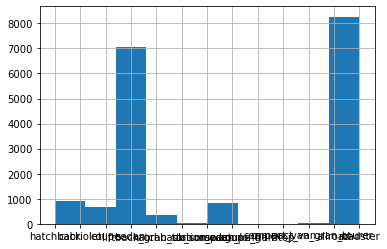

In [154]:
col_info(train.body_type)

In [124]:
# словарь для кодировки
dic_body_type = {
    'Внедорожник 5 дв.': 'allroad',
    'Кабриолет': 'cabriolet',
    'Компактвэн': 'compact_van',
    'Компактвэн Gran Tourer': 'compact_van_gran_tourer',
    'Купе': 'coupe',
    'Купе-хардтоп': 'coupe_hardtop',
    'Лифтбек': 'liftback',
    'Лифтбек Gran Turismo': 'liftback_gran_turismo',
    'Родстер': 'roadster',
    'Седан': 'sedan',
    'Седан 2 дв.': 'sedan',
    'Седан Long': 'sedan_long',
    'Универсал 5 дв.': 'station_wagon',
    'Хэтчбек 5 дв.': 'hatchback',
    'Хэтчбек 3 дв.': 'hatchback',
    'Хэтчбек 3 дв. Compact': 'hatchback_compact'
}

train['body_type'] = train['body_type'].map(dic_body_type)

Там есть пропуски. Их немного, поэтому мне видится проще их удалить, чем заполнять непонятно чем.

In [125]:
train = train.dropna()

## covid

In [126]:
train['covid'] = '1'

## price

In [ ]:
import seaborn as sns

sns.distplot(train.price.values)
np.median(train.price.values)

In [ ]:
col_info(train.price)

Переведу признак price в тип int

In [127]:
train['price'] = train['price'].astype(int)

С февраля курс доллара подрос с ~64 до ~70. Используем коэффициент 0.91 для устранения возможного смещения цены. Я так понимаю, что на реальном продакшне надо бы парсить каждый день (или по необходимости) изменения курса и вносить коррестировку в цену. Но с другой стороны сейчас мы предсказываем по тестовой выборке, которая была сформирована еще в феврале. А предсказываем по текущим ценам.

In [128]:
train['price'] = train['price'] * 0.91

In [ ]:
train.info()

In [ ]:
print('test:\n', test['technical_passport'].sample(10))
print('train:\n', train['technical_passport'].sample(10))

In [ ]:
display(train.sample(5))
display(test.sample(5))

Начну пробовать обучать модель и удалю признаки, которые не успел обработать

In [129]:
train.drop(['equipment'], axis=1, inplace=True,)
test.drop(['equipment'], axis=1, inplace=True,)

In [130]:
# Укажу, какую колонку нужно исключить из списка (в тесте нет колонки цены)
excluded_feats = ['price']

# Запоминаем порядок колонок
column_list = [f_ for f_ in train.columns if f_ not in excluded_feats]


# Устанавливаем порядок колонок как для трейновой выборки, иначе предсказания неверные.
test = test[column_list]

## Data Preprocessing

In [131]:
VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5

# RANDOM_SEED
RANDOM_SEED = 42

In [ ]:
X = train.drop(['price'], axis=1,)
y = train.price.values
X_sub = test.copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
X_train.info()

# CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Model Setup

In [ ]:
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 2000
LR         = 0.1

# RANDOM_SEED
RANDOM_SEED = 42

## Сat features
CatBoost умеет самостоятельно обрабатывать категориальные признаки, но для корректной обработки нужно их указать. Данные должны были или в int, или в string формате. Поэтому и отберу такие признаки:

In [ ]:
cat_features_ids = np.where(X_train.dtypes == object)[0].tolist()

In [ ]:
cat_features_ids

In [ ]:
categorical_features_names = ['body_type', 'color', 'fuel_type', 'name', 'vehicle_transmission', 'mileage', 'gear_type',
                              'steering_wheel',  'technical_passport', 'model_age', 'car_age']

## Fit

In [ ]:
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, y_train,
         cat_features=categorical_features_names,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

In [ ]:
model.save_model('catboost_single_model_baseline.model')

Посмотрим на распределение значимости признаков:

In [ ]:
from matplotlib import pyplot as plt

idx = np.argsort(model.feature_importances_)

plt.figure(figsize=(17,8))

sns.barplot(x=model.feature_importances_[idx], y=np.array(model.feature_names_)[idx])

# Submission

In [ ]:
predict_submission = model.predict(X_sub)
predict_submission

## Submission Setup

In [ ]:
VERSION = 20

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

В итоге получили **MAPE 13%** на ЛБ!

# Bonus
![](https://github.com/itLek/sfml/raw/7e34d290e81921bcaa9d52a2236ec9c43b928e35/HW_lesson_03/img/ml.png)
## CV
Перед тем как бежать перебирать признаки и модели, поговорим о кросс-валидации ([CV](https://ru.wikipedia.org/wiki/Перекрёстная_проверка))

Когда мы делаем отбор признаков или перебираем настройки модели, мы постоянно смотрим в тестовые данные (X_test), что может привести к подгону под тестовые данные. В итоге мы получим Переобучение (**overfitting**).     
Чтобы избежать этого, можно сразу использовать кросс-валидацию по фолдам (подробнее в модуле *Классический Machine Learning >Модуль 7. Валидация данных >7.2. Разбиение выборки*). 

Ниже представлен Пример, как можно организовать обучение модели на 5 фолдах, с дальнейшим объединением предсказаний от каждой модели.

In [ ]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,)
    model.fit(X_train, y_train,
              cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X_sub)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

### Submissions blend

In [ ]:
submissions.head(10)

In [ ]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = submissions['blend'].values
sample_submission.to_csv(f'submission_blend_v{VERSION}.csv', index=False)
sample_submission.head(10)

вот так, простое усреднее предсказаний по фолдам позволило улучшить нам результат на 1%!

# Stacking 
Давайте сначала разберемся, что-же такое этот Stacking. 
#### Начнем с Ансамбля моделей:     
Допустим, вы обучили Различные модели. Теперь мы можем просто объединить их предсказания и получить средневзвешенное предсказание по всем моделям. При этом, чем разнообразней модели - тем лучше результат мы получим. Смотри пример на картинке 
![](https://github.com/rasbt/mlxtend/raw/master/docs/sources/img/ensemble_decision_regions_2d.png)

#### А теперь Stacking:
У нас есть предсказания от разных моделей, почему бы не использовать их как новые признаки/фитчи и не **построить поверх этих предсказаний новую модель**? Это основная идея Stacking-a. 
![](https://miro.medium.com/max/1892/0*GHYCJIjkkrP5ZgPh.png)
Далее его еще можно бесконечно усложнять. Например, добавляя модели обученные на разных выборках и/или с разным составом признаков (bagging), или увеличивая уровни стекинга. В итоге мы можем получить что-то монструозное вроде этого:
![](https://blogs.sas.com/content/subconsciousmusings/files/2017/05/stackedapproach.png)

### Kaggle DarkSide
Большинство победных решений на kaggle сейчас идет со стекингом. И это большой минус kaggle, так как завести такого монстра, в продакшен, на реальный онлайн сервис, практически нереально (я уже молчу про интерпретируемость подобного решения). При этом сам стекинг обычно не играет ключевую роль, но он позволяет докинуть доли процента, которые в соревновании могут оказаться критичными.

<img src="http://www.quickmeme.com/img/c4/c4a179d0532ea1e02136d050ec961bd873597f7b70d561693cac4c161d06b26a.jpg">

* > Перед тем как отправляться "во все тяжкие" со Стекингом, рекомендую побольше поработать с Feature Engineering-ом.
* > При Stacking-e Очень важно изначально продумать и выстроить четкие правила CV, чтоб не допустить утечки данных при обучении.   
На крайний случай, можно воспользоваться готовыми пакетами с уже корректно реализованным Stacking-ом: [vecstack](https://github.com/vecxoz/vecstack), [mlxtend](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/),  [H2O](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html)

# Stacking

## Как каждая модель относится к категориальным переменным?

CatBoost обладает гибкостью, позволяя задавать индексы категориальных столбцов, чтобы его можно было кодировать как кодирование в одно касание с использованием one_hot_max_size (используйте кодирование в одно касание для всех функций с числом различных значений, меньшим или равным данному значению параметра).

Если вы ничего не передаете в аргументе cat_features, CatBoost будет обрабатывать все столбцы как числовые переменные.

Примечание. Если в cat_features не указан столбец со строковыми значениями, CatBoost выдает ошибку. Кроме того, столбец с типом int по умолчанию будет считаться числовым по умолчанию, его необходимо указать в cat_features, чтобы алгоритм воспринимал его как категориальный.

Как и в CatBoost, LightGBM также может обрабатывать категориальные функции, вводя имена функций. Он не конвертируется в одноразовое кодирование и намного быстрее, чем одноразовое кодирование. LGBM использует специальный алгоритм, чтобы найти значение разделения категориальных признаков.

Примечание. Перед построением набора данных для LGBM вы должны преобразовать свои категориальные функции в тип int. Он не принимает строковые значения, даже если вы передаете его через параметр categoryorical_feature.

В отличие от CatBoost или LGBM, XGBoost не может обрабатывать категориальные функции сам по себе, он принимает только числовые значения, подобные случайному лесу. Поэтому перед подачей категориальных данных в XGBoost необходимо выполнить различные кодировки, такие как кодирование меток, среднее кодирование или однократное кодирование.

RandomForestRegressor, LinearRegression - им тоже нужны на вход данные без категориальных признаков

## Подготовка

Отсюда вытекает стратегия - необходимо объединить два датасета (трейновый и тестовый), предварительно добавив в тестовый колонку "Цена" с нулевыми значениями (после перед подаче в модель я это удалю; а для того, чтобы отделить трейн от теста добавлю общую колонку. Ну и дальше смогу сделать one-hot-encoding кодирование.

Работать буду на копии оригинальных данных, чтобы можно было в любое время к ним вернуться.

In [132]:
new_train = train.copy()
new_test = test.copy()

In [133]:
new_test['price'] = 0

Сделаю хак - заточу данные строго под те автомобили, которые есть на тестовой. Да, это переобучением пахнет, но просто интересно пробить 9 баллов.

Количество пропусков: 0
count     3837
unique     172
top        30d
freq       255
Name: name, dtype: object,
Распределение:
30d             255
35i             194
320i            171
520i            142
20d             134
               ... 
118d              1
528Li xDrive      1
M40d              1
430i              1
428i              1
Name: name, Length: 172, dtype: int64,


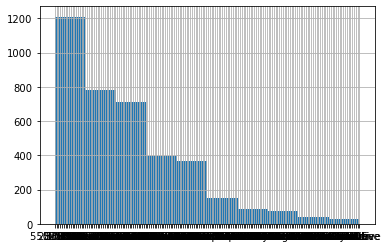

In [218]:
col_info(new_test.name)

In [139]:
len(new_test.name.tolist())

3837

In [138]:
test_car_name_list = new_test.name.tolist()
test_car_name_list = set(test_car_name_list)
len(test_car_name_list)

172

In [140]:
new_train = new_train.query('name == @test_car_name_list')

In [141]:
new_test

,body_type,color,fuel_type,model_date_begin,name,series,number_of_doors,production_date,vehicle_transmission,engine_displacement,...,isofix,tyre-pressure,air-suspension,decorative-interior-lighting,360-camera,wireless-charger,electronic-gage-panel,model_age,covid,price
0,sedan,black,diesel,2016,520d,5ER,4,2017,AT,2.0,...,0,1,0,0,0,0,0,4,0,0
1,sedan,white,diesel,2018,318d,3ER,4,2019,AT,2.0,...,0,1,0,1,0,0,0,2,0,0
2,sedan,blue,gasoline,2009,550i xDrive,5ER,4,2012,AT,4.4,...,0,1,0,0,0,1,1,11,0,0
3,allroad,white,diesel,2014,30d,X6,5,2015,AT,3.0,...,0,1,0,0,0,0,0,6,0,0
4,allroad,blue,diesel,2014,M50d,X6,5,2019,AT,3.0,...,0,0,0,0,1,0,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3832,sedan,black,gasoline,2013,520i,5ER,4,2013,AT,2.0,...,0,1,0,0,0,0,0,7,0,0
3833,allroad,black,diesel,2013,30d,X5,5,2016,AT,3.0,...,0,0,0,0,0,0,0,7,0,0
3834,sedan,black,gasoline,2002,525xi,5ER,4,2006,AT,2.5,...,0,1,0,0,0,0,1,18,0,0
3835,sedan,brown,gasoline,2009,528i xDrive,5ER,4,2012,AT,2.0,...,0,1,0,0,0,0,0,11,0,0


In [266]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17959 entries, 0 to 18415
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   body_type                     17959 non-null  object 
 1   color                         17959 non-null  object 
 2   fuel_type                     17959 non-null  object 
 3   model_date_begin              17959 non-null  int64  
 4   name                          17959 non-null  object 
 5   series                        17959 non-null  object 
 6   number_of_doors               17959 non-null  int64  
 7   production_date               17959 non-null  int64  
 8   vehicle_transmission          17959 non-null  object 
 9   engine_displacement           17959 non-null  float64
 10  engine_power                  17959 non-null  int64  
 11  mileage                       17959 non-null  object 
 12  gear_type                     17959 non-null  object 
 13  s

Почищу цены от выбросов

nan nan nan
<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   body_type                     0 non-null      object 
 1   color                         0 non-null      object 
 2   fuel_type                     0 non-null      object 
 3   model_date_begin              0 non-null      int64  
 4   name                          0 non-null      object 
 5   series                        0 non-null      object 
 6   number_of_doors               0 non-null      int64  
 7   production_date               0 non-null      int64  
 8   vehicle_transmission          0 non-null      object 
 9   engine_displacement           0 non-null      float64
 10  engine_power                  0 non-null      int64  
 11  mileage                       0 non-null      object 
 12  gear_type                     0 non-null      object 
 13  steer

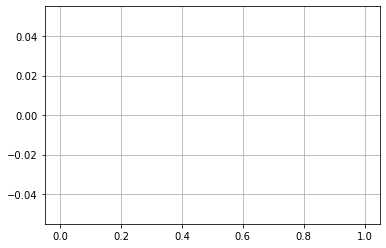

In [142]:
delete_outliers_iqr(new_train, 'price')

In [143]:
new_test['dataset'] = 'test'
new_train['dataset'] = 'train'

In [144]:
# Запоминаем порядок колонок
column_list = [f_ for f_ in new_test.columns]


# Устанавливаем порядок колонок как для трейновой выборки, иначе предсказания неверные.
new_train = new_train[column_list]

Объединяю датасеты

In [145]:
new_big_df = pd.concat([new_train, new_test], ignore_index=True)

Экспортну в csv, чтобы каждый раз не проделывать операцию по формированию рабочего датасета.

In [ ]:
new_big_df

In [191]:
cat_features_ids = np.where(new_big_df.dtypes == float)[0].tolist()

cat_features_ids

[9, 60]

In [ ]:
new_big_df.info()

In [ ]:
new_big_df.iloc[:,[9, 60]]



Умножу теперь engine_displacement на 1000, чтобы перевести это к int и сохранить при этом логику объема двигателя

In [ ]:
col_info(new_big_df.mileage_per_year)

In [146]:
new_big_df['engine_displacement'] = (new_big_df['engine_displacement'] * 1000).astype('int')

In [213]:
new_big_df['engine_displacement']

0        3000
1        2000
2        2000
3        1600
4        1600
         ... 
21791    2000
21792    3000
21793    2500
21794    2000
21795    4400
Name: engine_displacement, Length: 21796, dtype: int64

А price просто переведу в int

In [147]:
new_big_df['price'] = new_big_df['price'].astype(int)

Еще обнаружили такую штуку как транспортный налог. Особенно интересно то, что на дорогие автомобили есть повышающий налог. Налог завязан на регионе - то есть каждому региону позволено изменять базовую стоимость, по которой считается весь налог. Но хорошо то, что почти во всех регионах (включая такие аномальные как Москва) стоит максимальная ставка - 150. Только в некоторых регионах есть снижение, но эти регионы дальние. Правда Крым тоже входит в регион, где ставка снижена. Но да ладно, для первого приближение возьмем базовую ставку за 1 и дальше умножим на объем двигателя и на коэфф. на роскошь.

Введем список автомобилей, которые попадают под роскошь (информация взята с оф. сайта https://nalog-nalog.ru/files/editor/0320/02/perechen_avtomobil_compressed%202020.pdf)

In [148]:
new_big_df['model_age'] = new_big_df['model_age'].astype(int)

In [ ]:
new_big_df['model_age']

In [ ]:
new_big_df['engine_displacement']

In [149]:
def luxury_tax(df):
    conditions = [
        ((df['name'] == 'M240i xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))  # 1.1
        | ((df['name'] == 'M235i xDrive') & (df['model_age'] == 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000) & (df['body_type'] <= 'coupe'))
        | ((df['name'] == '330d xDrive') & (df['model_age'] == 2) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == 'M340i xDrive') & (df['model_age'] == 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '340i xDrive') & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '330i xDrive') & (df['model_age'] == 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '340i xDrive') & (df['model_age'] > 1) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000) & (df['body_type'] <= 'liftback_gran_turismo'))
        | ((df['name'] == '430i') & (df['model_age'] == 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000) & (df['body_type'] <= 'coupe'))
        | ((df['name'] == '430i xDrive') & (df['model_age'] > 1) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000) & (df['body_type'] <= 'cabriolet'))
        | ((df['name'] == '430i') & (df['model_age'] > 1) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000) & (df['body_type'] <= 'cabriolet'))
        | ((df['name'] == '420d') & (df['model_age'] <= 2) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 2000) & (df['body_type'] <= 'cabriolet'))
        | ((df['name'] == '430i xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000) & (df['body_type'] <= 'coupe'))
        | ((df['name'] == '440i xDrive') & (df['model_age'] > 1) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000) & (df['body_type'] <= 'coupe'))
        | ((df['name'] == '440i') & (df['model_age'] > 1) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000) & (df['body_type'] <= 'cabriolet'))
        | ((df['name'] == '520i') & (df['model_age'] == 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '520d') & (df['model_age'] == 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '520d xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '530d xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '530i') & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '530i xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '540i xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '630d xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '630i') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '640d xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '640i xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '730i') & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline'))
        | ((df['name'] == 'M2') & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M2 Competition') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M550d xDrive') & (df['model_age'] > 1) & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M550i xDrive') & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500))
        | ((df['name'] == 'M40i') & (df['series'] <= 'X3') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M40d') & (df['series'] <= 'X3') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '20d xDrive') & (df['series'] <= 'X3') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '20i xDrive') & (df['series'] <= 'X3') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '30i xDrive') & (df['series'] <= 'X3') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '30d xDrive') & (df['series'] <= 'X3') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M40i') & (df['series'] <= 'X4') & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M40d') & (df['series'] <= 'X4') & (df['model_age'] <= 2) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '20i xDrive') & (df['series'] <= 'X4') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '20d xDrive') & (df['series'] <= 'X4') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '20i xDrive M Sport') & (df['series'] <= 'X4') & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '28i xDrive') & (df['series'] <= 'X4') & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '30i xDrive') & (df['series'] <= 'X4') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '30d xDrive') & (df['series'] <= 'X4') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '35d xDrive') & (df['series'] <= 'X4') & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '35i xDrive') & (df['series'] <= 'X4') & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '25d xDrive Business') & (df['series'] <= 'X5') & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '30d xDrive') & (df['series'] <= 'X5') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '35i xDrive') & (df['series'] <= 'X5') & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '40i xDrive') & (df['series'] <= 'X5') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '40d xDrive') & (df['series'] <= 'X5') & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '40e xDrive') & (df['series'] <= 'X5') & (df['model_age'] <= 3) & (df['fuel_type'] == 'hybrid'))
        | ((df['name'] == '50i xDrive') & (df['series'] <= 'X5') & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500))
        | ((df['name'] == '30d xDrive') & (df['series'] <= 'X6') & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '20i sDrive') & (df['series'] <= 'Z4') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '30i sDrive') & (df['series'] <= 'Z4') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == 'M40i') & (df['series'] <= 'Z4') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M4') & (df['model_age'] > 1) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000) & (df['body_type'] == 'coupe'))
        | ((df['name'] == '120Ah') & (df['model_age'] > 0) & (df['model_age'] <= 1) & (df['fuel_type'] == 'electro'))
        | ((df['name'] == '620d xDrive') & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 2000)),
        ((df['name'] == 'М4') & (df['model_age'] <= 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))  # 2
        | ((df['name'] == 'М') & (df['series'] <= 'X3') & (df['model_age'] <= 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M40d') & (df['series'] <= 'X4') & (df['model_age'] <= 1) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M40i') & (df['series'] <= 'X4') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M') & (df['series'] <= 'X4') & (df['model_age'] <= 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '640i xDrive') & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000) & (df['body_type'] == 'cabriolet'))
        | ((df['name'] == '640i') & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000) & (df['body_type'] == 'cabriolet'))
        | ((df['name'] == '650i xDrive') & (df['model_age'] > 2) & (df['model_age'] <= 5) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500) & (df['body_type'] == 'coupe'))
        | ((df['name'] == '650i xDrive') & (df['model_age'] > 2) & (df['model_age'] <= 5) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500) & (df['body_type'] == 'cabriolet'))
        | ((df['name'] == '650i xDrive') & (df['model_age'] > 2) & (df['model_age'] <= 5) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500) & (df['body_type'] == 'coupe'))
        | ((df['name'] == '650i') & (df['model_age'] > 2) & (df['model_age'] <= 5) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500) & (df['body_type'] == 'cabriolet'))
        | ((df['name'] == '730i') & (df['model_age'] <= 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '730d xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 5) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '730Ld xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 5) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '740d xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 5) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '740Ld xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 5) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '740Le xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 4) & (df['fuel_type'] == 'hybrid') & (df['engine_displacement'] <= 2000))
        | ((df['name'] == '740Li xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 4) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '750d xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 4) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '750i xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 5) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500))
        | ((df['name'] == '750Ld xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 4) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '750Li xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 5) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500))
        | ((df['name'] == 'M550d xDrive') & (df['model_age'] <= 1) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M550i xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500))
        | ((df['name'] == 'M5') & (df['model_age'] > 2) & (df['model_age'] <= 5) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500) & (df['body_type'] == 'sedan'))
        | ((df['name'] == 'M5 Competition') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500))
        | ((df['name'] == 'M6') & (df['model_age'] > 3) & (df['model_age'] <= 5) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500) & (df['body_type'] == 'coupe'))
        | ((df['name'] == 'M6') & (df['model_age'] <= 4) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500) & (df['body_type'] == 'cabriolet'))
        | ((df['name'] == 'M6') & (df['model_age'] > 2) & (df['model_age'] <= 5) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500) & (df['body_type'] == 'coupe'))
        | ((df['name'] == 'M760Li xDrive') & (df['model_age'] <= 4) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 7000))
        | ((df['name'] == '50i xDrive') & (df['series'] <= 'X5') & (df['model_age'] == 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500))
        | ((df['name'] == 'M') & (df['series'] <= 'X5') & (df['model_age'] > 0) & (df['model_age'] <= 5) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500))
        | ((df['name'] == 'M50i') & (df['series'] <= 'X5') & (df['model_age'] <= 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500))
        | ((df['name'] == 'M50d') & (df['series'] <= 'X5') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M50d xDrive') & (df['series'] <= 'X5') & (df['model_age'] <= 4) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '30d xDrive Exclusive') & (df['series'] <= 'X5') & (df['model_age'] <= 4) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '30d xDrive Pure Experience') & (df['series'] <= 'X5') & (df['model_age'] <= 4) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '40d xDrive M Sport') & (df['series'] <= 'X5') & (df['model_age'] > 3) & (df['model_age'] <= 5) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '35i xDrive') & (df['series'] <= 'X6') & (df['model_age'] == 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '40i xDrive') & (df['series'] <= 'X6') & (df['model_age'] <= 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '30d xDrive') & (df['series'] <= 'X6') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M') & (df['series'] <= 'X6') & (df['model_age'] > 0) & (df['model_age'] <= 5) & (df['engine_displacement'] <= 4500))
        | ((df['name'] == 'M50i') & (df['series'] <= 'X6') & (df['model_age'] <= 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500))
        | ((df['name'] == 'M50d') & (df['series'] <= 'X6') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M50d xDrive') & (df['series'] <= 'X6') & (df['model_age'] <= 4) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '30d xDrive Luxury') & (df['series'] <= 'X6') & (df['model_age'] <= 4) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '30d xDrive M Sport') & (df['series'] <= 'X6') & (df['model_age'] <= 4) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '30d xDrive Pure Extravagance') & (df['series'] <= 'X6') & (df['model_age'] <= 4) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '40d xDrive') & (df['series'] <= 'X6') & (df['model_age'] > 1) & (df['model_age'] <= 3) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '40d xDrive M Sport') & (df['series'] <= 'X6') & (df['model_age'] <= 4) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '50i xDrive') & (df['series'] <= 'X6') & (df['model_age'] > 1) & (df['model_age'] <= 4) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500))
        | ((df['name'] == '30d xDrive') & (df['series'] <= 'X7') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '40i xDrive') & (df['series'] <= 'X7') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == 'M50d') & (df['series'] <= 'X7') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000))
        | ((df['name'] == '840i xDrive') & (df['model_age'] == 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000) & (df['body_type'] == 'cabriolet'))
        | ((df['name'] == '840i xDrive') & (df['model_age'] == 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000) & (df['body_type'] == 'coupe'))
        | ((df['name'] == '840d xDrive') & (df['model_age'] == 1) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000) & (df['body_type'] == 'coupe'))
        | ((df['name'] == '840d xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'diesel') & (df['engine_displacement'] <= 3000) & (df['body_type'] == 'coupe'))
        | ((df['name'] == '840i xDrive') & (df['model_age'] == 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 3000) & (df['body_type'] == 'coupe'))
        | ((df['name'] == 'M850i xDrive') & (df['model_age'] == 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500) & (df['body_type'] == 'coupe'))
        | ((df['name'] == 'M850i xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500) & (df['body_type'] == 'coupe'))
        | ((df['name'] == 'M850i xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500) & (df['body_type'] == 'cabriolet'))
        | ((df['name'] == 'i8') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'hybrid') & (df['engine_displacement'] <= 1500) & (df['body_type'] == 'coupe')),
        ((df['name'] == 'M8') & (df['model_age'] == 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500) & (df['body_type'] == 'coupe'))  # 3
        | ((df['name'] == 'M8') & (df['model_age'] == 1) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 4500) & (df['body_type'] == 'cabriolet'))
        | ((df['name'] == 'i8') & (df['model_age'] > 2) & (df['model_age'] <= 4) & (df['fuel_type'] == 'hybrid') & (df['engine_displacement'] <= 1500))
        | ((df['name'] == 'i8') & (df['model_age'] > 0) & (df['model_age'] <= 2) & (df['fuel_type'] == 'hybrid') & (df['engine_displacement'] <= 1500) & (df['body_type'] == 'roadster'))
        | ((df['name'] == 'M760Li xDrive') & (df['model_age'] > 0) & (df['model_age'] <= 3) & (df['fuel_type'] == 'gasoline') & (df['engine_displacement'] <= 6600) & (df['body_type'] == 'roadster')),
    ]
    choices = [1.1,2,3]
    df['luxury_tax'] = np.select(conditions, choices, default=1)
    return df['luxury_tax']

Данные в функции крайне не удобно читаются. Чуть позже займусь рефакторингом.

In [150]:
new_big_df['luxury_tax'] = luxury_tax(new_big_df)

In [ ]:
col_info(new_big_df.luxury_tax)

Транспортный налог зависит от лошадиных сил, и правительство позволяет каждому региону устанавливать свою стоимость налога на 1 лошадиную силу в рублях, но в пределах некоторого лимита. К сожалению, в тестовом у нас нет региона, в котором продается или находится автомобиль. Поэтому пришлось взять 30 самых густонаселенных региона страны (по идее вероятность, что автомобиль оттуда, будет выше), усреднить налог (там не было выбросов, поэтому можно взять среднюю) и посчитать сумму налога. https://www.autonews.ru/news/5e2152979a7947248028cd50

In [151]:
def make_car_tax(row):
    if row.engine_power <= 100:
            row.car_tax = row.engine_power * row.luxury_tax * 12
            return row.car_tax
        
    elif 100 < row.engine_power <= 125:
        row.car_tax = row.engine_power * row.luxury_tax * 20
        return row.car_tax
    
    elif 125 < row.engine_power <= 150:
        row.car_tax = row.engine_power * row.luxury_tax * 24
        return row.car_tax
    
    elif 150 < row.engine_power <= 175:
        row.car_tax = row.engine_power * row.luxury_tax * 42
        return row.car_tax
    
    elif 175 < row.engine_power <= 200:
        row.car_tax = row.engine_power * row.luxury_tax * 43
        return row.car_tax

    elif 200 < row.engine_power <= 225:
        row.car_tax = row.engine_power * row.luxury_tax * 58
        return row.car_tax
    
    elif 225 < row.engine_power <= 250:
        row.car_tax = row.engine_power * row.luxury_tax * 68
        return row.car_tax
    
    elif row.engine_power > 250:
        row.car_tax = row.engine_power * row.luxury_tax * 132
        return row.car_tax
  
 
new_big_df['car_tax'] = new_big_df.apply(lambda row: make_car_tax(row), axis=1)

In [152]:
new_big_df['model_age'] = new_big_df['model_age'].astype('str')
new_big_df['car_tax'] = new_big_df['car_tax'].astype(int)
new_big_df['luxury_tax'] = new_big_df['luxury_tax'].astype('str')

In [ ]:
col_info(new_big_df.car_tax)

Качну себе датасет, чтобы поработать с ним отдельно с помощью других ансамблей в другом файле.

Попробую добавить новую колонку - количество дополнительного оборудования, установленного в автомобиле.  P.S. Немного, но на 0.01 это улучшило результат.

In [153]:
equipments_list = [
    'high-beam-assist',
    'front-seats-heat-vent',
    'bluetooth',
    'laser-lights',
    'light-sensor',
    'adaptive-light',
    'apple-carplay',
    'electro-trunk',
    'third-row-seats',
    'keyless-entry',
    'activ-suspension',
    'multizone-climate-control',
    'body-kit',
    'projection-display',
    'start-stop-function',
    'start-button',
    'paint-metallic',
    'wheel-heat',
    'passenger-seat-electric',
    'rain-sensor',
    'navigation',
    'voice-recognition',
    'multi-wheel',
    'airbag-curtain',
    'glonass',
    'auto-mirrors',
    'usb',
    'power-latching-doors',
    'led-lights',
    'auto-park',
    'bas',
    'isofix',
    'tyre-pressure',
    'air-suspension',
    'decorative-interior-lighting',
    '360-camera',
    'wireless-charger',
    'electronic-gage-panel']

In [154]:
new_big_df['equipments_count'] = new_big_df[equipments_list].sum(axis=1).astype('int')

Вспомнил, что вроде бы в not_damage только один параметр - все автомобили по всей выборке (обучающая и тестовая) без повреждений. Проверю. И если это так, то удалю этот признак.

In [ ]:
col_info(new_big_df.not_damage)

In [155]:
new_big_df.drop(['not_damage'], axis=1, inplace=True,)

Буду создавать признаки с помощью комбинаторики категориальных признаков

Итак, теперь буду пробовать создать новые признаки на основании уже созданных путем объединения 2, 3 признаков. На Каггле это приводило к результатам.

In [234]:
# #encoders for categorical data
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# import category_encoders as ce

# from itertools import combinations

# object_cols = new_big_df.select_dtypes('object').columns
# low_cardinality_cols = [col for col in object_cols if new_big_df[col].nunique() < 15]
# # low_cardinality_cols.append('price')
# interactions = pd.DataFrame(index=new_big_df.index)

# # Генерирую комбинации фичей
# for features in combinations(low_cardinality_cols,2):
    
#     new_interaction = new_big_df[features[0]].map(str)+"_"+new_big_df[features[1]].map(str)
    
#     encoder = LabelEncoder()
#     interactions["_".join(features)] = encoder.fit_transform(new_interaction)

In [ ]:
# low_cardinality_cols

In [ ]:
# interactions

In [235]:
# new_big_df = new_big_df.join(interactions) #добавлю теперь новые колонки в датасет

In [141]:
new_big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21796 entries, 0 to 21795
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   body_type                     21796 non-null  object
 1   color                         21796 non-null  object
 2   fuel_type                     21796 non-null  object
 3   model_date_begin              21796 non-null  int64 
 4   name                          21796 non-null  object
 5   series                        21796 non-null  object
 6   number_of_doors               21796 non-null  int64 
 7   production_date               21796 non-null  int64 
 8   vehicle_transmission          21796 non-null  object
 9   engine_displacement           21796 non-null  int64 
 10  engine_power                  21796 non-null  int64 
 11  mileage                       21796 non-null  object
 12  gear_type                     21796 non-null  object
 13  steering_wheel  

In [200]:
new_big_df.to_csv('new_big_df.csv')  

Собрал новые признаки для BMW отсюда: https://www.drom.ru/catalog/bmw/ и http://www.drivernotes.net/tehnicheskie_harakteristiki/bmw . Парсер лежит в git. Работа можно сказать, что проделана зря - крайне сложно собрать данные на внешних сайтах (или нужно потрать много времени), чтобы соединить по названиям, году производства модели, серии, объему двигателя и трансмиссии новы признаки. Потратил 3 дня. Спарсил несколько сайтов - склеить не удалось.

Теперь что я хочу сделать - есть ТОП-10 БМВ по надежности. Делаю предположение, что это модели лучше продаются и на них цена меньше колебается и держится. Хочу ввести такой параметр - надежность.

In [302]:
# def make_car_quality(row):
#     if row.series == '3ER' and 1997 <= row.model_date_begin < 2006:
#         row.quality = '1'
#         return row.quality
        
#     elif row.name == '116i' or row.name == '116' or row.name == '116d':
#         row.quality = '1'
#         return row.quality
    
#     elif row.series == 'X5':
#         row.quality = '1'
#         return row.quality
    
#     elif row.series == '3ER' and 2005 < row.model_date_begin <= 2013:
#         row.quality = '1'
#         return row.quality
    
#     elif row.series == '5ER' and 2003 <= row.model_date_begin <= 2009:
#         row.quality = '1'
#         return row.quality
    
#     else:
#         row.quality = '0'
#         return row.quality
  
 
# new_big_df['quality'] = new_big_df.apply(lambda row: make_car_quality(row), axis=1)

Количество пропусков: 0
count     21796
unique        2
top           0
freq      13955
Name: quality, dtype: object,
Распределение:
0    13955
1     7841
Name: quality, dtype: int64,


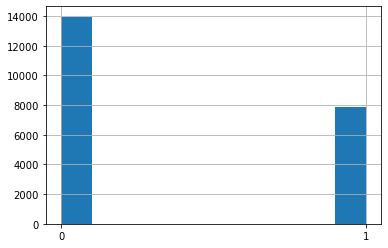

In [143]:
# col_info(new_big_df.quality)

Добавлю признак "популярный на рынке России"

In [303]:
# def make_car_popular(row):
#     if row.series == '3ER' and row.series == 'sedan':
#         row.popularity = '1'
#         return row.popularity
    
#     elif row.series == '5ER' and row.series == 'sedan':
#         row.popularity = '1'
#         return row.popularity
        
#     elif row.series == 'X5' or row.series == 'X6' or row.series == 'X3':
#         row.popularity = '1'
#         return row.popularity
    
#     else:
#         row.popularity = '0'
#         return row.popularity
  
 
# new_big_df['popularity'] = new_big_df.apply(lambda row: make_car_popular(row), axis=1)

Добавлю еще рейтинг марки

In [304]:
# def make_car_rating(row):
#     if row.series == '6ER':
#         row.rating = 9.3
#         return row.rating
    
#     elif row.series == 'X6':
#         row.rating = 9.2
#         return row.rating
    
#     elif row.series == 'X5':
#         row.rating = 9.1
#         return row.rating
    
#     elif row.series == 'X3':
#         row.rating = 9.0
#         return row.rating
    
#     elif row.series == '7ER':
#         row.rating = 9.0
#         return row.rating
    
#     elif row.series == 'Z4':
#         row.rating = 8.9
#         return row.rating
    
#     elif row.series == '5ER':
#         row.rating = 8.8
#         return row.rating
    
#     elif row.series == '1ER':
#         row.rating = 8.8
#         return row.rating
    
#     elif row.series == 'X4':
#         row.rating = 8.7
#         return row.rating
    
#     elif row.series == 'X1':
#         row.rating = 8.7
#         return row.rating
    
#     elif row.series == '3ER':
#         row.rating = 8.7
#         return row.rating
    
#     else:
#         row.rating = '0'
#         return row.rating
  
 
# new_big_df['rating'] = new_big_df.apply(lambda row: make_car_rating(row), axis=1)
# new_big_df['rating'] = new_big_df['rating'].astype('float')

Количество пропусков: 0
count    21796.000000
mean         8.611231
std          1.610057
min          0.000000
25%          8.700000
50%          8.800000
75%          9.100000
max          9.300000
Name: rating, dtype: float64,
Распределение:
8.7    5924
8.8    5333
9.1    3850
9.0    3475
9.2    1971
0.0     727
9.3     464
8.9      52
Name: rating, dtype: int64,


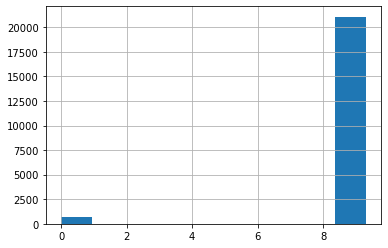

In [183]:
# col_info(new_big_df.rating)

Хочу удалить признак series, так как во многом его задачу решают косвенно другие признаки

In [158]:
new_big_df = new_big_df.drop('series', axis=1)

Удалю признак model_date_begin - у него высокая корреляция с production_date

In [159]:
new_big_df = new_big_df.drop('model_date_begin', axis=1)

In [160]:
new_big_df.drop(['covid'], axis=1, inplace=True,)

KeyError: "['covid'] not found in axis"

In [209]:
new_big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21796 entries, 0 to 21795
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   body_type                     21796 non-null  object
 1   color                         21796 non-null  object
 2   fuel_type                     21796 non-null  object
 3   name                          21796 non-null  object
 4   number_of_doors               21796 non-null  int64 
 5   production_date               21796 non-null  int64 
 6   vehicle_transmission          21796 non-null  object
 7   engine_displacement           21796 non-null  int64 
 8   engine_power                  21796 non-null  int64 
 9   mileage                       21796 non-null  object
 10  gear_type                     21796 non-null  object
 11  steering_wheel                21796 non-null  object
 12  owners                        21796 non-null  int64 
 13  technical_passpo

Упрощу в общем название автомобилей - уберу из модели i и d. По идее это сгруппирует автомобили более явно, будет меньше список, а тип топлива и так у нас разделяет автомобили.

In [161]:
new_big_df['name'] = new_big_df.name.apply(lambda x: x.replace('i', '').replace('d', ''))

In [210]:
new_big_df.sample(15)

,body_type,color,fuel_type,name,number_of_doors,production_date,vehicle_transmission,engine_displacement,engine_power,mileage,...,decorative-interior-lighting,360-camera,wireless-charger,electronic-gage-panel,model_age,price,dataset,luxury_tax,car_tax,equipments_count
11841,allroad,black,diesel,20 xDrve,5,2016,AT,2000,190,4,...,0,0,0,0,6,1917370,train,1.0,8170,0
20083,allroad,white,gasoline,20 xDrve,5,2018,AT,2000,184,1,...,1,0,0,0,3,0,test,1.1,8703,18
15934,allroad,mid_blue,gasoline,4.4,5,2010,AT,4400,555,4,...,0,0,0,0,11,1324050,train,1.0,73260,9
5126,sedan,black,gasoline,520,4,2014,AT,2000,184,3,...,0,0,0,0,7,1182090,train,1.0,7912,12
15321,allroad,white,diesel,30,5,2014,AT,3000,249,5,...,0,0,0,0,7,2320500,train,1.0,16932,0
4732,sedan,grey,gasoline,523,4,2010,AT,2500,204,8,...,0,0,0,0,11,755300,train,1.0,11832,2
10859,allroad,mid_blue,diesel,20 xDrve,5,2020,AT,2000,190,1,...,0,0,0,0,3,3477728,train,1.1,8987,20
9731,allroad,orange,diesel,18 xDrve,5,2018,AT,2000,150,1,...,0,0,0,0,5,1864590,train,1.0,3600,15
329,hatchback,black,gasoline,116,5,2010,AT,1600,115,5,...,0,0,0,0,13,382200,train,1.0,2300,6
15595,allroad,silver,gasoline,3.0,5,2004,AT,3000,231,12,...,1,0,0,0,17,568750,train,1.0,15708,14


In [211]:
cat_features_ids = np.where(new_big_df.dtypes == object)[0].tolist()

cat_features_ids

[0, 1, 2, 3, 6, 9, 10, 11, 13, 14, 15, 55, 57, 58]

In [212]:
categorical_features_names = ['body_type', 'color', 'fuel_type', 'name', 'vehicle_transmission', 'mileage', 'gear_type',
                              'steering_wheel',  'technical_passport', 'car_age', 'mileage_per_year', 'model_age', 'luxury_tax']

In [215]:
new_big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21796 entries, 0 to 21795
Columns: 280 entries, number_of_doors to luxury_tax_2.0
dtypes: int64(47), object(1), uint8(232)
memory usage: 12.8+ MB


Сделаю теперь dummies-преобразование

In [214]:
for column in categorical_features_names:
    dummies_train = pd.get_dummies(new_big_df[column], prefix = new_big_df[column].name)

    # Удаляем исходный столбец и добавляем dummies
    new_big_df = new_big_df.drop(new_big_df[column].name, axis=1).join(dummies_train)


In [134]:
new_big_df.to_csv('new_big_df.csv', index=False)  

In [513]:
new_big_df['price']

0       2
1       3
2       1
3       2
4       1
       ..
5663    0
5664    0
5665    0
5666    0
5667    0
Name: price, Length: 5668, dtype: int64

Теперь порядок. Можем переходить к формированию обучающих выборок и работе с моделями.

In [216]:
VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 2000
LR         = 0.1

# RANDOM_SEED
RANDOM_SEED = 42

Теперь выделим тестовую и обучающие части

In [181]:
dataset_train = 'train'
dataset_test = 'test'

train_preproc = new_big_df.query('@dataset_train in dataset').drop(['dataset'], axis=1)
X_sub = new_big_df.query('@dataset_test in dataset').drop(['dataset', 'price'], axis=1)


# # Запоминаем порядок колонок
column_list = X_sub.columns

X = train_preproc.drop(['price'], axis=1,)

# # Устанавливаем порядок колонок как для тестовой выборки, иначе предсказания неверные.
X = X[column_list]

y = train_preproc.price.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## Stacking Var.1. Дало лучший результат в лидерборде, чем Var.2 ниже, но хуже, чем Var 3. Поэтому и последующем буду пользоваться Var 3

In [149]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
   
    X_meta_train = np.zeros_like(y_train, dtype = np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_model = clone(model)
        folded_model.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)
        
    meta_model = clone(model)
    meta_model.fit(X_train, y_train)
    
    X_meta_test = meta_model.predict_proba(X_test)[:,1]
    
    return X_meta_train, X_meta_test

In [150]:
cv = KFold(n_splits=N_FOLDS, shuffle=True)

In [151]:
# 1 - Catboost

cat_features_ids = np.where(X.dtypes == object)[0].tolist()

X_meta_train_features = []
X_meta_test_features = []

model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          loss_function = 'RMSE'
                         )

X_meta_train = np.zeros_like(y, dtype = np.float32)
X_meta_test = np.zeros(len(X_sub), dtype = np.float32)
for train_fold_index, predict_fold_index in cv.split(X):
    X_fold_train, X_fold_predict = X.iloc[train_fold_index], X.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    folded_model = clone(model)
    folded_model.fit(X_fold_train, y_fold_train,
                     cat_features=cat_features_ids,
                     eval_set=(X_test, y_test),
                     verbose_eval=1000,
                     use_best_model=True,
                     plot=False
)
    X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)
    X_meta_test += folded_model.predict(X_sub)

X_meta_test = X_meta_test / N_FOLDS

X_meta_train_features.append(X_meta_train)
X_meta_test_features.append(X_meta_test)

print(model.get_best_score())

0:	learn: 1.2082731	test: 1.1989574	best: 1.1989574 (0)	total: 9.33ms	remaining: 18.6s
1000:	learn: 0.0809851	test: 0.0818550	best: 0.0818550 (1000)	total: 6.69s	remaining: 6.68s
1999:	learn: 0.0656505	test: 0.0687938	best: 0.0687938 (1999)	total: 13.1s	remaining: 0us

bestTest = 0.06879380771
bestIteration = 1999

0:	learn: 1.2002046	test: 1.1895205	best: 1.1895205 (0)	total: 6.69ms	remaining: 13.4s
1000:	learn: 0.0797175	test: 0.0813521	best: 0.0813521 (1000)	total: 6.39s	remaining: 6.38s
1999:	learn: 0.0633186	test: 0.0678914	best: 0.0678914 (1999)	total: 12.9s	remaining: 0us

bestTest = 0.06789143279
bestIteration = 1999

0:	learn: 1.2085552	test: 1.2117191	best: 1.2117191 (0)	total: 10.8ms	remaining: 21.6s
1000:	learn: 0.0791902	test: 0.0808560	best: 0.0808560 (1000)	total: 7.01s	remaining: 6.99s
1999:	learn: 0.0632478	test: 0.0675222	best: 0.0675193 (1998)	total: 13.8s	remaining: 0us

bestTest = 0.06751929667
bestIteration = 1998

Shrink model to first 1999 iterations.
0:	learn: 

In [152]:
# 2 - RandomForestRegressor

model = RandomForestRegressor(n_estimators=400, random_state=42)

X_meta_train = np.zeros_like(y, dtype = np.float32)
X_train_num = X
X_sub_num = X_sub

for train_fold_index, predict_fold_index in cv.split(X_train_num):
    X_fold_train, X_fold_predict = X_train_num.iloc[train_fold_index], X_train_num.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    folded_model = clone(model)
    folded_model.fit(X_fold_train, y_fold_train)
    X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)

meta_model = clone(model)
meta_model.fit(X_train_num, y)

X_meta_test = meta_model.predict(X_sub_num)

X_meta_train_features.append(X_meta_train)
X_meta_test_features.append(X_meta_test)

In [153]:
# 3 LinearRegression

model = LinearRegression(normalize = True)

X_meta_train = np.zeros_like(y, dtype = np.float32)

for train_fold_index, predict_fold_index in cv.split(X_train_num):
    X_fold_train, X_fold_predict = X_train_num.iloc[train_fold_index], X_train_num.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    folded_model = clone(model)
    folded_model.fit(X_fold_train, y_fold_train)
    X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)

meta_model = clone(model)
meta_model.fit(X_train_num, y)

X_meta_test = meta_model.predict(X_sub_num)

X_meta_train_features.append(X_meta_train)
X_meta_test_features.append(X_meta_test)

In [154]:
stacked_features_train = np.vstack(X_meta_train_features[:2]).T
stacked_features_test = np.vstack(X_meta_test_features[:2]).T

В качестве финальной модели используем линейную регрессию.

In [155]:
final_model = LinearRegression()
final_model.fit(stacked_features_train, y)

LinearRegression()

In [156]:
VERSION = 65

In [157]:
sample_submission['price'] = np.floor(final_model.predict(stacked_features_test) / 10000) * 10000 
sample_submission.to_csv(f'submission_stack_v{VERSION}.csv', index=False)
sample_submission.head(10)

ValueError: Length of values (2891) does not match length of index (3837)

## Stacking Var-2

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from collections import defaultdict
from sklearn.model_selection import KFold


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f'RMSE = {rmse:.2f}, MAE = {mae:.2f}, R-sq = {r2:.2f}, MAPE = {mape:.2f} ')

In [ ]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """
    Computes meta-features usinf the classifier cls
    
    :arg model: scikit-learn classifier
    :arg X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    
    X_meta_train = np.zeros_like(y_train, dtype = np.float32)
    X_meta_test = np.zeros(len(X_test), dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
            
        
        X_meta_train[predict_fold_index] = folded_clf.predict(X_fold_predict)
        
        print_regression_metrics(X_meta_train[predict_fold_index], y_train[predict_fold_index])
        X_meta_test += folded_clf.predict(X_test)
    
    n = cv.n_splits
    X_meta_test = X_meta_test / n
    
    return X_meta_train, X_meta_test

In [ ]:
def generate_meta_features(regressors, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(regressors)
    ]
    
    stacked_features_train = np.stack([
        features_train for features_train, features_test in features
    ], axis=-1)

    stacked_features_test = np.stack([
        features_test for features_train, features_test in features
    ], axis=-1)
    
    return stacked_features_train, stacked_features_test

In [ ]:
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return print_regression_metrics(y_test, y_test_pred)

In [ ]:
from sklearn.base import clone

from sklearn.preprocessing import StandardScaler
# Стандартизируем данные:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
test = scaler.fit_transform(X_sub)

stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED),
    BaggingRegressor(ExtraTreesRegressor(n_estimators=100, random_state=RANDOM_SEED)),
    CatBoostRegressor(loss_function = 'MAE',
                         eval_metric = 'MAPE',
                         learning_rate=0.005,
                         iterations=4500,
                         l2_leaf_reg=2,
                         depth=6,
                         bootstrap_type = 'Bayesian',
                         random_seed=42,
                         od_type='Iter',
                         od_wait=100)
    ], X_train, test, y_train, cv)


#Строим мета-алгоритм

final_model = LinearRegression()
final_model.fit(stacked_features_train, y_train)

In [ ]:
VERSION = 42

In [ ]:
y_pred = np.round((final_model.predict(stacked_features_test)/1000))*1000

sample_submission['price'] =  y_pred
sample_submission.to_csv(f'submission_stack_v{VERSION}.csv', index=False)

sample_submission.head(10)

## Stacking Var.3

In [217]:
dataset_train = 'train'
dataset_test = 'test'

train_data = new_big_df.query('@dataset_train in dataset').drop(['dataset'], axis=1)
test_data = new_big_df.query('@dataset_test in dataset').drop(['dataset', 'price'], axis=1)


# # Запоминаем порядок колонок
column_list = test_data.columns

X_train = train_data.drop(['price'], axis=1)

# # Устанавливаем порядок колонок как для тестовой выборки, иначе предсказания неверные.
X_train = X_train[column_list]
X_test = test_data
y = np.log(train_data.price.values)

In [218]:
import datetime as dt
from vecstack import stacking

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import ExtraTreesRegressor    
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


# Configure models
RANDOM_SEED = 42


lr = LinearRegression(normalize=True, n_jobs=-1)

etc = ExtraTreesRegressor(n_estimators=500,  n_jobs=-1,
                          random_state=RANDOM_SEED)  # max_depth=5,
catb = CatBoostRegressor(iterations=3500,
                                 learning_rate=0.05,
                                 random_seed=RANDOM_SEED,
                                 eval_metric='MAPE',
                                 verbose = 500
                                 )
rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1,
                           n_estimators=500)  # , max_depth=3

knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', n_jobs=-1)


print("Finished setting up regressors at ", dt.datetime.now())

# Initialize 1-st level models.
models = [catb, rf, etc, knn]

# Compute stacking features
S_train, S_test = stacking(models, X_train, y, X_test,
                           regression=True, metric=mape, n_folds=4,
                           shuffle=True, random_state=RANDOM_SEED, verbose=2)

# Initialize 2-nd level model
model = lr

# Fit 2-nd level model
model = model.fit(S_train, y)

# Predict
y_test_pred = np.exp(model.predict(S_test))

Finished setting up regressors at  2020-09-14 22:29:25.809033
task:         [regression]
metric:       [mape]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [CatBoostRegressor]
0:	learn: 0.0530833	total: 67.3ms	remaining: 3m 55s
500:	learn: 0.0085194	total: 2.77s	remaining: 16.6s
1000:	learn: 0.0078304	total: 5.43s	remaining: 13.6s
1500:	learn: 0.0073834	total: 8.2s	remaining: 10.9s
2000:	learn: 0.0070217	total: 10.9s	remaining: 8.16s
2500:	learn: 0.0067157	total: 13.6s	remaining: 5.44s
3000:	learn: 0.0064389	total: 16.3s	remaining: 2.72s
3499:	learn: 0.0061984	total: 19.1s	remaining: 0us
    fold  0:  [0.00888125]
0:	learn: 0.0529282	total: 7.04ms	remaining: 24.6s
500:	learn: 0.0085693	total: 2.88s	remaining: 17.2s
1000:	learn: 0.0078931	total: 5.68s	remaining: 14.2s
1500:	learn: 0.0073919	total: 8.41s	remaining: 11.2s
2000:	learn: 0.0070293	total: 11.1s	remaining: 8.31s
2500:	learn: 0.0067120	total: 13.8s	remaining: 5.5s
3000:	learn: 0.0064177	total: 16.5s	remaining: 2

In [219]:
VERSION = 80

In [220]:
sample_submission['price'] = y_test_pred
# sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x/1000)*1000)
sample_submission.to_csv(f'submission_stack_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1.552209e+06
1,1,2.305978e+06
2,2,1.249116e+06
3,3,2.449075e+06
4,4,4.902860e+06
5,5,1.967481e+06
6,6,9.921846e+05
7,7,6.646369e+05
8,8,1.365316e+06
9,9,1.332144e+06


## Дополнительное исследование обработанных данных. Может быть найду какие-то инсайты еще

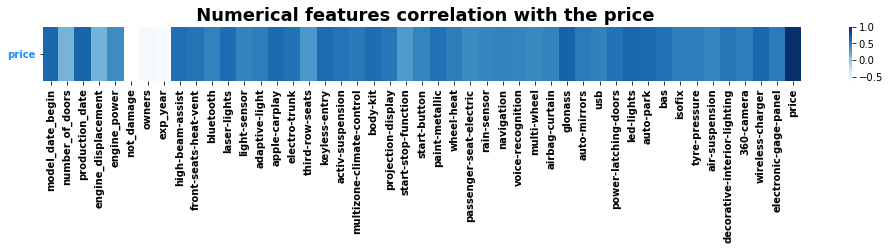

In [153]:
import matplotlib.pyplot as plt

num=new_train.select_dtypes(exclude='object')
numcorr=num.corr()
f,ax=plt.subplots(figsize=(17,1))
sns.heatmap(numcorr.sort_values(by=['price'], ascending=False).head(1), cmap='Blues')
plt.title(" Numerical features correlation with the price", weight='bold', fontsize=18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)


plt.show()

In [155]:
num=numcorr['price'].sort_values(ascending=False).head(10).to_frame()

cm = sns.light_palette("cyan", as_cmap=True)

s = num.style.background_gradient(cmap=cm)
s

,price
price,1.000000
glonass,0.675580
production_date,0.665893
led-lights,0.654325
model_date_begin,0.653216
wireless-charger,0.648140
apple-carplay,0.625888
auto-park,0.622234
keyless-entry,0.616321
body-kit,0.614662


In [177]:
# Все возможные типы топлива
fuel_type_uniq = new_train['fuel_type'].unique()
fuel_type_uniq

array(['gasoline', 'diesel', 'hybrid', 'electro'], dtype=object)

In [179]:
# Формирование dummy- столбцов для топлива
new_train_extend = pd.concat([new_train, 
                              pd.get_dummies(new_train['fuel_type'])], 
                             axis=1)

In [180]:
# Коэффициенты корреляции
fuel_type_corr = new_train_extend[fuel_type_uniq].corr()
fuel_type_corr

,gasoline,diesel,hybrid,electro
gasoline,1.000000,-0.994976,-0.050900,-0.043752
diesel,-0.994976,1.000000,-0.025067,-0.021547
hybrid,-0.050900,-0.025067,1.000000,-0.001102
electro,-0.043752,-0.021547,-0.001102,1.000000


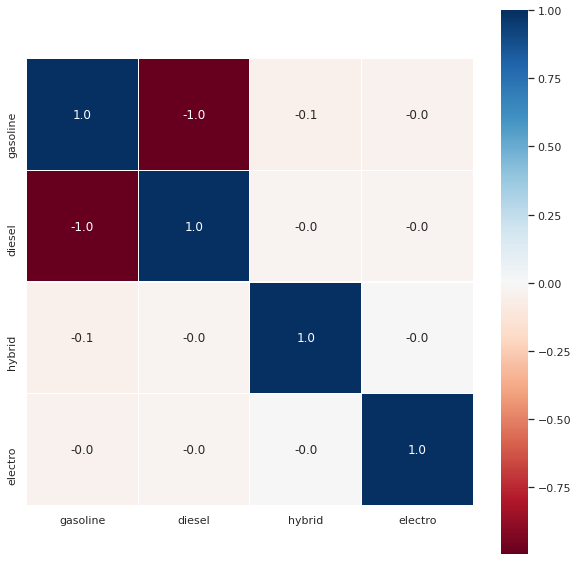

In [181]:
# Тепловая карта
sns.set(font_scale=1)
plt.subplots(figsize=(10, 10))
sns.heatmap(fuel_type_corr, square=True, 
           annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Вижу мультиколлениарную зависимость между бензином и дизелем. Надо убрать один из признаков. P.S. По факту оказалось, что это значительно снижает качество предсказания, поэтому отказался от удаления.

In [ ]:
### Drop fuel_type_gasoline
new_big_df.drop('fuel_type_gasoline', axis=1, inplace=True)

Проверим на выбросы цены

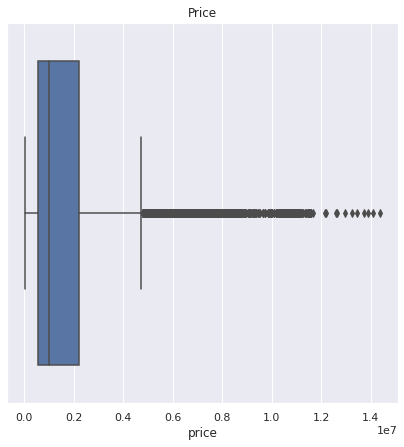

In [158]:
fig = plt.figure(figsize=(7, 7))
plt.grid(True)
plt.title('Price')
sns.boxplot(x = new_train['price'])

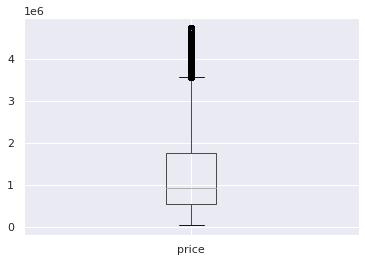

In [160]:
Q1 =  new_train['price'].quantile(0.25)
Q3 = new_train['price'].quantile(0.75)
IQR = Q3 - Q1

new_train.query("@Q1 - 1.5*@IQR < price < @Q3 + 1.5*@IQR").boxplot(column="price")

![](https://i.stack.imgur.com/qX5jd.jpg)

In [161]:
outliers_price = outliers_iqr_long(new_train.price)

print(len(outliers_price))

Медиана: 1001000.0, 25-й перцентиль: 546000.0, 75-й перцентиль: 2229500.0, IQR: 1683500.0,  Границы выбросов: [-1979250.0, 4754750.0].
17959


Количество пропусков: 0
count    1.795900e+04
mean     1.657099e+06
std      1.792881e+06
min      2.730000e+04
25%      5.460000e+05
50%      1.001000e+06
75%      2.229500e+06
max      1.436899e+07
Name: price, dtype: float64,
Распределение:
1001000.00     252
500500.00      244
1092000.00     227
591500.00      227
409500.00      225
              ... 
10646242.88      1
5396300.00       1
7231224.00       1
7971600.00       1
5960486.35       1
Name: price, Length: 3066, dtype: int64,


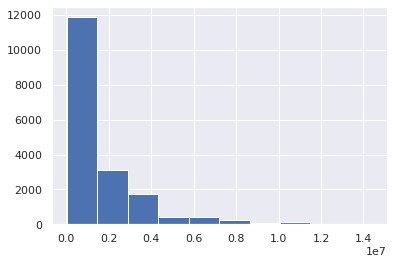

In [164]:
col_info(new_train.price)

Ну что я тут вижу - смещенность влево. Следовательно, можно попробовать прологарифмировать цену. Что я и сделал в третьем варианте стекинга.

С выбросами цен ничего делать пока не буду.

In [165]:
new_train_corr = new_train.corr()
new_train_corr

,model_date_begin,number_of_doors,production_date,engine_displacement,engine_power,not_damage,owners,exp_year,high-beam-assist,front-seats-heat-vent,...,auto-park,bas,isofix,tyre-pressure,air-suspension,decorative-interior-lighting,360-camera,wireless-charger,electronic-gage-panel,price
model_date_begin,1.000000,0.209772,0.985151,-0.097062,0.202633,NaN,-0.603890,-0.796611,0.400225,0.266685,...,0.476279,0.479210,0.556038,0.497138,0.203396,0.442353,0.232091,0.335332,0.288970,0.653216
number_of_doors,0.209772,1.000000,0.202547,0.072239,0.094290,NaN,-0.144990,-0.080348,0.076666,0.041522,...,0.085484,0.082268,0.135170,0.083074,0.095107,0.036965,0.060677,0.060674,0.040402,0.136756
production_date,0.985151,0.202547,1.000000,-0.120373,0.185137,NaN,-0.628081,-0.816454,0.409360,0.262480,...,0.486634,0.490281,0.568304,0.507690,0.197038,0.454929,0.226841,0.342250,0.288464,0.665893
engine_displacement,-0.097062,0.072239,-0.120373,1.000000,0.836825,NaN,0.125374,0.104063,0.116679,0.247079,...,-0.065885,-0.065974,-0.124161,-0.038785,0.185003,-0.044670,0.179383,0.108294,0.119648,0.139612
engine_power,0.202633,0.094290,0.185137,0.836825,1.000000,NaN,-0.071710,-0.175303,0.261514,0.363724,...,0.055157,0.061596,0.069828,0.125780,0.213343,0.076106,0.302356,0.220109,0.222856,0.412154
not_damage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
owners,-0.603890,-0.144990,-0.628081,0.125374,-0.071710,NaN,1.000000,0.615217,-0.381383,-0.233105,...,-0.510717,-0.495341,-0.485119,-0.436016,-0.199881,-0.461837,-0.205327,-0.356899,-0.273226,-0.621747
exp_year,-0.796611,-0.080348,-0.816454,0.104063,-0.175303,NaN,0.615217,1.000000,-0.396464,-0.259611,...,-0.477770,-0.468183,-0.526919,-0.470765,-0.192363,-0.436055,-0.221246,-0.334870,-0.270388,-0.643842
high-beam-assist,0.400225,0.076666,0.409360,0.116679,0.261514,NaN,-0.381383,-0.396464,1.000000,0.498631,...,0.486749,0.499197,0.438484,0.536373,0.395834,0.542174,0.391090,0.563997,0.533000,0.601848
front-seats-heat-vent,0.266685,0.041522,0.262480,0.247079,0.363724,NaN,-0.233105,-0.259611,0.498631,1.000000,...,0.387030,0.330782,0.284836,0.358529,0.518137,0.351822,0.546597,0.548169,0.510335,0.563860


In [166]:
# new_train_corr.style.background_gradient(cmap='coolwarm')
new_train_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,model_date_begin,number_of_doors,production_date,engine_displacement,engine_power,not_damage,owners,exp_year,high-beam-assist,front-seats-heat-vent,bluetooth,laser-lights,light-sensor,adaptive-light,apple-carplay,electro-trunk,third-row-seats,keyless-entry,activ-suspension,multizone-climate-control,body-kit,projection-display,start-stop-function,start-button,paint-metallic,wheel-heat,passenger-seat-electric,rain-sensor,navigation,voice-recognition,multi-wheel,airbag-curtain,glonass,auto-mirrors,usb,power-latching-doors,led-lights,auto-park,bas,isofix,tyre-pressure,air-suspension,decorative-interior-lighting,360-camera,wireless-charger,electronic-gage-panel,price
model_date_begin,1.00,0.21,0.99,-0.10,0.20,nan,-0.60,-0.80,0.40,0.27,0.48,0.31,0.52,0.36,0.39,0.51,0.13,0.46,0.26,0.37,0.42,0.28,0.44,0.52,0.51,0.54,0.29,0.50,0.34,0.27,0.49,0.49,0.55,0.47,0.47,0.29,0.58,0.48,0.48,0.56,0.50,0.20,0.44,0.23,0.34,0.29,0.65
number_of_doors,0.21,1.00,0.20,0.07,0.09,nan,-0.14,-0.08,0.08,0.04,0.05,0.04,0.08,0.08,0.05,0.20,0.10,0.09,0.06,0.09,0.05,0.08,0.12,0.05,0.05,0.11,0.06,0.07,0.10,0.05,0.08,0.09,0.08,0.10,0.07,0.05,0.08,0.09,0.08,0.14,0.08,0.10,0.04,0.06,0.06,0.04,0.14
production_date,0.99,0.20,1.00,-0.12,0.19,nan,-0.63,-0.82,0.41,0.26,0.49,0.31,0.53,0.36,0.40,0.53,0.13,0.47,0.26,0.37,0.43,0.28,0.45,0.53,0.52,0.56,0.30,0.51,0.34,0.27,0.49,0.50,0.57,0.48,0.49,0.29,0.59,0.49,0.49,0.57,0.51,0.20,0.45,0.23,0.34,0.29,0.67
engine_displacement,-0.10,0.07,-0.12,1.00,0.84,nan,0.13,0.10,0.12,0.25,-0.02,0.07,-0.02,0.14,0.03,0.03,0.07,0.07,0.14,0.07,-0.04,0.21,-0.12,-0.10,-0.05,-0.02,0.22,-0.02,0.20,0.11,-0.04,-0.05,-0.11,0.07,-0.06,0.23,-0.10,-0.07,-0.07,-0.12,-0.04,0.19,-0.04,0.18,0.11,0.12,0.14
engine_power,0.20,0.09,0.19,0.84,1.00,nan,-0.07,-0.18,0.26,0.36,0.15,0.21,0.15,0.27,0.16,0.18,0.10,0.22,0.24,0.17,0.11,0.33,0.03,0.09,0.10,0.14,0.33,0.14,0.31,0.21,0.12,0.12,0.04,0.20,0.12,0.35,0.08,0.06,0.06,0.07,0.13,0.21,0.08,0.30,0.22,0.22,0.41
not_damage,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
owners,-0.60,-0.14,-0.63,0.13,-0.07,nan,1.00,0.62,-0.38,-0.23,-0.41,-0.32,-0.42,-0.32,-0.42,-0.49,-0.13,-0.45,-0.27,-0.37,-0.45,-0.27,-0.35,-0.42,-0.51,-0.45,-0.23,-0.40,-0.27,-0.23,-0.39,-0.42,-0.59,-0.44,-0.43,-0.26,-0.59,-0.51,-0.50,-0.49,-0.44,-0.20,-0.46,-0.21,-0.36,-0.27,-0.62
exp_year,-0.80,-0.08,-0.82,0.10,-0.18,nan,0.62,1.00,-0.40,-0.26,-0.44,-0.30,-0.47,-0.34,-0.39,-0.50,-0.12,-0.46,-0.25,-0.35,-0.43,-0.27,-0.41,-0.49,-0.50,-0.51,-0.26,-0.45,-0.30,-0.25,-0.44,-0.45,-0.55,-0.45,-0.45,-0.28,-0.58,-0.48,-0.47,-0.53,-0.47,-0.19,-0.44,-0.22,-0.33,-0.27,-0.64
high-beam-assist,0.40,0.08,0.41,0.12,0.26,nan,-0.38,-0.40,1.00,0.50,0.51,0.48,0.53,0.79,0.60,0.57,0.21,0.62,0.50,0.51,0.55,0.55,0.35,0.53,0.47,0.49,0.52,0.52,0.53,0.51,0.45,0.46,0.55,0.55,0.51,0.57,0.55,0.49,0.50,0.44,0.54,0.40,0.54,0.39,0.56,0.53,0.60
front-seats-heat-vent,0.27,0.04,0.26,0.25,0.36,nan,-0.23,-0.26,0.50,1.00,0.33,0.43,0.33,0.47,0.45,0.40,0.23,0.46,0.54,0.39,0.34,0.55,0.20,0.33,0.33,0.35,0.40,0.32,0.44,0.44,0.29,0.31,0.34,0.38,0.32,0.68,0.33,0.39,0.33,0.28,0.36,0.52,0.35,0.55,0.55,0.51,0.56


Пройдусь по всем признакам и найду те, которые имеют высокую корреляцию с другими. Это будут наши претенденты на удаление.

In [190]:
# Create correlation matrix
corr_matrix = new_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)

# Drop features 
# new_big_df.drop(to_drop, axis=1, inplace=True)

['production_date']


Посмотрим вообще от каких признаков колеблется цена. Может там что-то интересного найду.

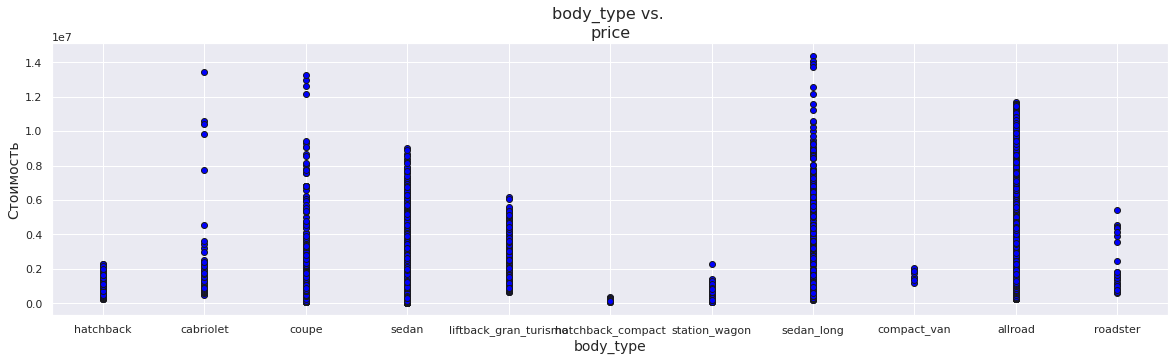

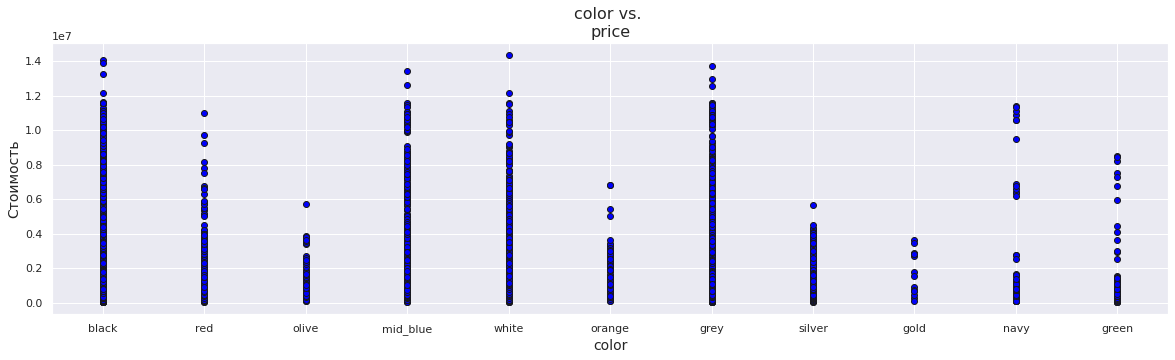

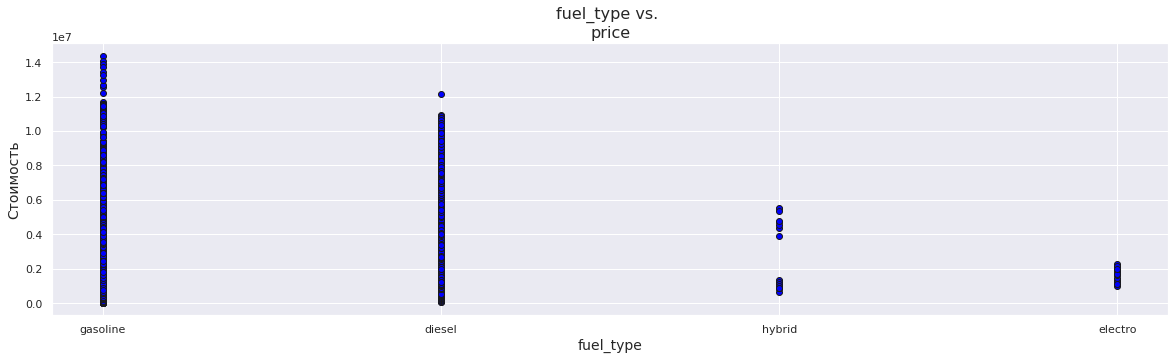

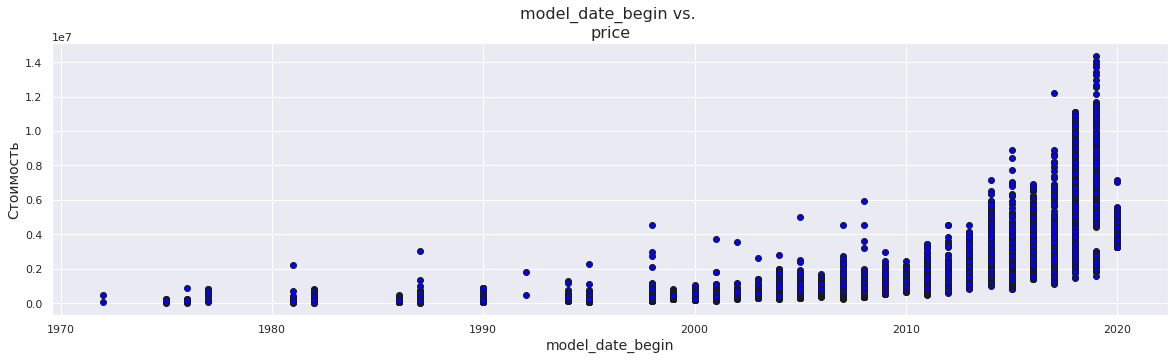

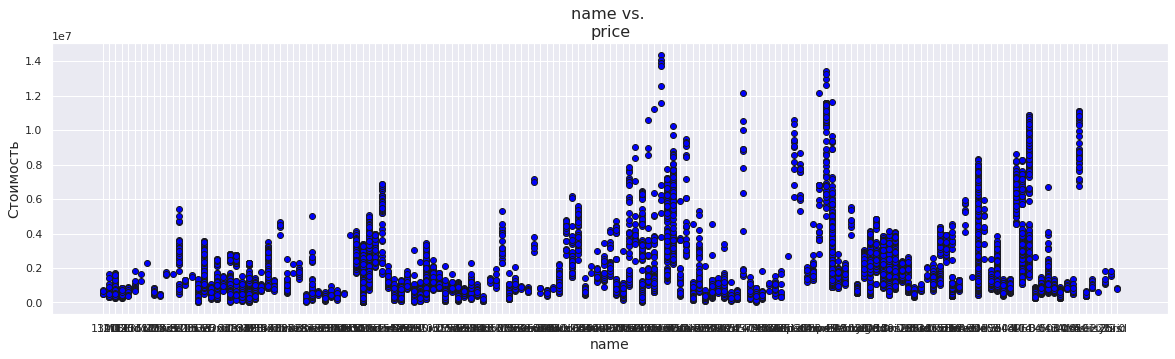

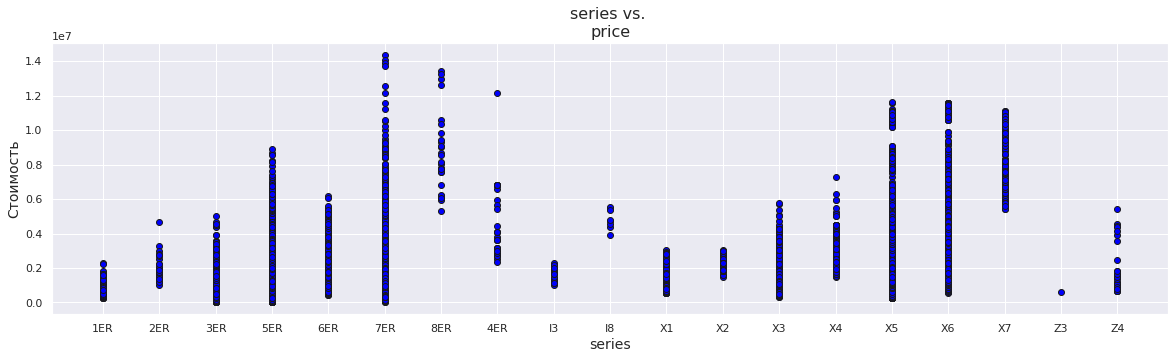

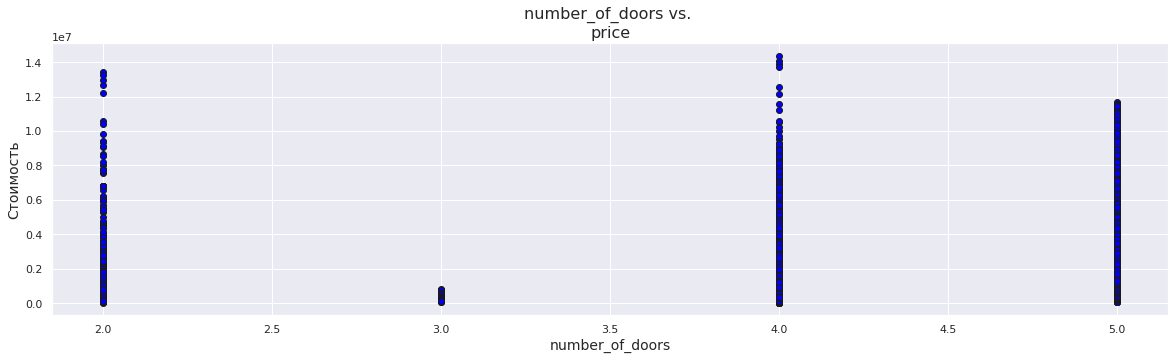

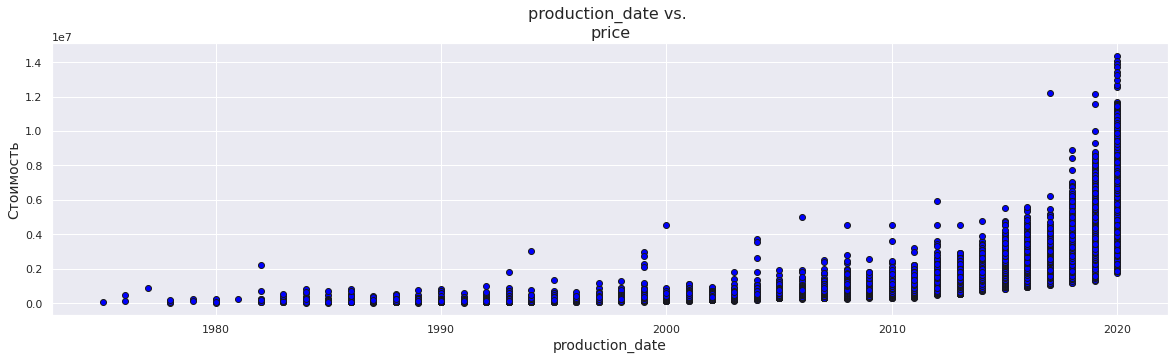

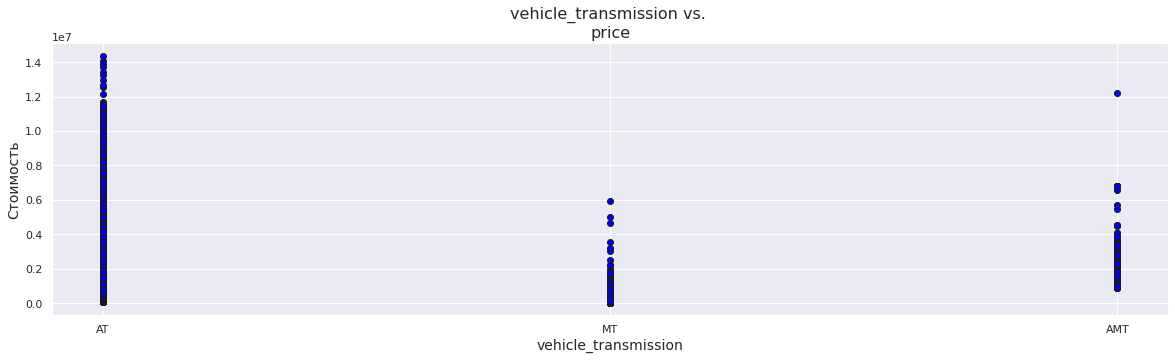

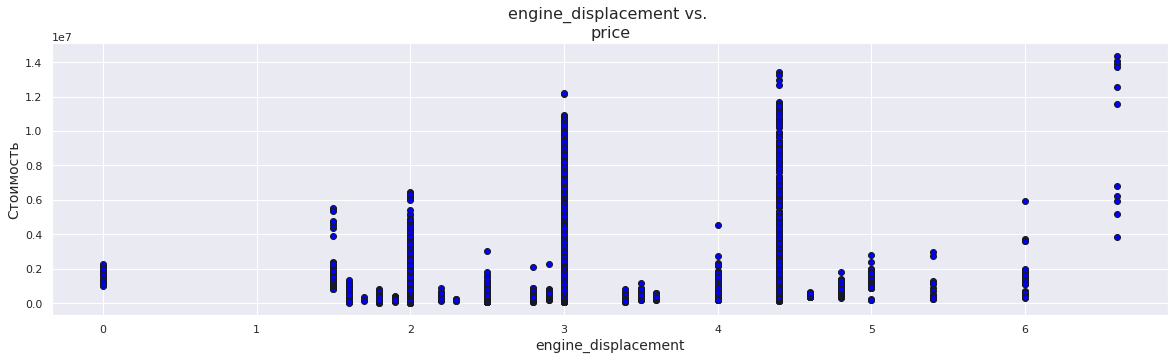

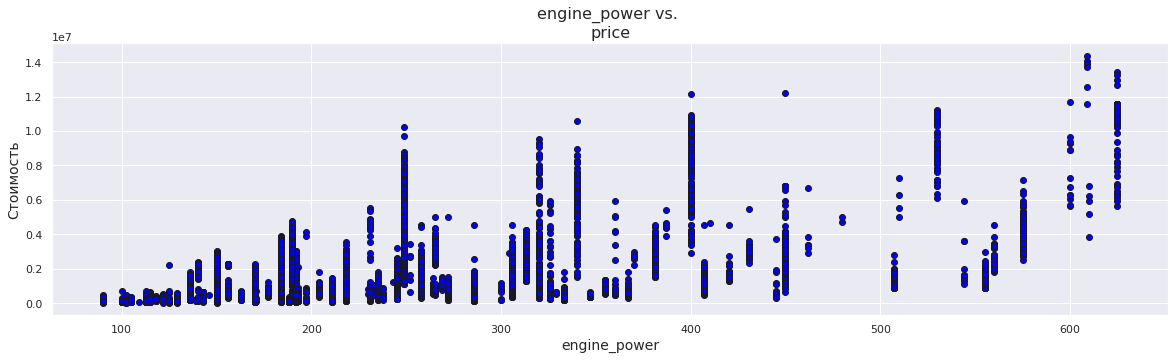

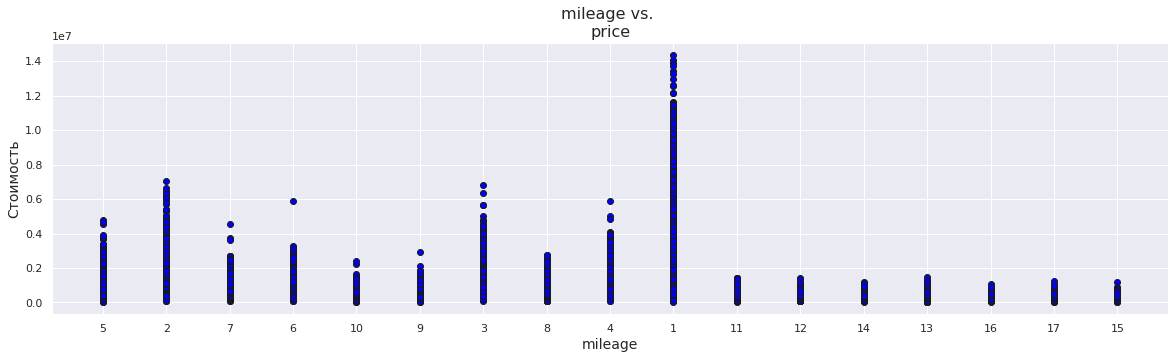

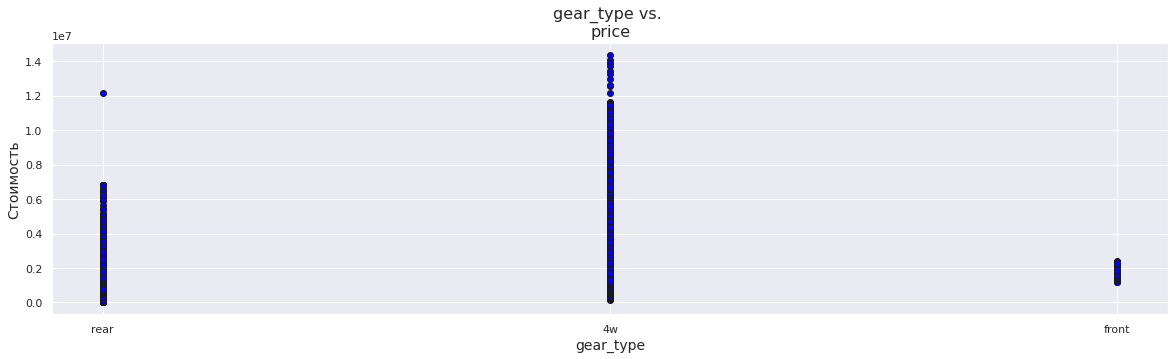

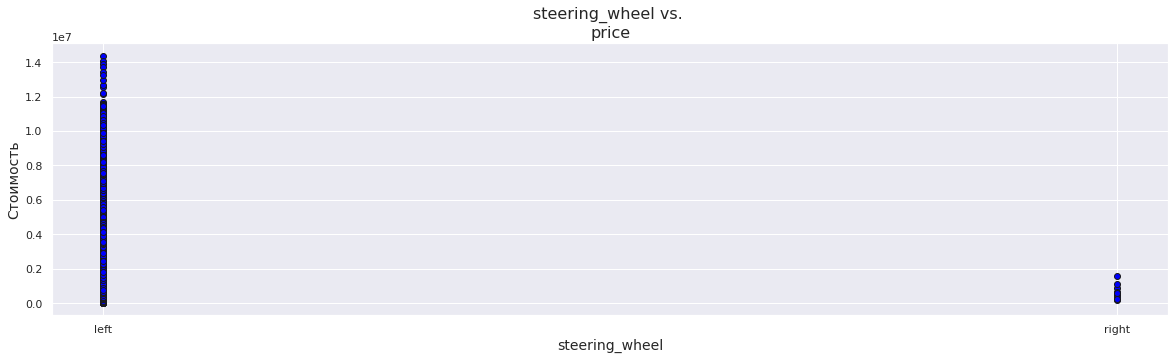

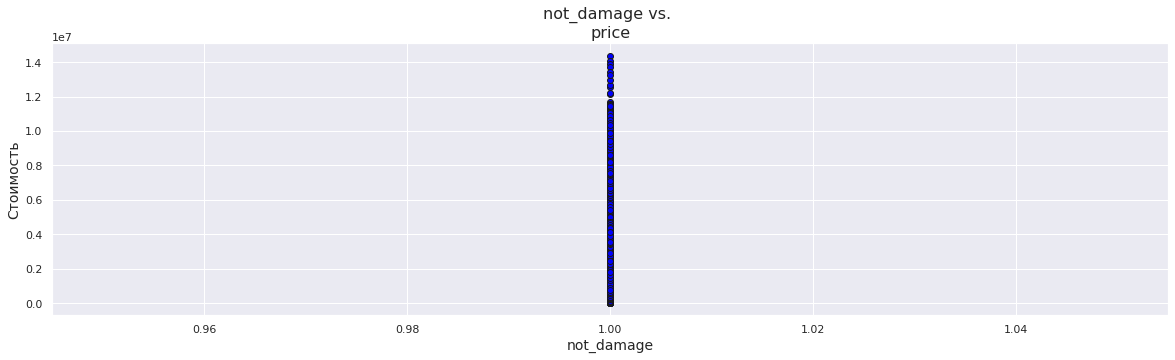

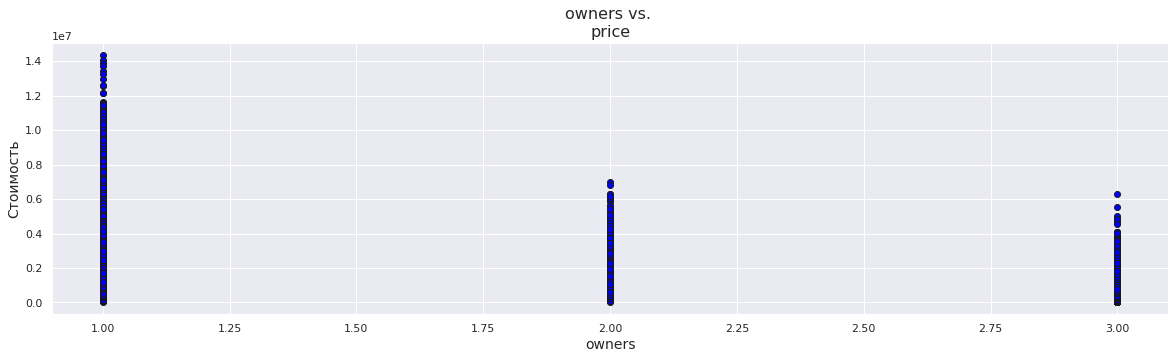

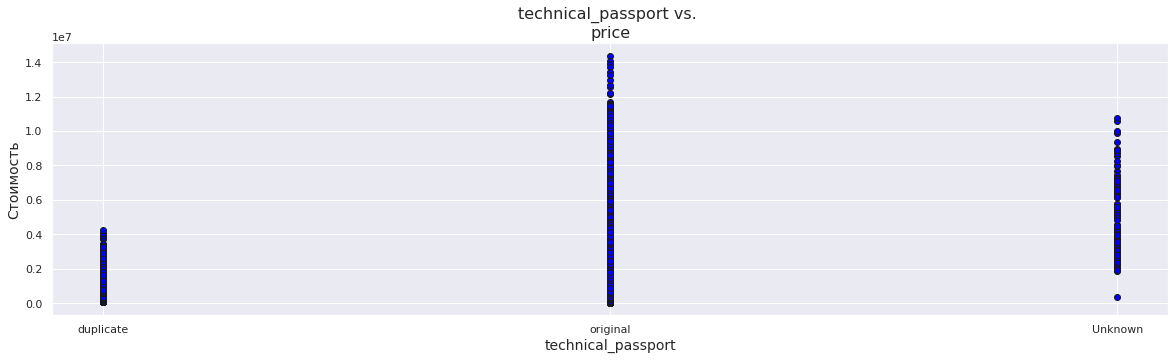

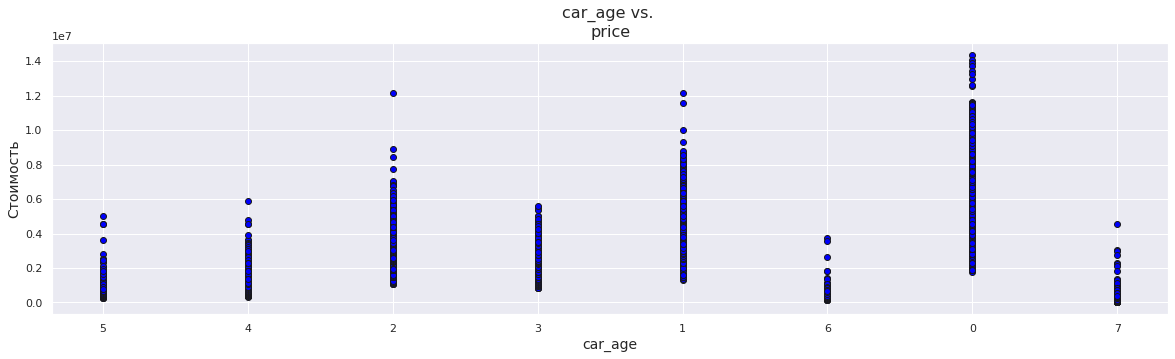

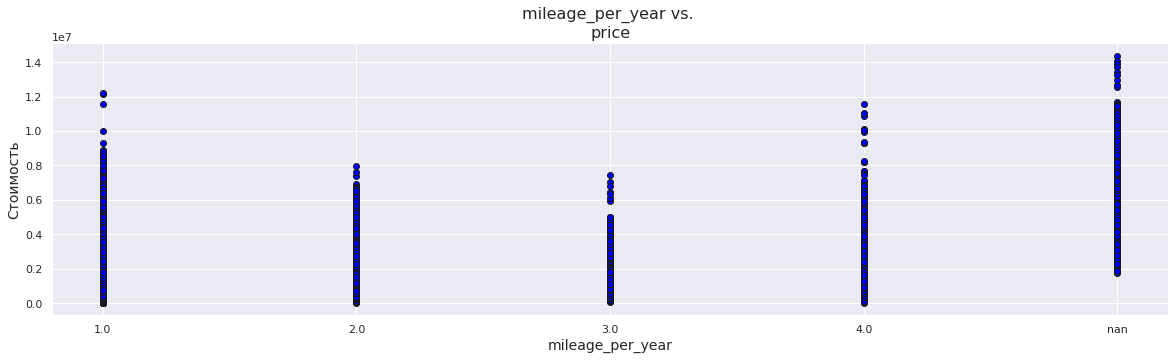

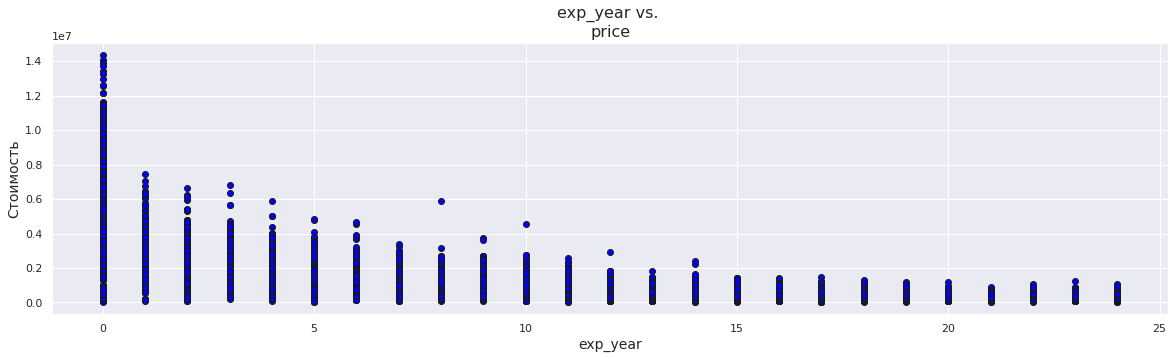

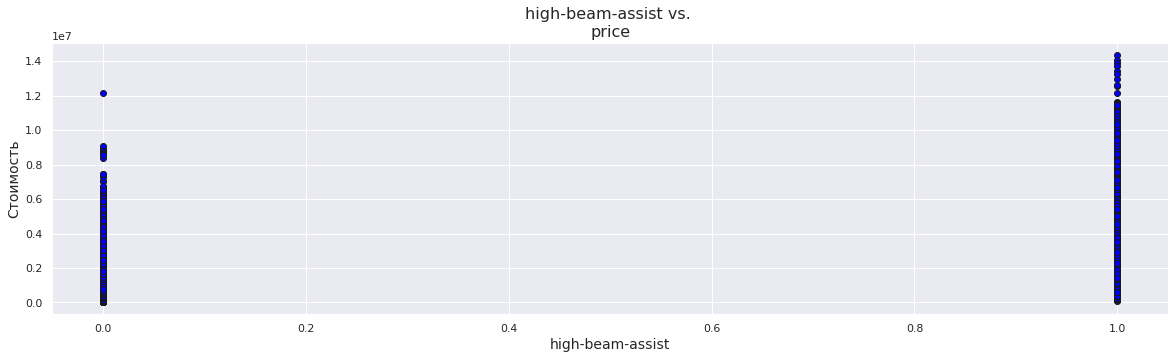

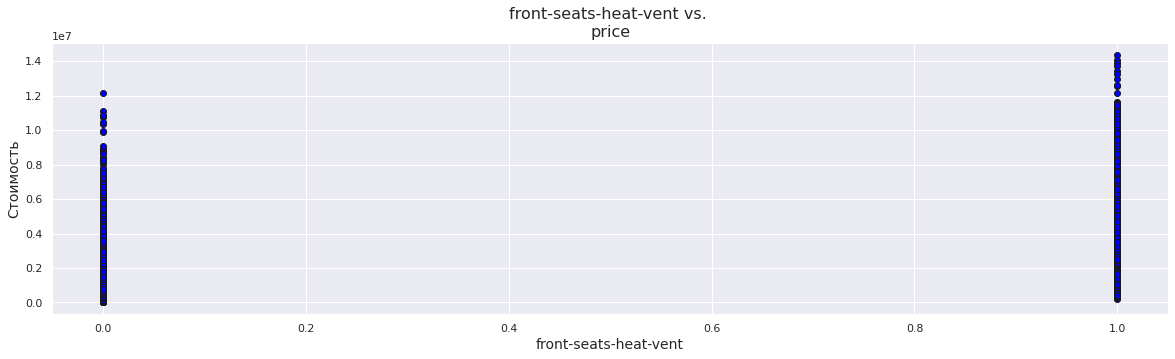

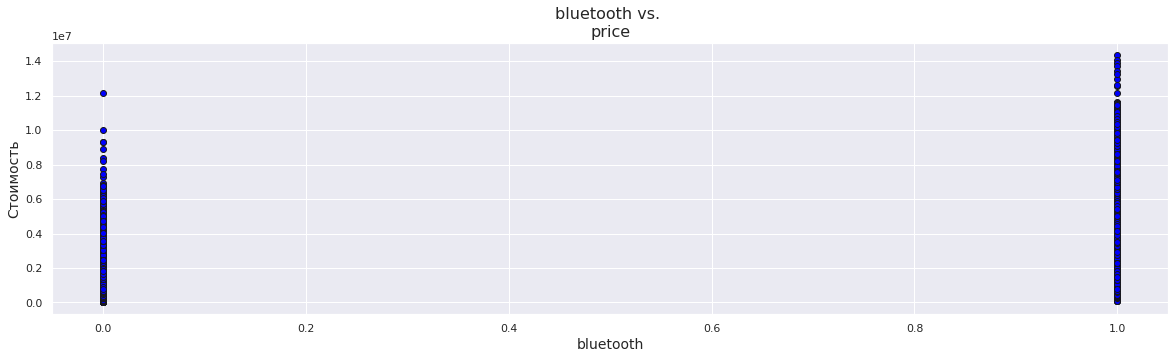

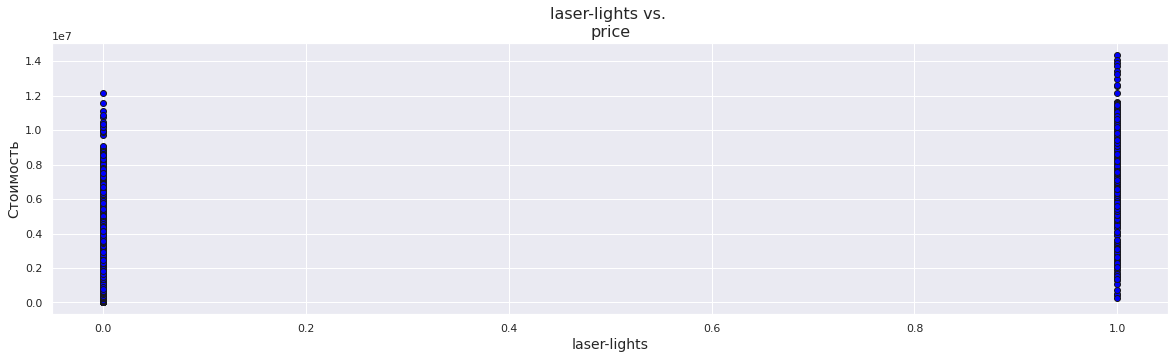

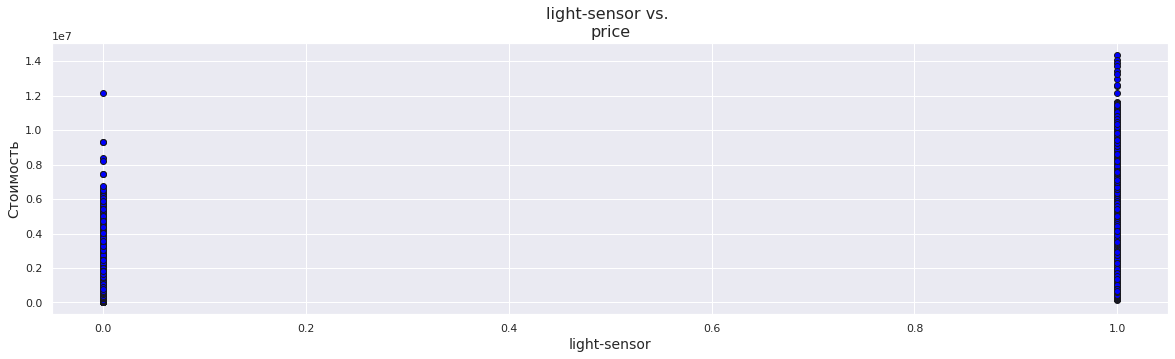

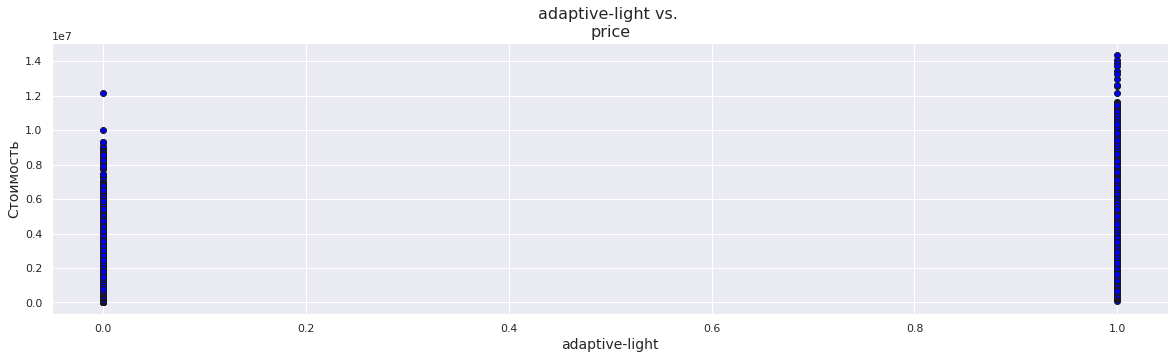

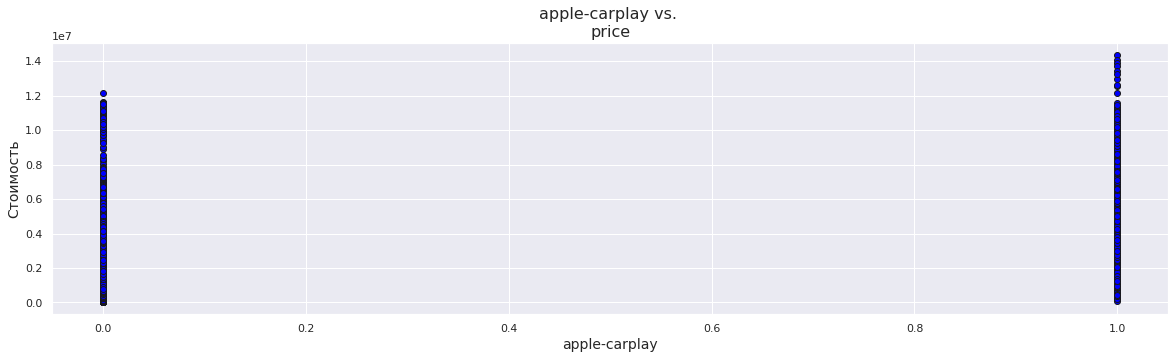

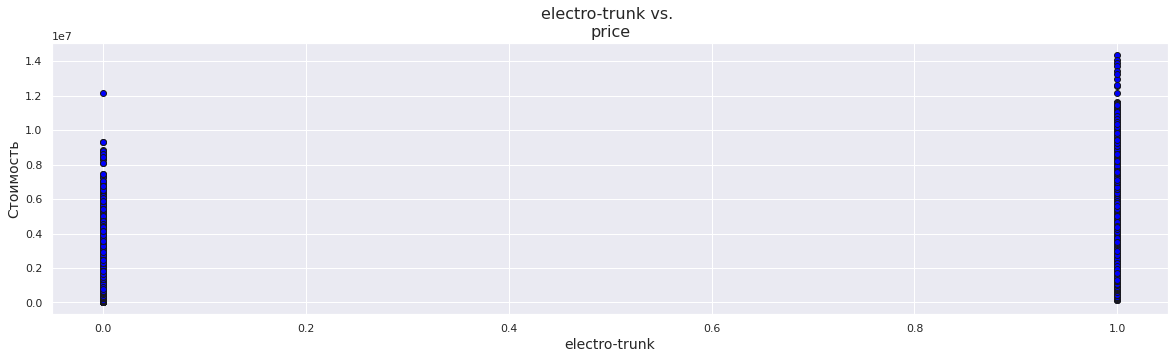

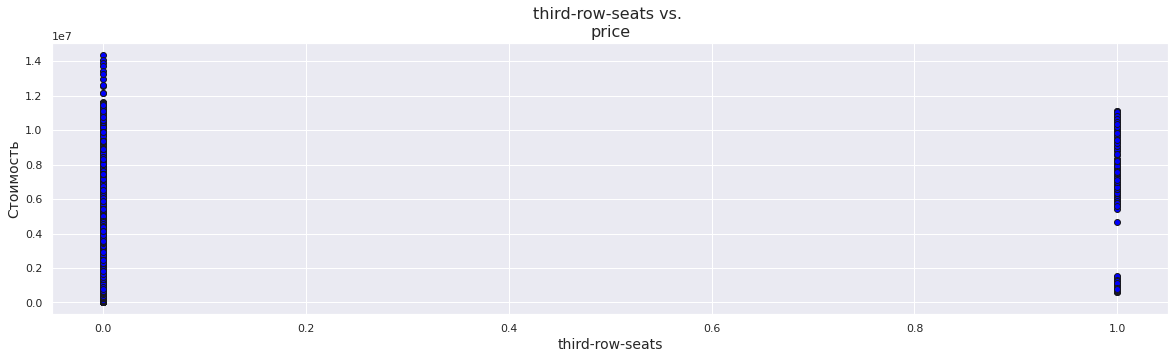

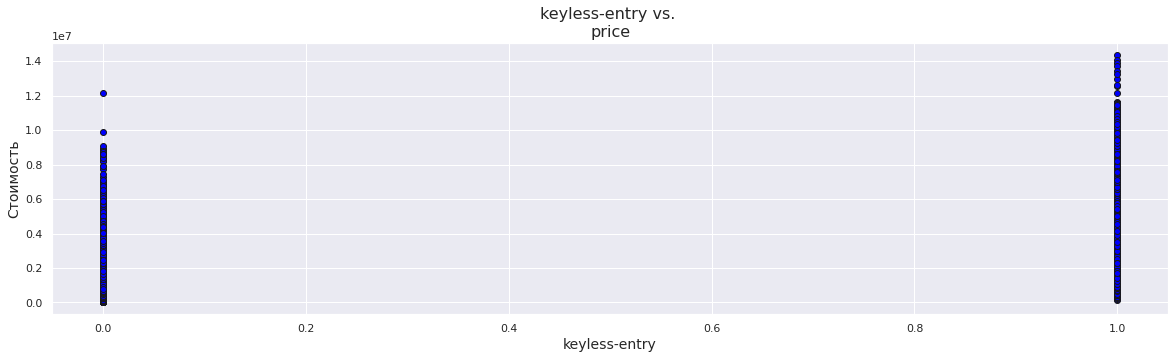

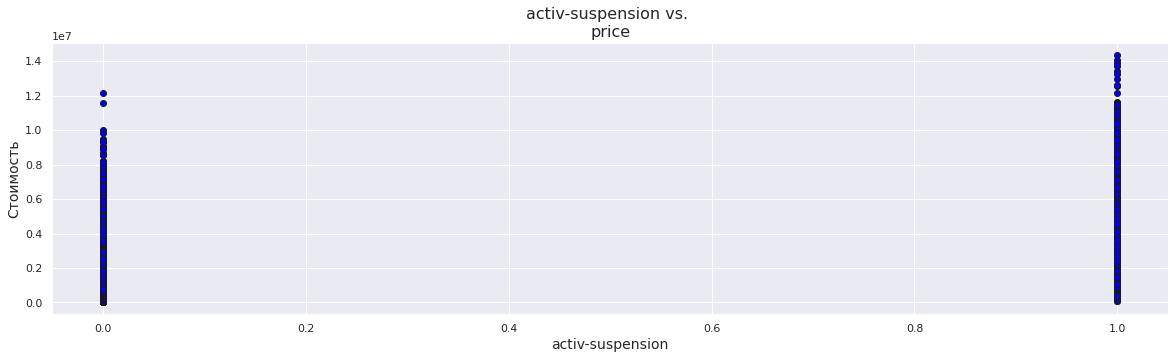

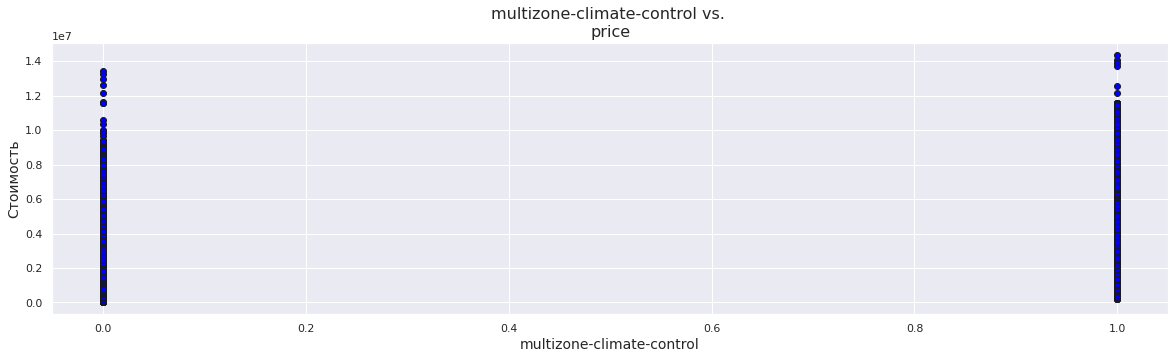

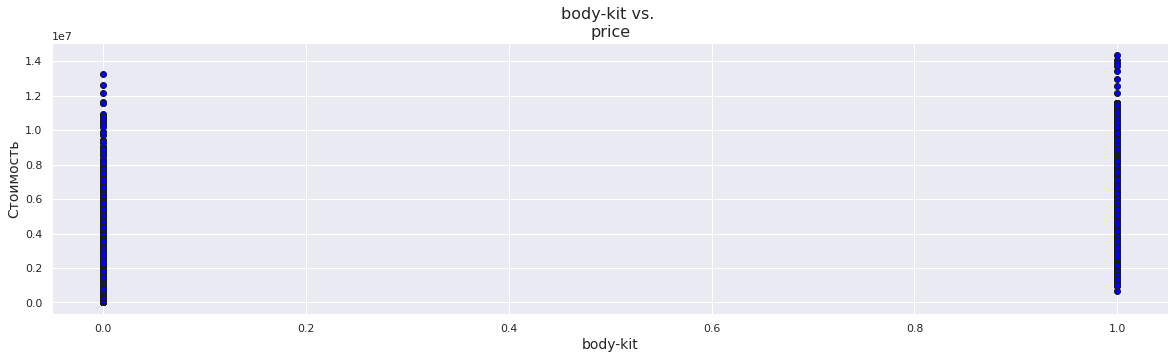

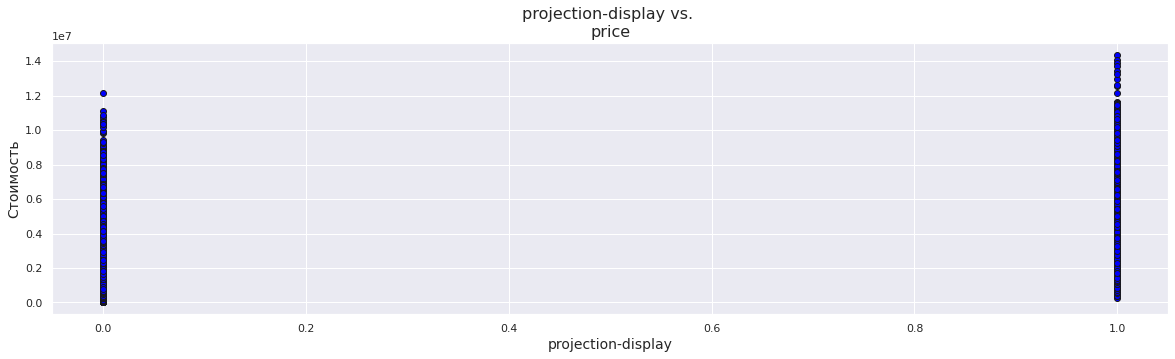

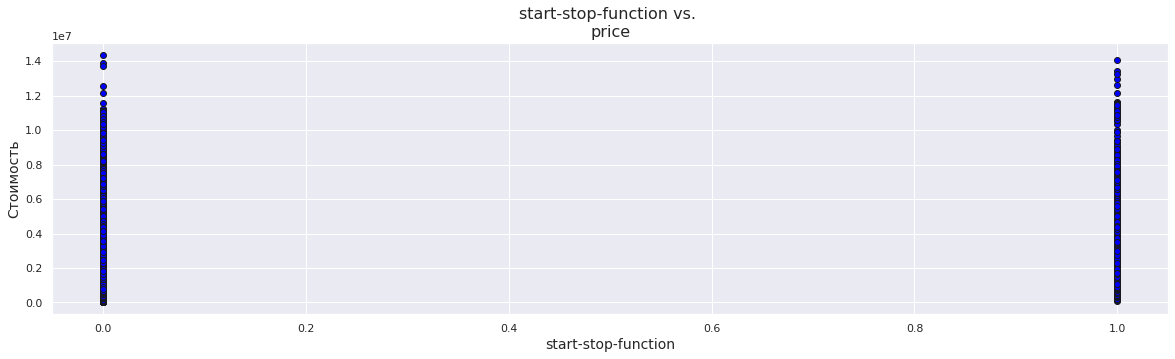

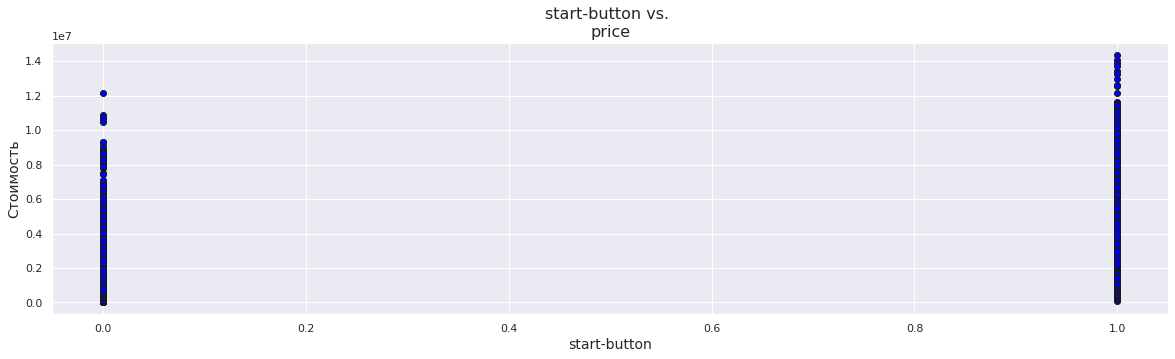

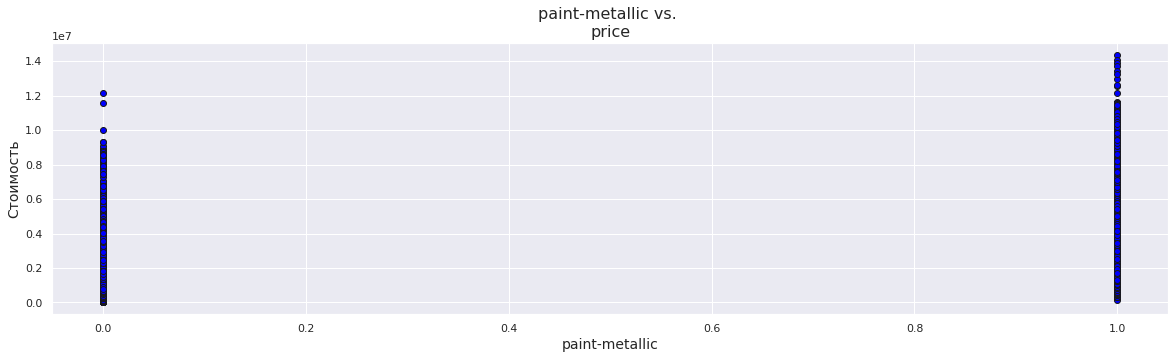

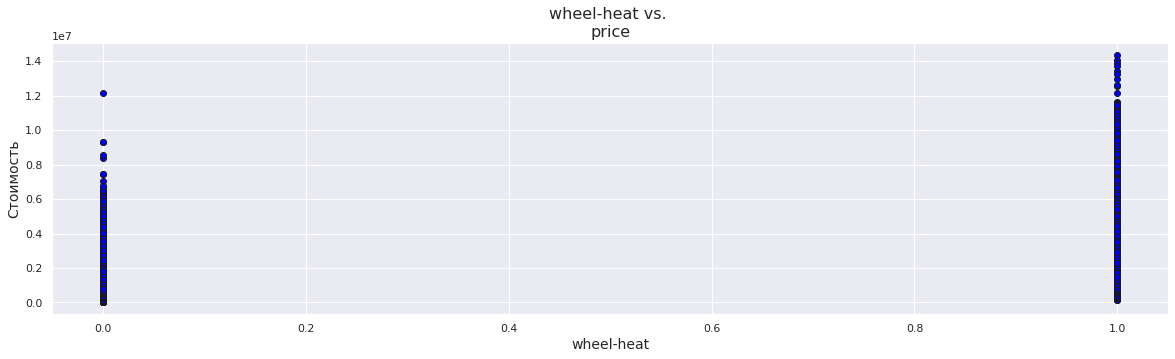

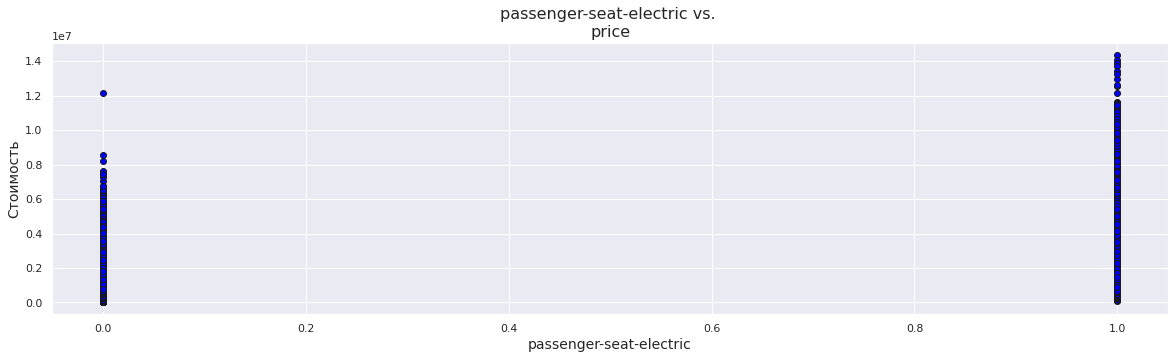

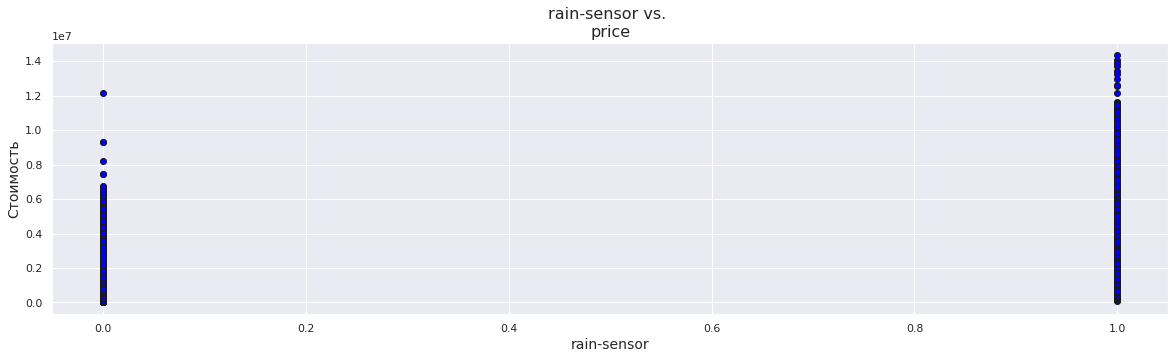

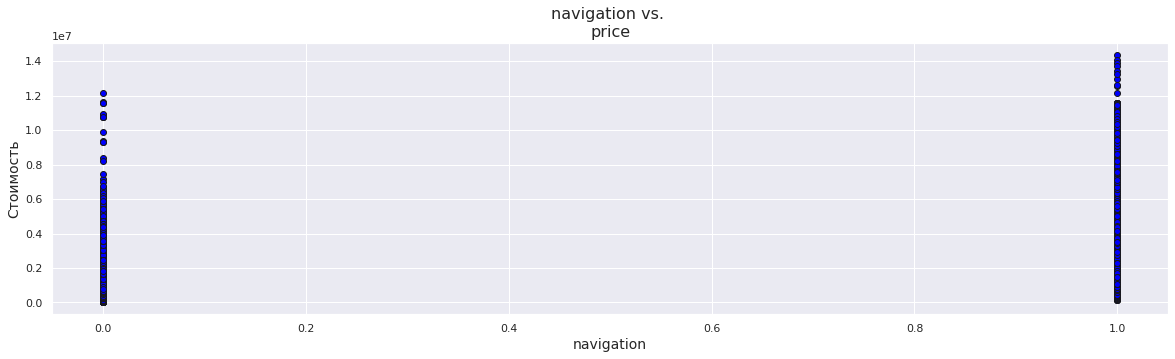

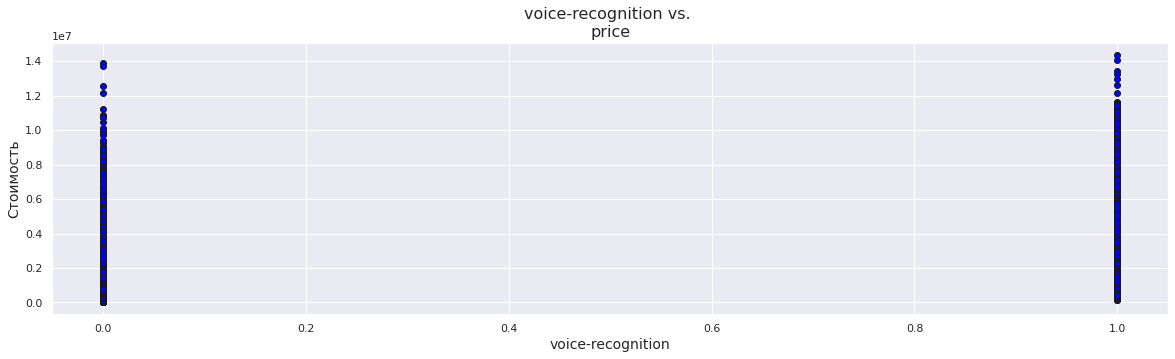

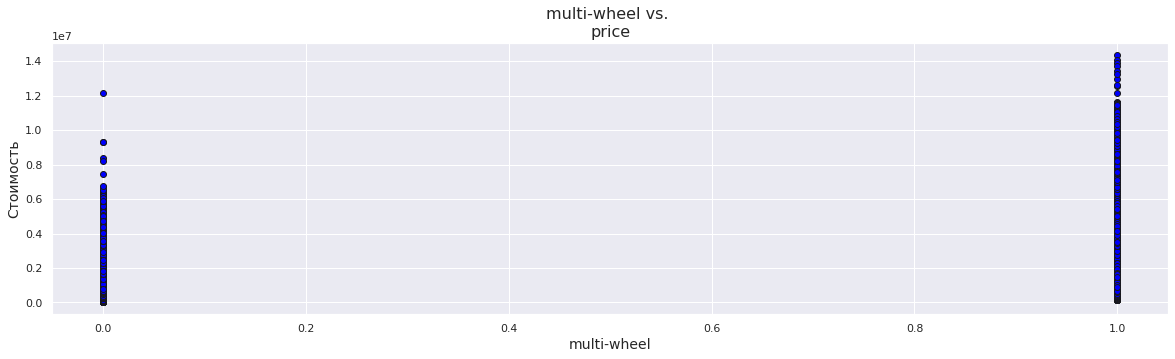

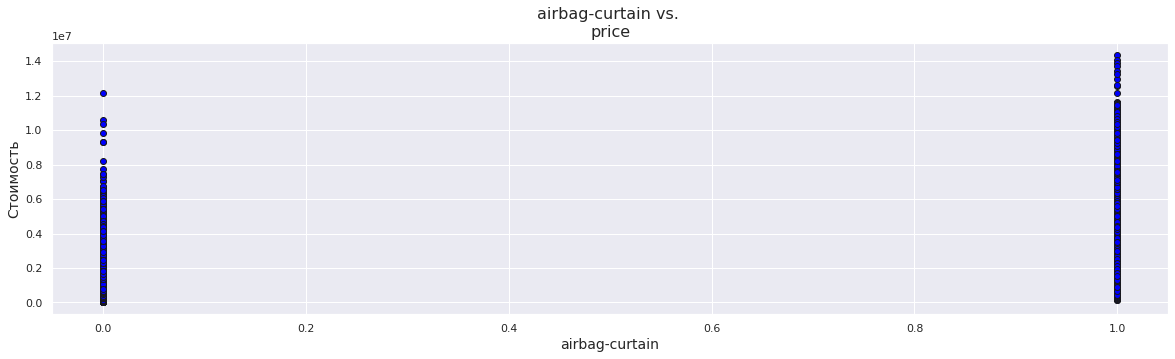

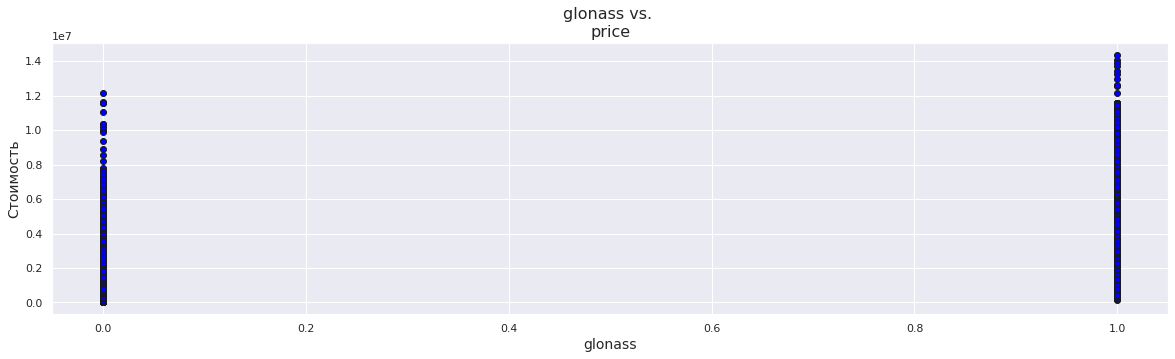

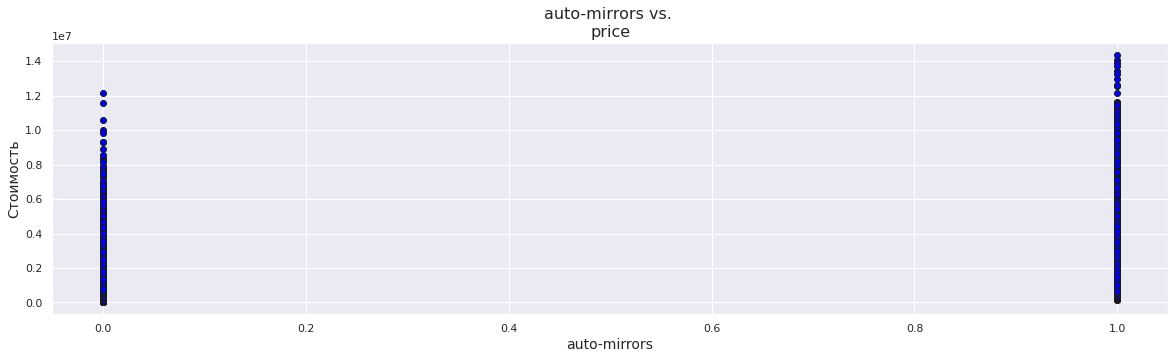

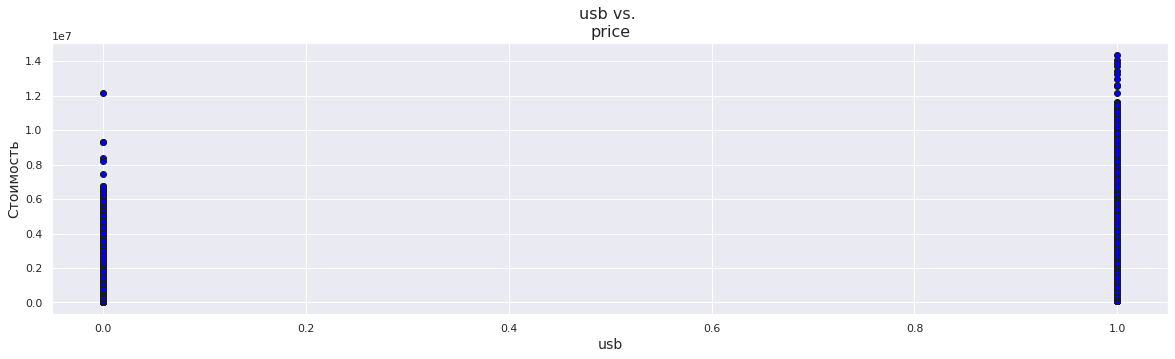

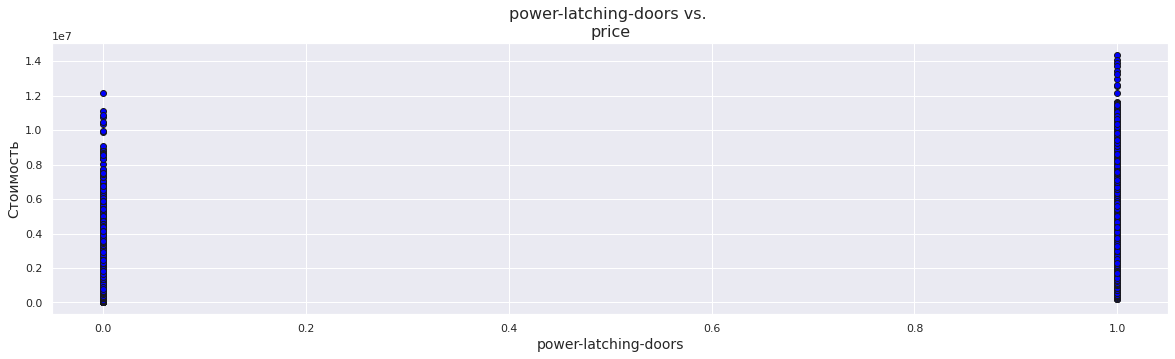

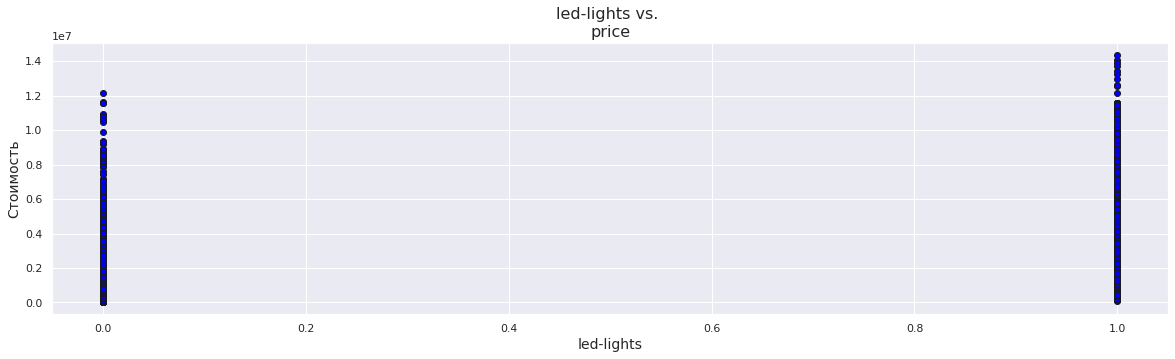

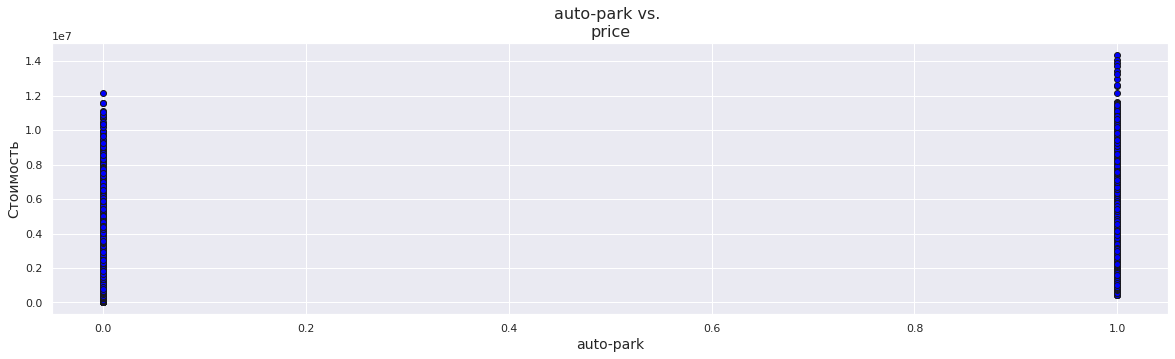

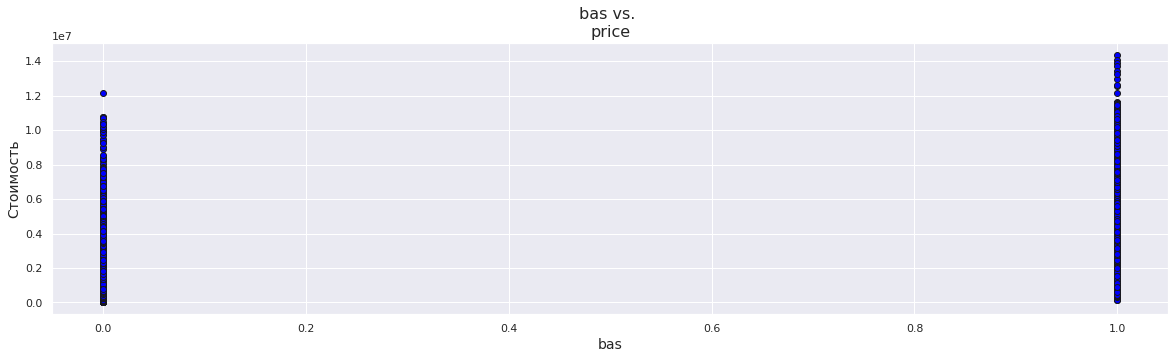

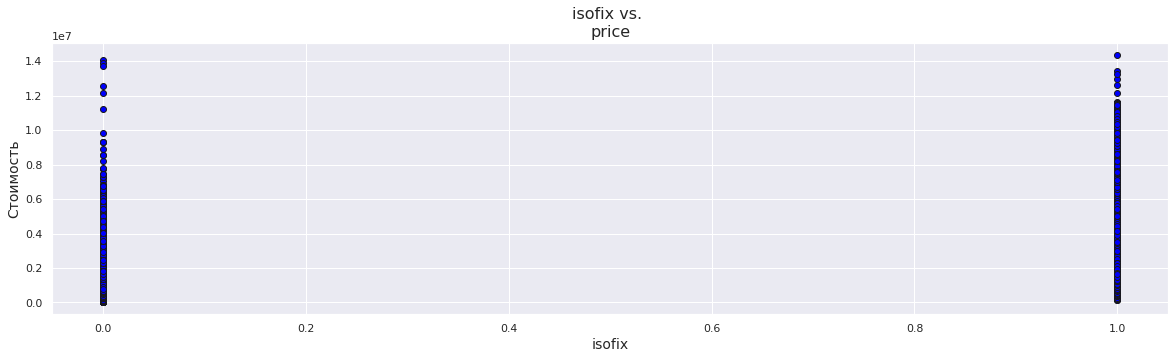

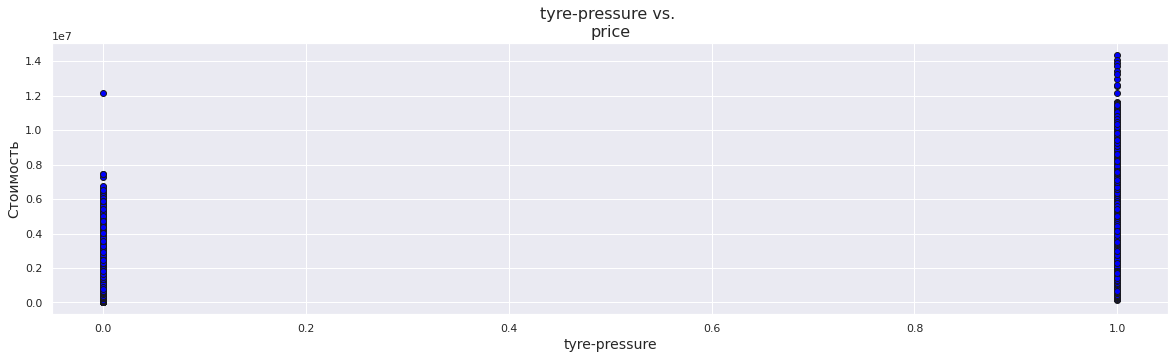

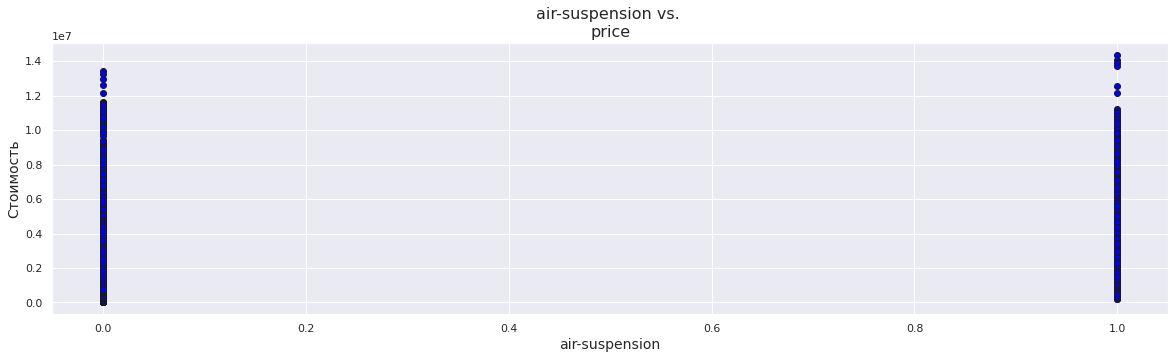

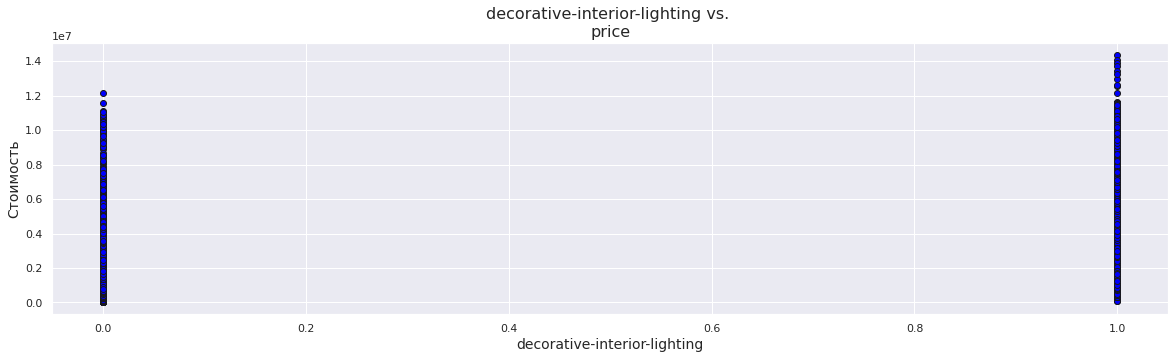

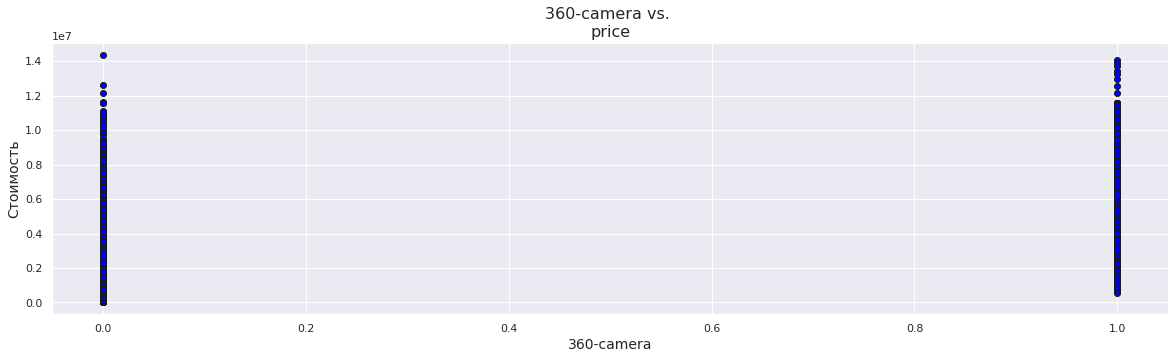

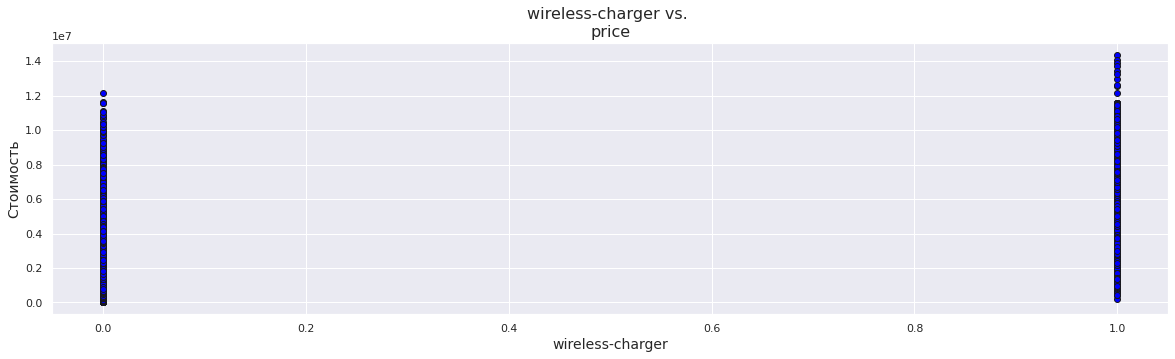

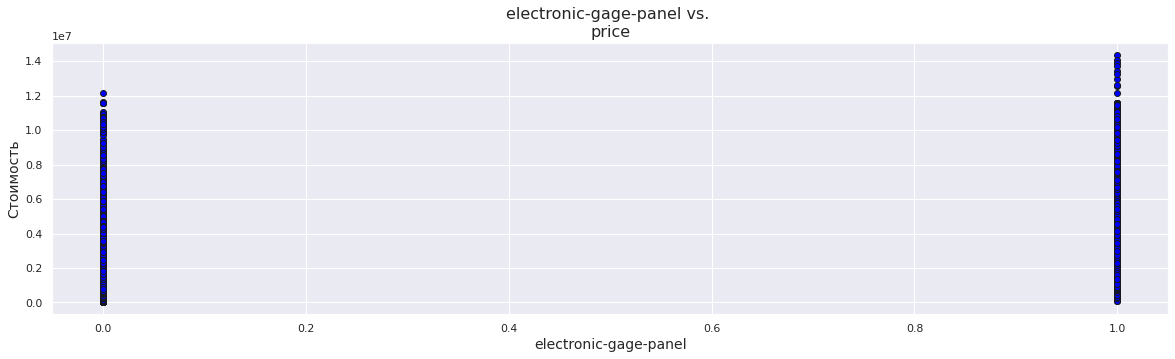

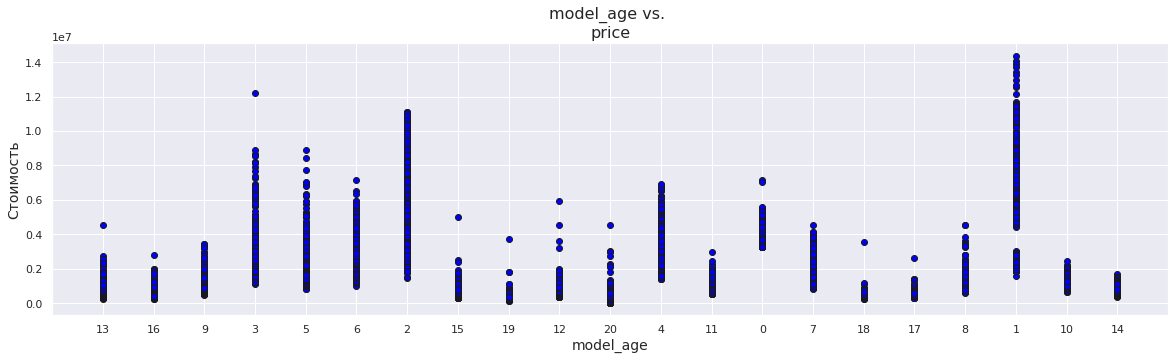

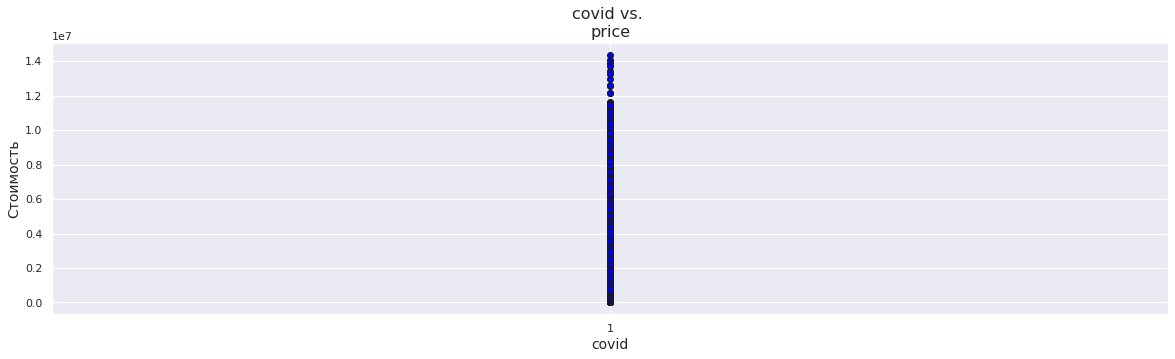

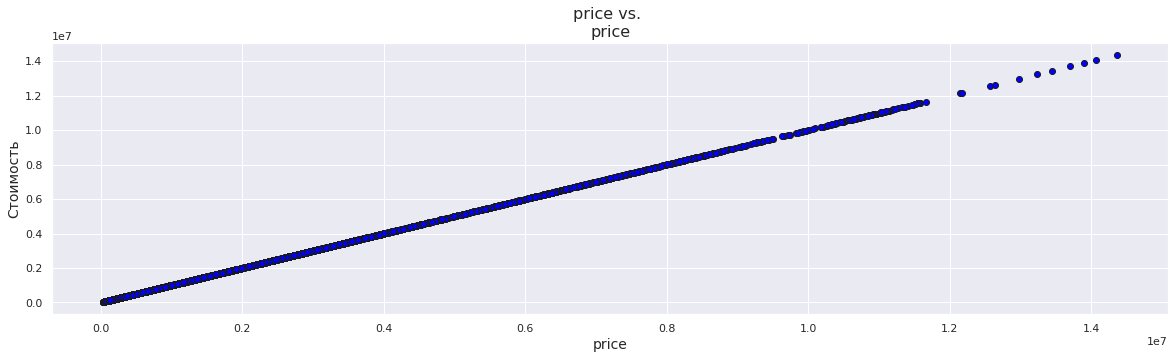

In [191]:
for c in new_train.columns[:-1]:
    plt.figure(figsize=(20,5))
    plt.title("{} vs. \nprice".format(c),fontsize=16)
    plt.scatter(x=new_train[c],y=new_train['price'],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Стоимость', fontsize=14)

    plt.show()

In [ ]:
new_big_df.columns.tolist()

В названиях автомобилей (марки) обнаружил странную штуку - какая-то группа с пропущенным названием. Буду исследовать это.

In [ ]:
new_big_df[['price', 'name']].groupby('name').sum()

In [ ]:
new_big_df[new_big_df['name'] == '']

In [ ]:
new_big_df['name'].value_counts()

In [ ]:
new_big_df['name'].unique()

Гляну на выбросы цен еще раз

Количество пропусков: 0
count    2.179600e+04
mean     1.365381e+06
std      1.745523e+06
min      0.000000e+00
25%      3.185000e+05
50%      7.735000e+05
75%      1.683500e+06
max      1.436899e+07
Name: price, dtype: float64,
Распределение:
0          3837
1001000     252
500500      244
1092000     228
591500      227
           ... 
6030024       1
5055050       1
5714786       1
2511586       1
2721791       1
Name: price, Length: 3063, dtype: int64,


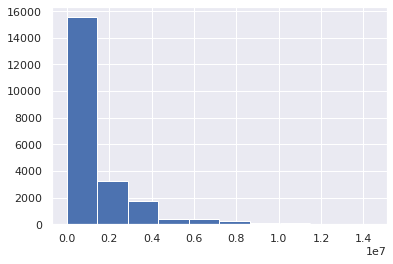

In [192]:
col_info(new_big_df.price)

In [203]:
# Функция очистки от выбросов
def delete_outliers_iqr(df, column):
    # Считаем первый и третий квартили
    first_quartile = df[column].describe()['25%']
    third_quartile = df[column].describe()['75%']

    # IQR (Межквартильный размах)
    iqr = third_quartile - first_quartile

    print(first_quartile, third_quartile, iqr)

    # Удаляем то, что выпадает за границы IQR
    #     df_tmp = df.copy()
    df = df[(df[column] > (first_quartile - 3 * iqr)) &
                (df[column] < (third_quartile + 3 * iqr))]

    df[column].hist()
    df[column].describe()

    df = df.loc[df[column].between(first_quartile - 1.5*iqr, third_quartile + 1.5*iqr)]
    df.info()

318500.0 1683500.0 1365000.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20158 entries, 0 to 21795
Columns: 330 entries, model_date_begin to popularity_1
dtypes: float64(1), int64(48), object(1), uint8(280)
memory usage: 13.2+ MB


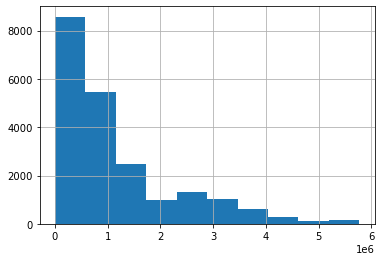

Посмотрю, можно ли придумать еще какие-то новые признаки.

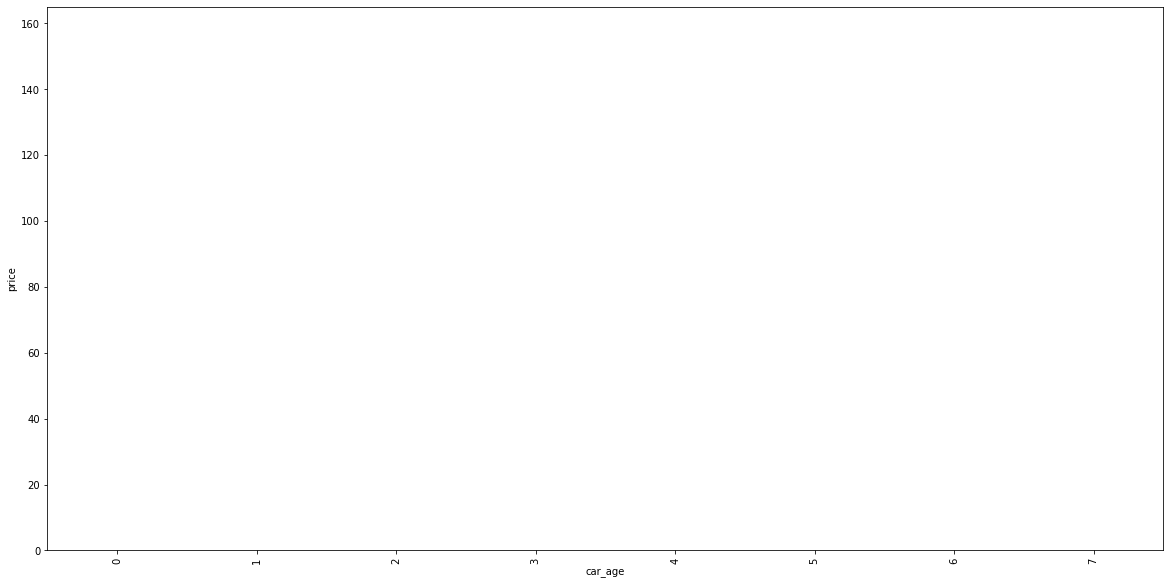

In [149]:
var = 'car_age'
data = pd.concat([new_train['price'], new_train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=165);
plt.xticks(rotation=90);

In [151]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(etc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

NotFittedError: This ExtraTreesRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<Figure size 864x576 with 0 Axes>

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Подгрузить еще больше данных
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking